In [3]:
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
# %matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [4]:

import pandas as pd
import numpy as np
np.random.seed(seed=41)
from itertools import combinations


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, f1_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

import scipy.stats as st

import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.optim as optim

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import wget

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# nltk.download('vader_lexicon')
import operator

from gensim.models import Word2Vec
import spacy

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import torch_geometric as torch_g
from torch_geometric.utils import to_networkx
import networkx as nx

import time

## Load Data

In [5]:
# load kyc
df_kyc = pd.read_csv('kyc.csv')

# load cash
df_cash = pd.read_csv('cash_trxns.csv')

# load emt
df_emt = pd.read_csv('emt_trxns.csv')

# load wire
df_wire = pd.read_csv('wire_trxns.csv')

## Investigate EMT and Wire DataFrames


### Investigate sender/receiver Ids

In [6]:
# Investigate sender ids
emt_senders = list(df_emt['id sender'].unique())
wire_senders = list(df_wire['id sender'].unique())

non_overlapping_sender_ids = len(set(wire_senders + emt_senders)) - len(emt_senders)
overlapping_sender_ids = len(wire_senders) - (non_overlapping_sender_ids)

print('non-overlapping sender ids:', non_overlapping_sender_ids)
print('overlapping sender ids:', overlapping_sender_ids)

# Investigate receiver ids
emt_receivers = list(df_emt['id receiver'].unique())
wire_receivers = list(df_wire['id receiver'].unique())

non_overlapping_receiver_ids = len(set(wire_receivers + emt_receivers)) - len(emt_receivers)
overlapping_receiver_ids = len(wire_receivers) - (non_overlapping_receiver_ids)

print('non-overlapping receiver ids:', non_overlapping_receiver_ids)
print('overlapping receiver ids:', overlapping_receiver_ids)

non-overlapping sender ids: 14872
overlapping sender ids: 30192
non-overlapping receiver ids: 12186
overlapping receiver ids: 32526


### Investigate EMT/Wires Ids with KYC Ids 

In [7]:
# emt/wire ids
emt_wire_ids = list(set(list(df_emt['id receiver'].unique()) + list(df_emt['id sender'].unique()) + 
               list(df_wire['id receiver'].unique()) + list(df_wire['id sender'].unique())))

# kyc ids
kyc_ids = list(df_kyc.cust_id.unique())

# check for non-overlapping ids
print('number of unique emt/wire ids:', len(emt_wire_ids))
print('number of unique kyc ids:', len(kyc_ids))

# overlapping ids
print('number of overlapping ids:', len(set(emt_wire_ids + kyc_ids)))
print('number of non-overlapping ids:', len(set(emt_wire_ids + kyc_ids)) - len(emt_wire_ids))
print('percentage of non-overlapping ids:', (len(set(emt_wire_ids + kyc_ids)) - len(emt_wire_ids))/
                                            (len(set(emt_wire_ids + kyc_ids)))*100)


number of unique emt/wire ids: 271300
number of unique kyc ids: 195789
number of overlapping ids: 300008
number of non-overlapping ids: 28708
percentage of non-overlapping ids: 9.56907815791579


Since the percentage of non-overlapping between the emt + wire and kyc datasets is small, we can use kyc to get available id node features. We can drop the ids that don't exist in the intersection of emt + wire and kyc datasets (~7%)

### Investigate overlapping Wire and EMT ids

In [8]:
# get all wire and emt Ids
emt_wire_ids = list(set(list(set(df_emt['id sender'])) + list(set(df_emt['id receiver'])) + \
               list(set(df_wire['id sender'])) + list(set(df_wire['id receiver']))))

# get wire ids
wire_ids = list(set(list(set(df_wire['id sender'])) + list(set(df_wire['id receiver']))))

# get emt ids
emt_ids = list(set(list(set(df_emt['id sender'])) + list(set(df_emt['id receiver']))))

print('Total number of unique emt and wire ids:', len(emt_wire_ids))
print('Total number of emt ids:', len(emt_ids))
print('Total number of wire ids:', len(wire_ids))
print('Total ids shared in emt dataset:', len(emt_ids)/len(emt_wire_ids))
print('Total ids shared in wire dataset:', len(wire_ids)/len(emt_wire_ids))

Total number of unique emt and wire ids: 271300
Total number of emt ids: 255260
Total number of wire ids: 69159
Total ids shared in emt dataset: 0.9408772576483597
Total ids shared in wire dataset: 0.25491706597862146


The datasets do not share many ids. The wire dataset contains only 25% of the total unique ids. This means that we cannot use Country data on the emt dataset.

We will treat these as separate networks.

# Prepare Graph Network

We can combine all the dataframes to create a graph network that can be used to train a Graph Neural Network to make predictions.

This graph network object will consist of a 1) Node Dataset and a 2) Edge Dataset

### Create Master Node Dictionary

Here, we unify all the unique different cust_id from all the different datasets into a unvisersal dictionary that gives each unique customer id a node id

In [9]:
all_nodes = list(df_kyc['cust_id']) + list(df_wire['id receiver']) + list(df_wire['id sender']) +\
            list(df_emt['id receiver']) + list(df_emt['id sender']) + list(df_cash['cust_id'])
print('total number of non-unique nodes', len(all_nodes))

unique_nodes = list(set(all_nodes))
print('total number of unique nodes', len(unique_nodes))

node_dictionary = {unique_nodes[i]: i for i in range(len(unique_nodes))}

total number of non-unique nodes 1556967
total number of unique nodes 300008


## Prepare Node DataFrame

To prepare the node dataframe, we can combine all the node-specific attributes from across the datasets provided. These attributes relate to the customer themself, and are not transaction-related.

#### Create Node Features

In [10]:
# Creates an 'External Customer' flag in the feature set
def external_customer(x):
    '''
    Function checks if cust id is external
    '''
    if 'EXTERNAL' in x.upper():
        return 1
    else:
        return 0

In [11]:
# Collect all Nodes
ids = list(df_emt['id sender']) + list(df_emt['id receiver']) + \
      list(df_wire['id sender']) + list(df_wire['id receiver']) + \
      list(df_cash['cust_id']) + list(df_kyc['cust_id'])
df_node = pd.DataFrame( data = ids, columns=['cust_id']).drop_duplicates()

# Map Node Dictioary onto cust ids
df_node['node_id'] = df_node['cust_id'].map(node_dictionary)

# External/Internal Node Feature
df_node['external'] = df_node['cust_id'].apply(lambda x: external_customer(x))

# Number of withdrawals
withdrawals_dict = dict(zip(df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum().index, 
                            df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum()['withdrawal']))
df_node['withdrawals'] = df_node['cust_id'].map(withdrawals_dict)
# Number of Deposits
deposits_dict = dict(zip(df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum().index, 
                            df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum()['deposit']))
df_node['deposits'] = df_node['cust_id'].map(deposits_dict)
# Total Cash Amounts
cash_amount_dict = dict(zip(df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum().index, 
                            df_cash.join(pd.get_dummies(df_cash['type'])).groupby('cust_id').sum()['amount']))
df_node['cash_amount'] = df_node['cust_id'].map(cash_amount_dict)

# Fill missing cash_amount, withdrawals and deposits with 0
df_node = df_node.fillna(0)


# Gender Feature 
gender_dict = dict(zip(df_kyc[['cust_id','Gender']].drop_duplicates()['cust_id'], df_kyc[['cust_id','Gender']].drop_duplicates()['Gender']))
df_node['Gender'] = df_node['cust_id'].map(gender_dict)

# Fill missing gender with other
df_node = df_node.fillna('other')

# One-hot-encode Gender
df_node=df_node.join(pd.get_dummies(df_node['Gender'], dtype=int)).drop(columns=['Gender'])


# Age Feature
age_dict = dict(zip(df_kyc[['cust_id','Age']].drop_duplicates()['cust_id'], df_kyc[['cust_id','Age']].drop_duplicates()['Age']))
df_node['Age'] = df_node['cust_id'].map(age_dict)
# Because there are no other external customer id features, KNN Imputer just fills age with mean value
# Fill missing Age with median value
df_node['Age'] = df_node['Age'].fillna(df_node['Age'].median())


# # Fill missing Age with KNN Imputer (~22mins) / Take average
# age_knn_imputer = KNNImputer(n_neighbors=2)
# age_imputed = age_knn_imputer.fit_transform(np.array(df_node.iloc[:,2:]))[:,-1]
# # reassign to age column
# df_node['Age'] = age_imputed.round(0).astype(int)

# Tenure Feature
tenure_dict = dict(zip(df_kyc[['cust_id', 'Tenure']].drop_duplicates()['cust_id'], df_kyc[['cust_id', 'Tenure']].drop_duplicates()['Tenure']))
df_node['Tenure'] = df_node['cust_id'].map(tenure_dict)

# Fill missing Tenure with 0 becuase they don't belong to the bank
df_node['Tenure'] = df_node['Tenure'].fillna(0)


# Occupation Feature
occ_dict = dict(zip(df_kyc[['cust_id','Occupation']].drop_duplicates()['cust_id'], df_kyc[['cust_id','Occupation']].drop_duplicates()['Occupation']))
df_node['Occupation'] = df_node['cust_id'].map(occ_dict)

# Fill missing occupation with 'Unknown'
df_node = df_node.fillna('Unknown')

# One-hot-encode Occupation
df_node=df_node.join(pd.get_dummies(df_node['Occupation'], dtype=int)).drop(columns=['Occupation'])


# Fraud Feaure
fraud_dict = dict(zip(df_kyc[['cust_id','label']].drop_duplicates()['cust_id'], df_kyc[['cust_id','label']].drop_duplicates()['label']))
df_node['fraud'] = df_node['cust_id'].map(fraud_dict)

# Non Fraud Features
df_node.loc[(df_node['fraud']==0), 'non_fraud'] = 1

# Fill missing Fraud and Non-Fraud values with 0
df_node= df_node.fillna(0)

# Country Feature
df_country = pd.concat([df_wire[['id sender','country sender']].rename(columns={'id sender':'id', 'country sender': 'country'}),
                        df_wire[['id receiver','country receiver']].rename(columns={'id receiver':'id', 'country receiver': 'country'})]).drop_duplicates()
country_dict = dict(zip(df_country['id'], df_country['country']))
df_node['country'] = df_node['cust_id'].map(country_dict)
df_node = df_node.join(pd.get_dummies(df_node['country']).astype(int))
# drop country column
df_node.drop(columns=['country'], inplace=True)


# Number of Cash Deposits
number_of_deposits = dict(zip(df_cash.loc[df_cash.type =='deposit'].groupby('cust_id').count().index, df_cash.loc[df_cash.type =='deposit'].groupby('cust_id').count()['type']))
df_node['deposit_num'] = df_node['cust_id'].map(number_of_deposits)
df_node['deposit_num'] = df_node['deposit_num'].fillna(0)

# Number of Cash Withdrawals
number_of_withdrawals = dict(zip(df_cash.loc[df_cash.type =='withdrawal'].groupby('cust_id').count().index, df_cash.loc[df_cash.type =='withdrawal'].groupby('cust_id').count()['type']))
df_node['withdrawal_num'] = df_node['cust_id'].map(number_of_withdrawals)
df_node['withdrawal_num'] = df_node['withdrawal_num'].fillna(0)

### Prepare EMT Messages

We can process the messages and use them task 2 future predictions.

1) Clean the messages: lower-case, remove stopwords, drop punctuation and alphanumeric characters
2) See if sentiment analysis works for our task
3) Perform key-word matching
<br>
    3.1) Filter messages on nouns & verbs
    <br>
    3.2) Define key word bank of animals and animal-trafficking related words
    <br>
    3.3) Use distance-based metrics for words in message to key-word bank


#### Pre-process EMT Messages

Resources: https://www.hackersrealm.net/post/word-embedding-using-glove-python

We can process and analyize the emt messages

In [12]:
def process_messages(df):
    '''
    process the text messages for sentiment analysis
    '''

    # lower case all messages
    df['emt message'] = df['emt message'].str.lower()

    # define stopwords
    stop_words = set(stopwords.words('english'))

    # remove stopwords from non-empty cells
    df.dropna()['emt message'] = df.dropna()['emt message'].apply(lambda x: "".join([word for word in x.split() if word not in stop_words]))

    # remove non alphanumeric characters
    df.dropna()['emt message'] = df.dropna()['emt message'].apply(lambda x: re.sub('\s+', '', re.sub('[^a-zA-Z0-9]', ' ', x)))

    return df

In [13]:
df_emt = process_messages(df_emt)

C:\Users\stefa\AppData\Local\Temp\ipykernel_65716\2825596125.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna()['emt message'] = df.dropna()['emt message'].apply(lambda x: "".join([word for word in x.split() if word not in stop_words]))
C:\Users\stefa\AppData\Local\Temp\ipykernel_65716\2825596125.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna()['emt message'] = df.dropna()['emt message'].apply(lambda x: re.sub('\s+', '', re.sub('[^a-zA-Z0-9]', ' ', x)))


#### Sentiment Analysis


In [14]:
def sentiment_scores(df):
    # call sentimetn analyzer
    sia = SentimentIntensityAnalyzer()

    # score messages by sentiment
    df["sentiment_score"] = df.dropna()["emt message"].apply(lambda x: sia.polarity_scores(x)["compound"])
    return df

In [15]:
# call sentiment analyizer
df_emt = sentiment_scores(df_emt)

# show sentiment distribution
print('show sentiment counts')
print(df_emt["sentiment_score"].value_counts())

# preview some negative messages
print('negative messages')
print(df_emt[['emt message','sentiment_score']].loc[df_emt['sentiment_score'] < 0][:50])

# preview some neutral messages
print('neutral messages')
print(df_emt[['emt message','sentiment_score']].loc[df_emt['sentiment_score'] == 0][:50])

# preview some positive messages
print('positive messages')
print(df_emt[['emt message','sentiment_score']].loc[df_emt['sentiment_score'] > 0][:50])

show sentiment counts
sentiment_score
 0.0000    33762
 0.4404     1095
 0.2960      992
 0.3612      598
 0.3400      562
           ...  
 0.7088        1
 0.8316        1
-0.5809        1
 0.1027        1
-0.5255        1
Name: count, Length: 173, dtype: int64
negative messages
                                        emt message  sentiment_score
484                                 late fee, sorry          -0.0772
495                                     netflix pay          -0.1027
1334                                  old debt, sry          -0.3612
1496                       emergency loan repayment          -0.3818
2669         paying back for the emergency vet bill          -0.3818
2819                            gave u wrong change          -0.4767
3013                                      rent, ugh          -0.4215
3839                                  protein shake          -0.1779
5327            refund for the defective headphones          -0.4404
5521                        

The sentiment analysis was not very helpful for our particular case. Sentiment scores do not align with suspicious messages.

#### Key-Word Scoring

Filter emt messages on nouns, for more efficient similarity analysis

In [16]:
def noun_tags(sentence, nlp, key_words, dubious_words):
    nouns = []
    pos_tag = ['NOUN'] 
    words = sentence.split()
    sentence = nlp(sentence)
    for word,token in zip(words,sentence):
        if word not in dubious_words:
            if (token.pos_ in pos_tag) or (word in key_words):
                nouns.append(token)
    if len(nouns) > 0:
        return nouns
    else:
        return np.nan

Define key-word bank to score messages against

In [17]:
nlp = spacy.load('en_core_web_sm')
key_words=['animal','bird', 'tiger','lion', 'skin', 'fur', 'fox', 'panther',
           'parot','panda','elephant','bear', 'hippo','giraffe','leopard',
           'peacock','ostrich','jaguar','fish','dolphin','snake','python',
           'reptile','turtle','rhino','serow', 'spotted','gaur','shark', 'insect', 'pangolin',
           'hornbill','flamingo', 'kangaroo','anteater','abalone']

dubious_words = ['bill', 'coffee', 'dinner', 'lunch', 'party', 'project', 'team','web', 'fee',
                 'pizza', 'work', 'fee', 'cookies', 'cake', 'rent', 'april', 'exhibition', 'board',
                 'game','office', 'workshop', 'work']

df_emt['nouns'] = df_emt.loc[df_emt['emt message'].notnull()]['emt message'].progress_map(lambda x: noun_tags(x,nlp, key_words, dubious_words))

100%|██████████| 41225/41225 [02:43<00:00, 251.38it/s]


Perform vocab similarity to animal key words

In [18]:
def key_word_score( sentence, nlp, key_word_doc):
    score=[]
    for word in sentence:
        score.append(word.similarity(key_word_doc))
    return max(score)

In [19]:
key_word_sentence = " ".join(key_words)
key_word_doc = nlp(key_word_sentence)
df_emt['key_word_score'] = df_emt.loc[df_emt['nouns'].notnull()]['nouns'].progress_map(lambda x:key_word_score(x,nlp,key_word_doc))
        

  0%|          | 0/34068 [00:00<?, ?it/s]C:\Users\stefa\AppData\Local\Temp\ipykernel_65716\2028245705.py:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  score.append(word.similarity(key_word_doc))


100%|██████████| 34068/34068 [00:01<00:00, 21450.39it/s]


We will use this key-word scoring metric for our task 2

## Create Edge DataFrame

Now we can create the edge dataframe for the graph network. These attributes are transaction related, and have to do with the characterstics of the wire transfers and not the individuals behind the transfer. (i.e. transfer amount, message score etc.)

### Map Node Dictionary onto Edge Dataframe

In [21]:
# join wire and emt together
df_edge = pd.concat([df_emt.rename(columns = {'emt value': 'amount'}),df_wire.rename(columns = {'wire value': 'amount'})])
df_edge.reset_index(inplace=True, drop=True)

# map node dictionary to sender and receiver columns
df_edge['node id sender']=df_edge['id sender'].map(node_dictionary)
df_edge['node id receiver']=df_edge['id receiver'].map(node_dictionary)

### Process Edge Dataframe Features

Create edge attributes like key word score, country of sender/receiver, # of domestic, foreign-inbound/foreign-outbound transactions etc.

In [22]:
# drop emt message, trxn_id, sentiment_score, nouns
df_edge = df_edge.drop(columns=['emt message','trxn_id','sentiment_score','nouns', 'name sender', 'name receiver'])

# process missing key word scores
# assume neutral similarity, i.e. 0 cosine similarity

df_edge['key_word_score'] = df_edge['key_word_score'].fillna(0)


# process country 
df_country = pd.concat([df_edge[['node id sender','country sender']].rename(columns= {'node id sender': 'id', 'country sender': 'country'}),
                        df_edge[['node id receiver','country receiver']].rename(columns= {'node id receiver': 'id', 'country receiver': 'country'})])
df_country = df_country.drop_duplicates().reset_index(drop=True)

# create country dictionary
country_dictionary = {df_country.loc[i].id : df_country.loc[i].country for i in range(len(df_country))}

# map country dictionary to unknown countries
print('Country sender before processing', df_edge['country sender'].isnull().sum())
df_edge.loc[df_edge['country sender'].isnull(), 'country sender'] = df_edge.loc[df_edge['country sender'].isnull()]['id receiver'].map(country_dictionary)
print('Country sender after processing', df_edge['country sender'].isnull().sum())

print('Country receiver before processing', df_edge['country receiver'].isnull().sum())
df_edge.loc[df_edge['country receiver'].isnull(), 'country receiver'] = df_edge.loc[df_edge['country receiver'].isnull()]['id receiver'].map(country_dictionary)
print('Country receiver after processing', df_edge['country receiver'].isnull().sum())


# one-hot encode country information

# domestic transaction
df_edge['domestic'] = 0
df_edge.loc[(df_edge['country sender'] == 'CA') & (df_edge['country receiver'] == 'CA'), 
            'domestic'] = 1
# foregin outbound transaction
df_edge['foreign_outbound'] = 0
df_edge.loc[(df_edge['country sender'] == 'CA') & (df_edge['country receiver'] != 'CA'), 
            'foreign_outbound'] = 1
# foregin inbound transaction
df_edge['foreign_inbound'] = 0
df_edge.loc[(df_edge['country sender'] != 'CA') & (df_edge['country receiver'] == 'CA'), 
            'foreign_inbound'] = 1

# There are no completely foreign transactions

# # foreign transaction
# df_edge['foreign'] = 0
# df_edge.loc[(df_edge['country sender'].notnull() != 'CA') & (df_edge['country receiver'].notnull() != 'CA'), 
#             'foreign'] = 1

# unkown transaction
df_edge['unknown'] = 0
df_edge.loc[(df_edge['country sender'].isnull()) | (df_edge['country receiver'].isnull()), 
            'unknown'] = 1

# drop Country Columns
df_edge.drop(columns=['country sender','country receiver'], inplace=True)

Country sender before processing 506451
Country sender after processing 506451
Country receiver before processing 506451
Country receiver after processing 506451


## Create Mask DataFrame

In order to train our Graph Nueral Network, we need to provide a partial mask of the classes to train on.

Since we don't have any partial labels for who might be and might not be traffickers in the datasets, we need to use
a combination of very rigorous statistical deduction and conservative reasoning about.

GNN's only need a few examples of possible labels to train across the network, this limits our error form our labelling exercise.

### Identify Positive Class

We will find suspicious domestic and foreign ids separately--this will give a diverse positive label set to the GNN so that it does not overfit to one 'type' of person.

For foreign ids, we will use a high-percentile threshold for wire-amounts, and look for suspicious messages (using key-word score). We will also use our own reasoning about countries of origin that are linked to animal trafficking.

For domestic ids, we will use a high-percentile thresholds for wire-amounts, and look for suspicious messages.

To make our deductions more robust, we will take our foreign & domestic groups and check for 'collusion' between nodes of each group.

Those foreign & domestic nodes that have transfers between them of those two lists will comprise our final postiive labels.

In [23]:
# Start with the suspicious external-domestic transactions 
# Look for abnormal transactions

# Let's filter on 'foreign_inbound' & 'foreign_outbound' transactions
df_traffickers = df_edge[(df_edge.foreign_inbound == 1) | (df_edge.foreign_outbound == 1)]

# Let's filter on 'amount' outliers
df_traffickers = df_traffickers[df_traffickers.amount > df_traffickers.amount.quantile(0.97)]

# This list of sender and receivers will constitute the id's to investigate
external_sender_ids = list(df_traffickers.loc[df_traffickers.foreign_inbound==1]['id sender'])
external_receiver_ids = list(df_traffickers.loc[df_traffickers.foreign_outbound==1]['id receiver'])
domestic_receiver_ids = list(df_traffickers.loc[df_traffickers.foreign_inbound==1]['id receiver'])
domestic_sender_ids = list(df_traffickers.loc[df_traffickers.foreign_outbound==1]['id sender'])

# Investigate external ids on node dataframe
external_ids = external_sender_ids + external_receiver_ids
domestic_ids = domestic_receiver_ids + domestic_sender_ids

df_external = df_node[df_node.cust_id.isin(external_ids)]

# Let's check if any external ids are from India/China/Mexico, countries known for trafficking exotic animals
df_external = df_external[(df_external.IN ==1) | (df_external.CN ==1) | (df_external.MX ==1)]


# Before confirming these as traffickers, let's see if any have colluded with 
# questionable domestic ids

# Investigate  interal ids on node datafrae
df_domestic = df_node[df_node.cust_id.isin(domestic_ids)]

# Let's look at abnormal cash_amount values compared to other ids
df_domestic = df_domestic[df_domestic.cash_amount > df_node.cash_amount.quantile(0.97)]

# Let's look if any of these domestic ids have positive word scores
positive_word_scores = df_edge[df_edge.key_word_score > 0.22]['id receiver']

df_domestic = df_domestic[df_domestic.cust_id.isin(positive_word_scores)]


# Check for collusion
trafficker_ids = []

suspicious_ids = list(df_external.cust_id) + list(df_domestic.cust_id)
transaction_ids = zip(list(df_edge['id sender']), list(df_edge['id receiver']))

for sender,receiver in transaction_ids:
    if (sender in suspicious_ids) & (receiver in suspicious_ids):
        trafficker_ids.append(sender)
        trafficker_ids.append(receiver)

# Add known traffickers from Task 3
task_3_traffickers = ['CUST32365345', 'CUST14701697', 'CUST72930228', 'CUST12136191']

trafficker_ids = trafficker_ids + task_3_traffickers
trafficker_ids = list(set(trafficker_ids))

### Identify Negative Class

We will use a similar method as we did for the positive labelling excercise, except we will look for statistically 'normal' domestic and foreign ids. Midlle percentiles, low key word scores, etc. We will also remove suspicious occupations form our search.

In [25]:
# We can use a similar method as above, but look for normality instead of abnormality

# Start with transaction amount. Look for the median amount
df_non_traffickers = df_edge[(df_edge.amount > df_edge.amount.quantile(0.40)) & 
                             (df_edge.amount < df_edge.amount.quantile(0.60))]

# Make sure that key word score is low
df_non_traffickers = df_non_traffickers[df_non_traffickers.key_word_score <= 0 ]

# Save non_suspicious ids
non_suspicious_ids = list(df_non_traffickers['id sender']) + list(df_non_traffickers['id receiver'])

# Check for normalcy in of node features for non_suspicious ids
df_non_suspicious = df_node[df_node.cust_id.isin(non_suspicious_ids)]

# Remove any fraudulent customers
df_non_suspicious = df_non_suspicious[df_non_suspicious.non_fraud == 1]

# Look for cash amount values less than or equal to median value. 
# External nodes will have 0 cash amount, so if we take median slice,
# will eliminate all external ids
df_non_suspicious = df_non_suspicious[(df_non_suspicious.cash_amount >= df_non_suspicious.cash_amount.quantile(0.40)) & 
                                      (df_non_suspicious.cash_amount <= df_non_suspicious.cash_amount.quantile(0.60))]

# Look for customers with long standing tenure at the bank
df_non_suspicious = df_non_suspicious[df_non_suspicious.Tenure >= 10]

# Look for older customers, less likely to be trafficking animals
df_non_suspicious = df_non_suspicious[(df_non_suspicious.Age >= 20) & (df_non_suspicious.Age <= 80)]

# Remove customers with an occupation related to animals or cash-heavy businesses or businesses linked to laundary/cryptocurrency
# or trading/import exporting/trade or trucking, or shipping, occupations that are facilitating trade of money, shell companies
suspicious_occupation_list = ['Animal Trainer', 'Beekeeper', 'Cash-intensive Business Owner (e.g., Laundromat)',
                              'Cashier', 'Business Owner', 'Butcher', 'Biologist', 'Cryptocurrency Trader',
                              'Curator','Dietician', 'Distiller', 'Free Trade Zone Operator','Ichthyologist',
                              'International Salesperson','Lepidopterist','Limnologist','Loan or Finance Company Owner',
                              'Luxury Goods Dealer (e.g., Art, Jewelry)','Luxury Yacht Broker','Malacologist', 'Marine Biologist', 
                              'Marine Engineer', 'Maritime or Shipping Agent','Money Service Business Owner','Oceanographer',
                              'Offshore Investment Advisor','Offshore Trustee', 'Online Gambling Site Operator', 'Other',
                              'Pawn Shop Owner', 'Payment Processors Owner', 'Precious Metals Dealer', 'Private Banker',
                              'Private Jet Broker', 'Private Equity Fund Manager', 'Private Security Company Owner',
                              'Shell Company Operator', 'Travel Agency Owner', 'Travel Agent', 'Unemployed', 'Unknown',
                              'Veterinarian', 'Veterinarian Assistant', 'Warehouse Worker', 'Zookeeper']

drop_idx = list(np.where(df_node[suspicious_occupation_list]==1)[0])

df_non_suspicious[~df_non_suspicious.index.isin(drop_idx)]

# Final Non Trafficker ids
non_trafficker_ids = list(df_non_suspicious['cust_id'])

### Mask and Labels

This is an imbalanced classification problem. But unlike supervised learning, we don't necessarily need to do any balancing of the data. The GNN will be able to propogate the information provided throughout the network in a way that makes sense.

In [26]:
# Trafficker Labels
df_node.loc[df_node['cust_id'].isin(trafficker_ids), 'labels'] = 1 

# Non Trafficker Labels
df_node.loc[df_node['cust_id'].isin(non_trafficker_ids), 'labels'] = 0

# Fill unkown lables with -1
df_node['labels'] = df_node['labels'].fillna(-1)
y = df_node['labels']


# Convert to tensor
y = T.tensor(np.array(y), dtype=T.float)

# Majority/Minorty stats
print(df_node['labels'].value_counts())


# # Define Mask by downsampling the majority class to match double the minority size
# node_mask = []
# negative_label_counter = 0
# for label in df_node['labels']:
#     if label == -1:
#         node_mask.append(False)
#     elif label == 1:
#         node_mask.append(True)
#     elif (label == 0) & (negative_label_counter <= (len(df_node[df_node['labels'] == 1]))*6):
#         node_mask.append(True)
#         negative_label_counter+=1
#     else:
#         node_mask.append(False)

node_mask = np.where(df_node['labels']== -1, False, True)

# Conver to tensor
node_mask = T.tensor(node_mask, dtype=T.bool)

labels
-1.0    288759
 0.0     11222
 1.0        27
Name: count, dtype: int64


## Edge Index DataFrame

We have our Node Attributes and Edge Attributes datasets. We now need to create our edge indexing using the COO format.

In [27]:
# Drop id sender and id receiver string columns
df_edge = df_edge.drop(columns = ['id sender','id receiver'])

# Create directions
edges_source = np.array(df_edge['node id sender'])
edges_target = np.array(df_edge['node id receiver'])

# Stack arrays
edges = np.column_stack([edges_source,edges_target])

# Convert to tensor
e = T.tensor(edges, dtype=T.long)

# Detach
edge_index = e.t().clone().detach()
edge_index

tensor([[206630, 253998, 207786,  ...,  27990,  10787, 205152],
        [ 44937, 162928, 112621,  ..., 287023,  13146, 132251]])

## Edge Attribute DataFrame

In [28]:
df_edge_attribute = df_edge.copy()
# Drop node id columns
df_edge_attribute.drop(columns = ['node id sender', 'node id receiver'], inplace=True)

# Convert to tensor
edge_attribute_tensor = T.tensor(np.array(df_edge_attribute), dtype=T.float)

## Build Graph Network DataFrame

In [29]:
from torch_geometric.data import Data

# Set node id to index for df_node
df_node.drop(columns = ['cust_id','labels'], inplace=True)
df_node = df_node.set_index('node_id')

# Convert Node dataframe to tensor
x = T.tensor(df_node.to_numpy(), dtype=T.float)

# Create Edge Attribute dataframe
data = Data(x=x, edge_index = edge_index.to().contiguous(), edge_attr=edge_attribute_tensor, y = y, node_mask = node_mask)

In [30]:
# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[300008, 273], edge_index=[2, 574323], edge_attr=[574323, 6], y=[300008], node_mask=[300008])
Number of nodes: 300008
Number of edges: 574323
Average node degree: 1.91
Has isolated nodes: True
Has self-loops: False
Is undirected: False


## Graph Neural Network with Edge Attributes

We can be ubild a GNN with graph convolutional layers to predict suspicious nodes throughout the rest of the unlabelled network. 
We can be pass the node features, edge indices, and the edge attributes to help the network make classification decisions.
Later one, we can use this network to make predictions about suspicious actors in communities/clusters.

## Graph Classification

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GNNWithEdgeAttributes(nn.Module):
    def __init__(self, input_dim, edge_attr_dim, hidden_dim, output_dim):
        super(GNNWithEdgeAttributes, self).__init__()

        # Define linear transformations for edge attributes
        self.edge_attr_transform = nn.Linear(edge_attr_dim, input_dim)

        # Define graph convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2  = GCNConv(hidden_dim, 64)
        # self.conv3  = GCNConv(64, 32)

        # Fully connected layer for node classification
        self.fc = nn.Linear(64, output_dim)

    def forward(self, data):
        # Add self-loops for each node
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Transform edge attributes to have the same dimension as node features
        edge_attr_transformed = self.edge_attr_transform(edge_attr)

        # Concatenate node features with transformed edge attributes
        x_with_edge_attr = torch.cat([x, edge_attr_transformed], dim=0)

        # Apply graph first convolutional layer
        x_with_edge_attr = self.conv1(x_with_edge_attr, edge_index)
        x_with_edge_attr = x_with_edge_attr.tanh()


        # Apply graph second convolutional layer
        x_with_edge_attr = self.conv2(x_with_edge_attr, edge_index)
        x_with_edge_attr = x_with_edge_attr.tanh() 

        # # Apply graph third convolutional layer
        # x_with_edge_attr = self.conv3(x_with_edge_attr, edge_index)
        # x_with_edge_attr = x_with_edge_attr.tanh() # Final GNN embedding space

        # Fully connected layer for node classification
        out = self.fc(x_with_edge_attr)

        return torch.sigmoid(out), x_with_edge_attr

# Instantiate the GNN model with edge attributes
input_dim = len(df_node.columns)  # Number of features per node
edge_attr_dim = data.edge_attr.shape[1]  # Number of features per edge
hidden_dim = 64  # Hidden dimension
output_dim = 1  # Number of classes (or regression output)

#### Helper Functions

In [122]:
# Function to visualize embedding space
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [123]:
np.unique(data.y.numpy(), return_counts=True)[1]

array([288759,  11222,     27], dtype=int64)

### Training Loop

C:\Users\stefa\AppData\Local\Temp\ipykernel_48072\728576771.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  transformed_node_mask = T.tensor(transformed_node_mask, dtype=T.bool)


0.00478893224547712 0 tensor(350.5913, grad_fn=<BinaryCrossEntropyBackward0>)


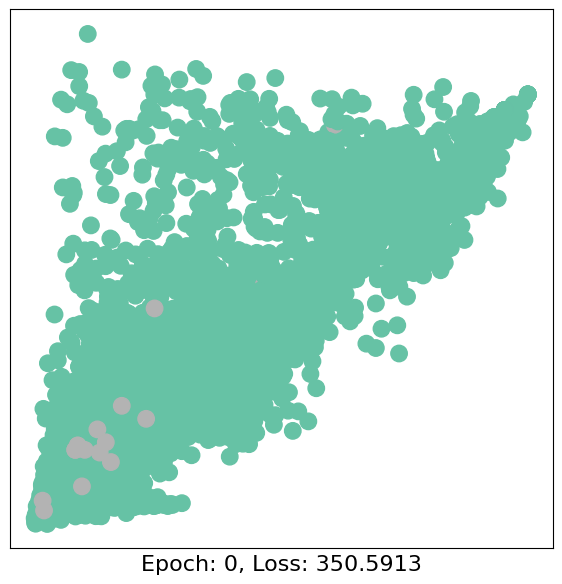

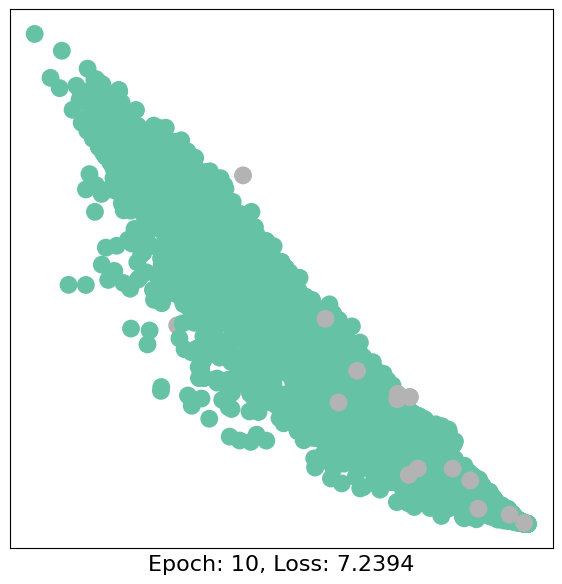

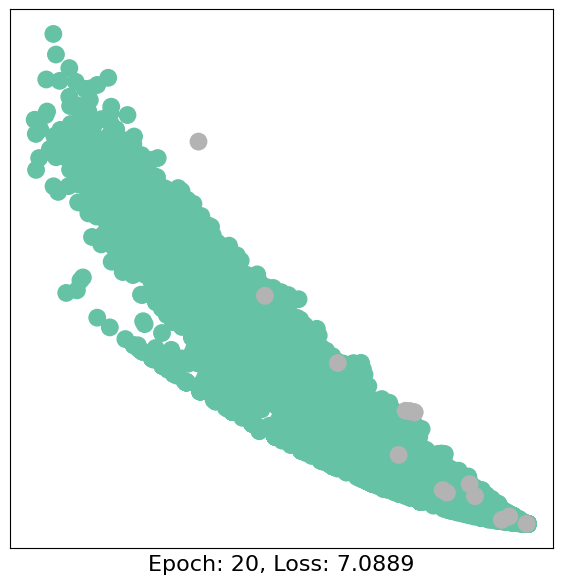

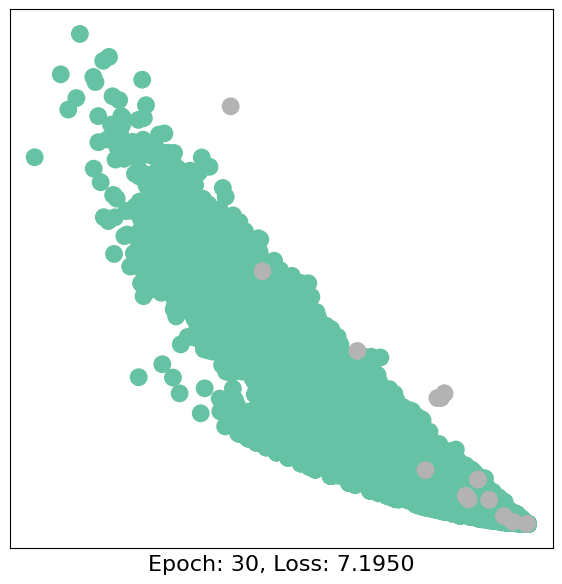

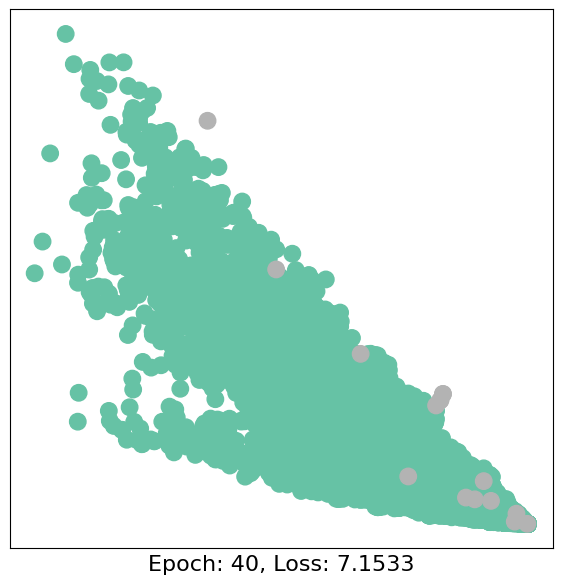

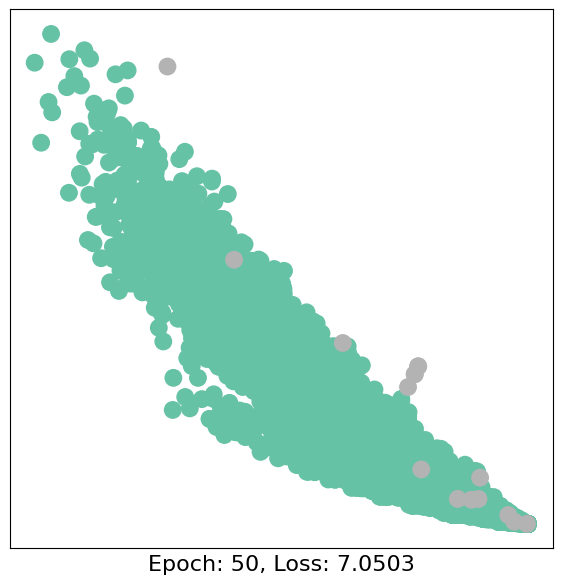

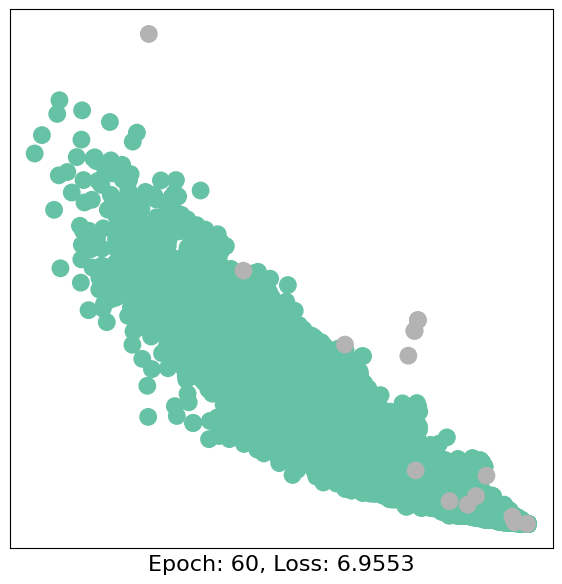

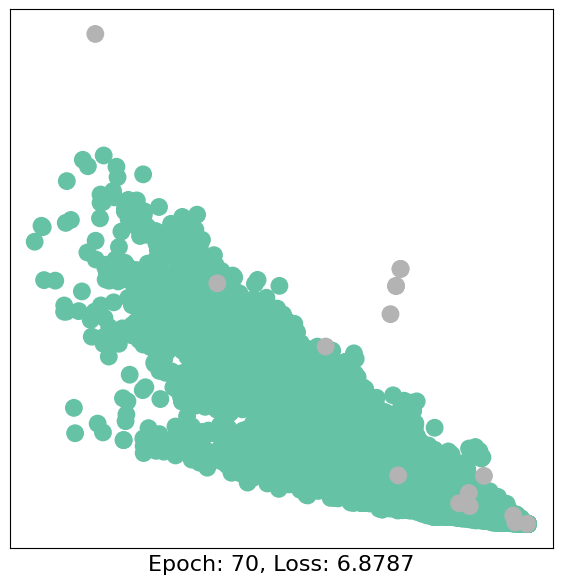

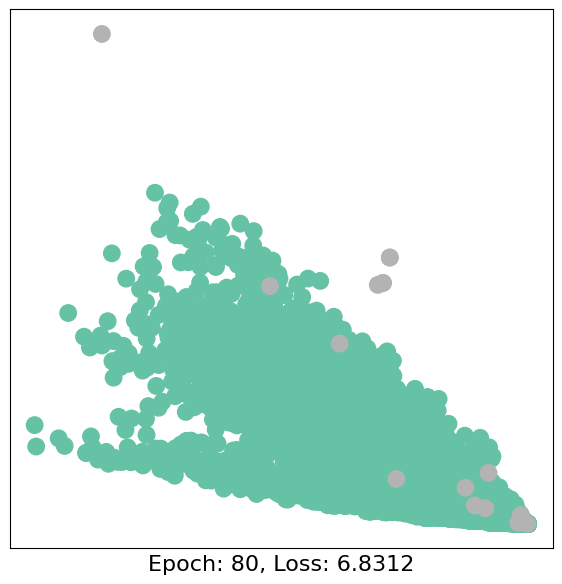

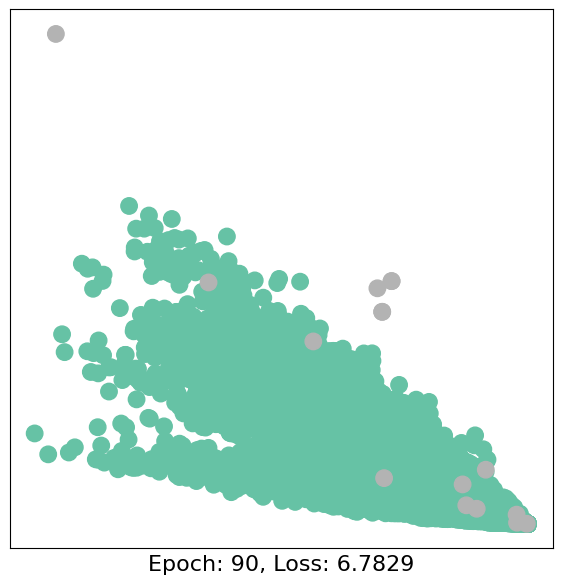

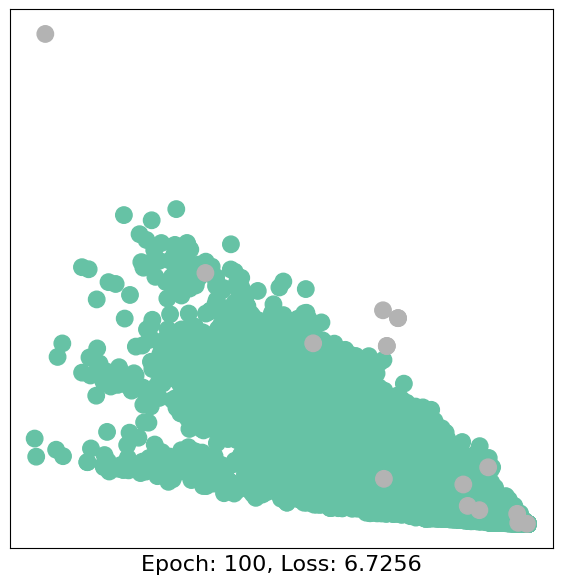

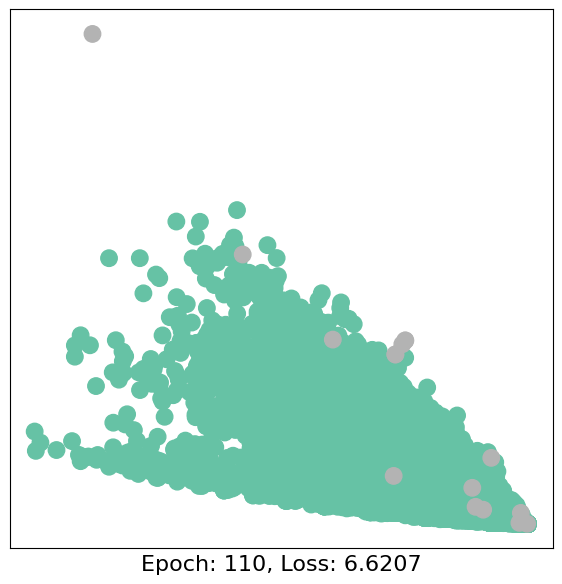

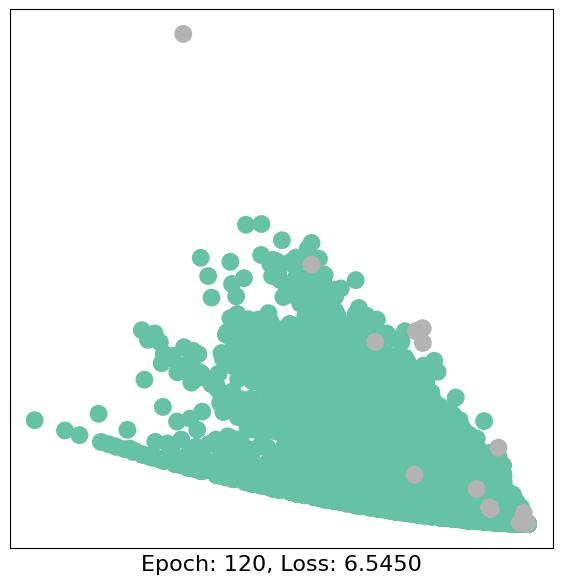

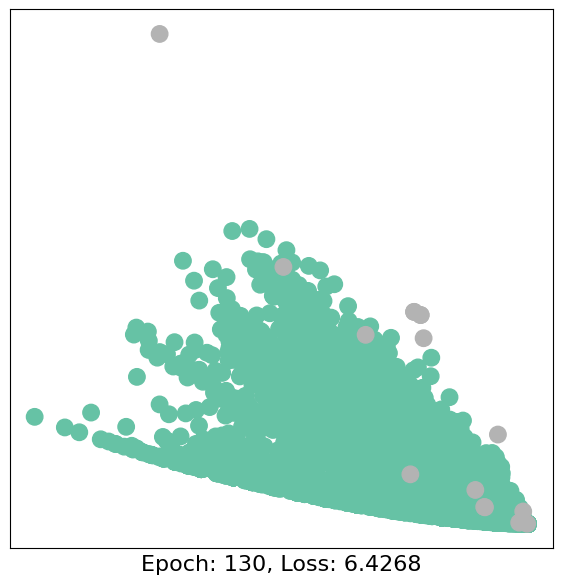

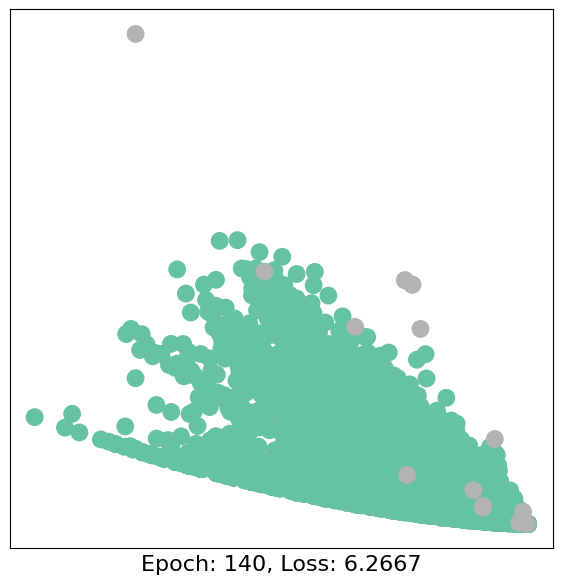

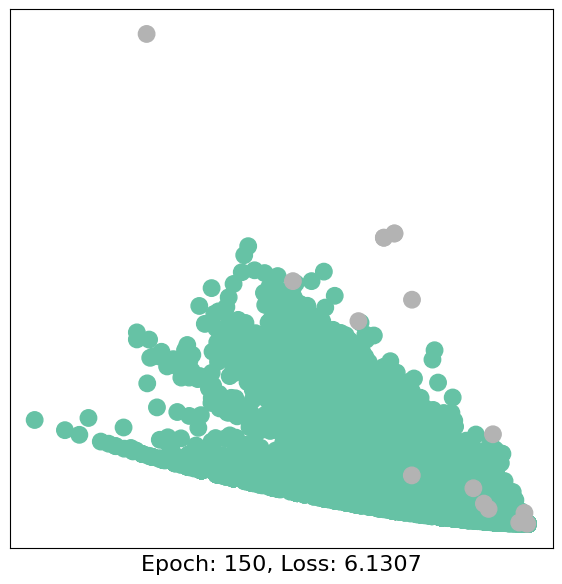

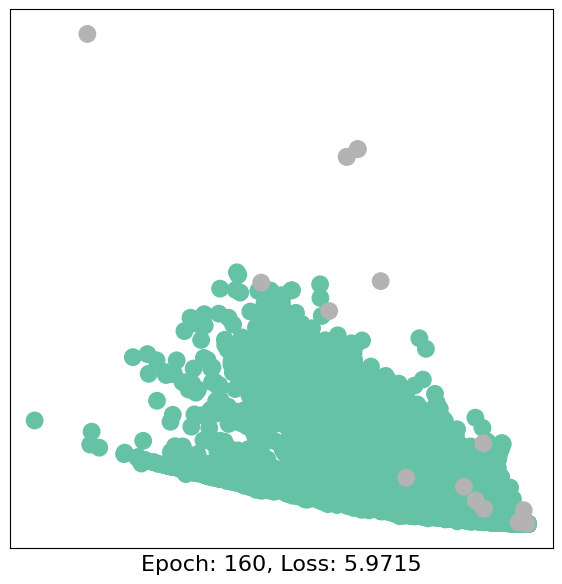

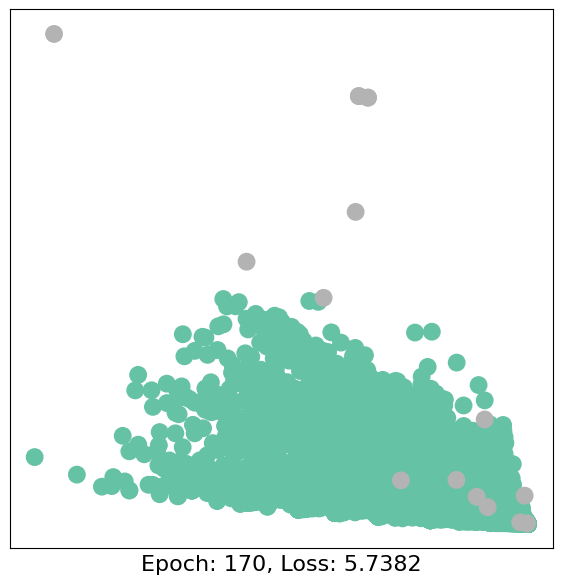

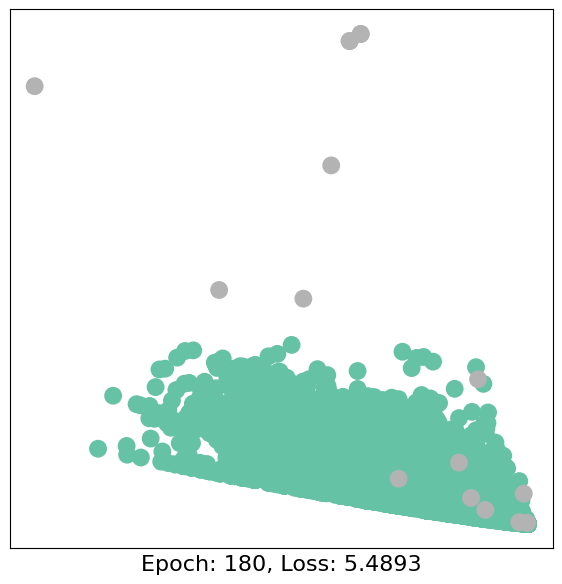

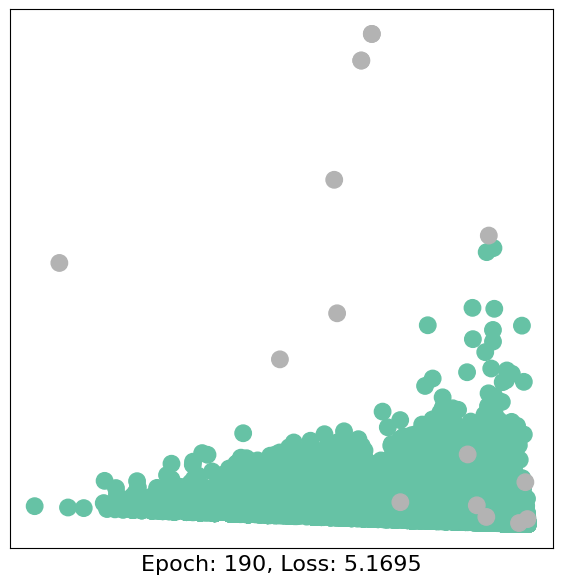

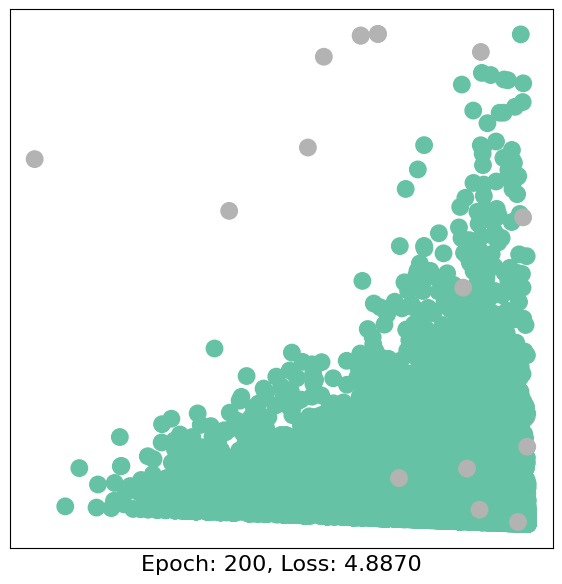

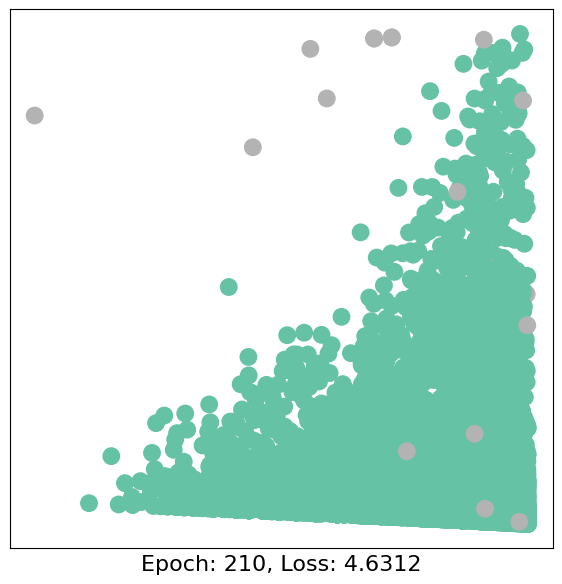

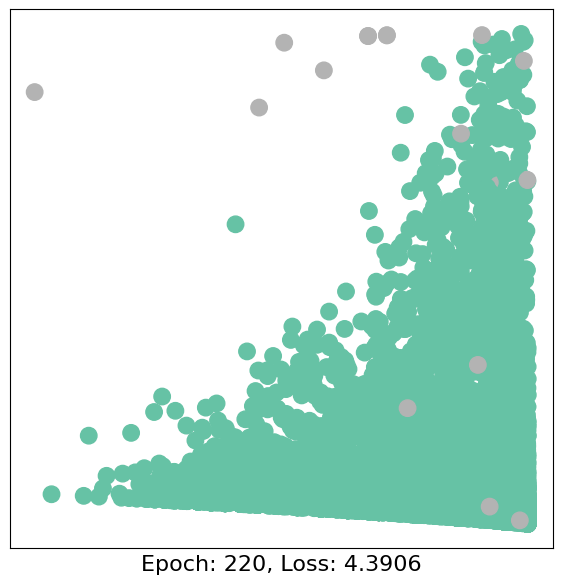

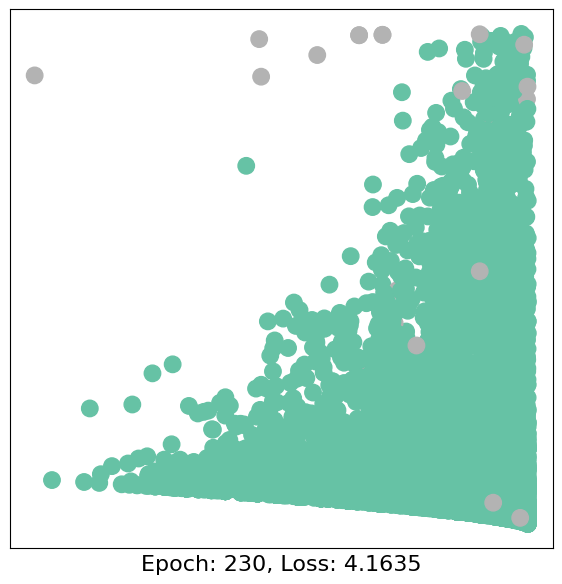

0.13793103448275862 234 tensor(4.0784, grad_fn=<BinaryCrossEntropyBackward0>)
0.25806451612903225 236 tensor(4.0374, grad_fn=<BinaryCrossEntropyBackward0>)


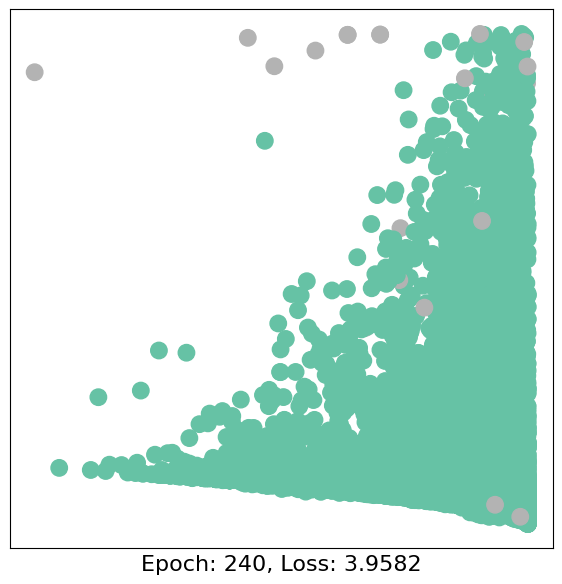

0.3125 242 tensor(3.9197, grad_fn=<BinaryCrossEntropyBackward0>)
0.3636363636363636 243 tensor(3.9006, grad_fn=<BinaryCrossEntropyBackward0>)


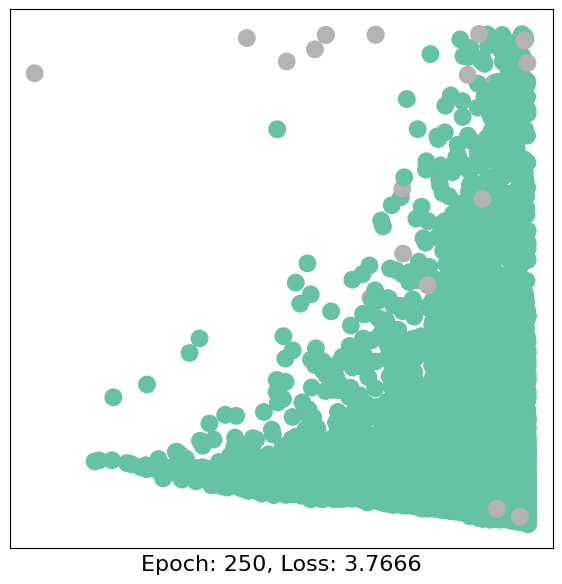

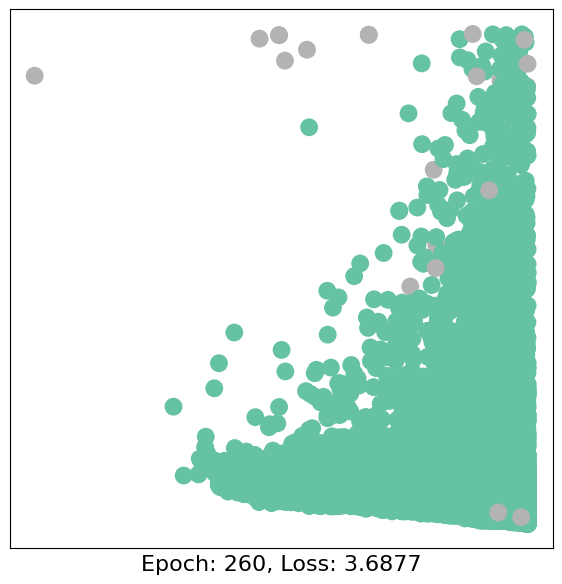

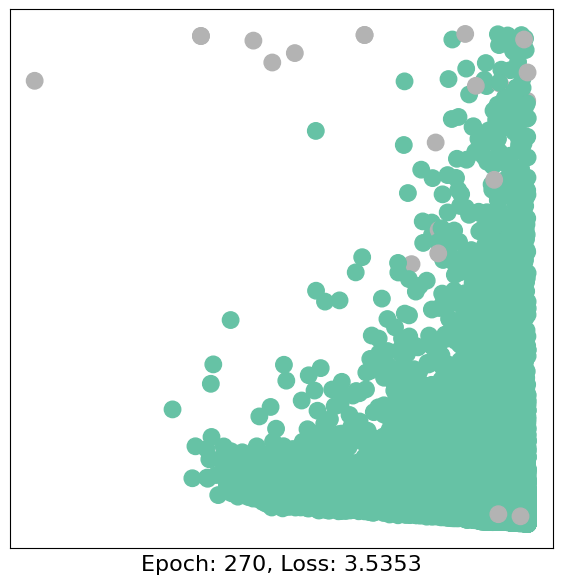

0.4117647058823529 271 tensor(3.5214, grad_fn=<BinaryCrossEntropyBackward0>)


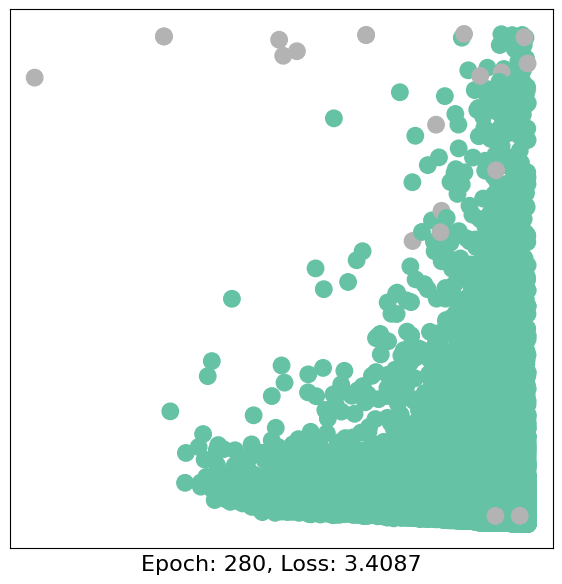

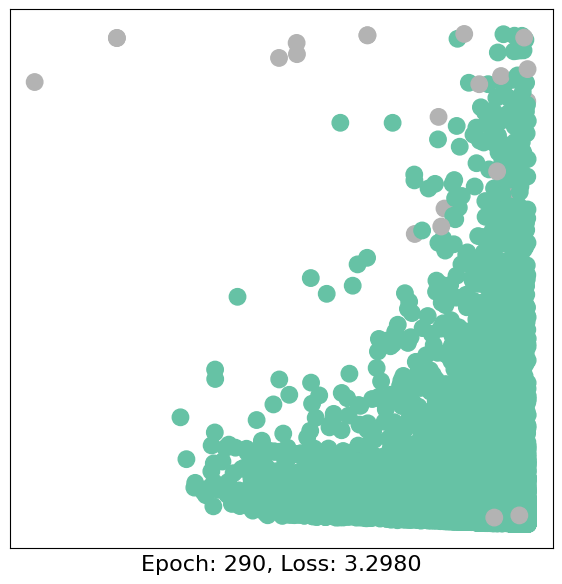

0.45714285714285713 295 tensor(3.2460, grad_fn=<BinaryCrossEntropyBackward0>)


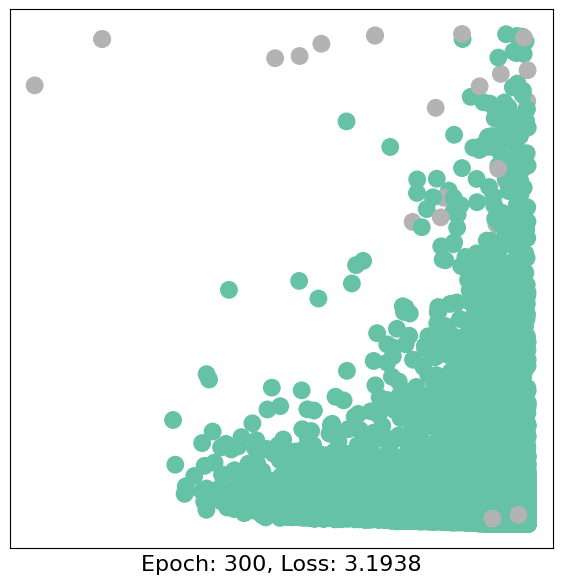

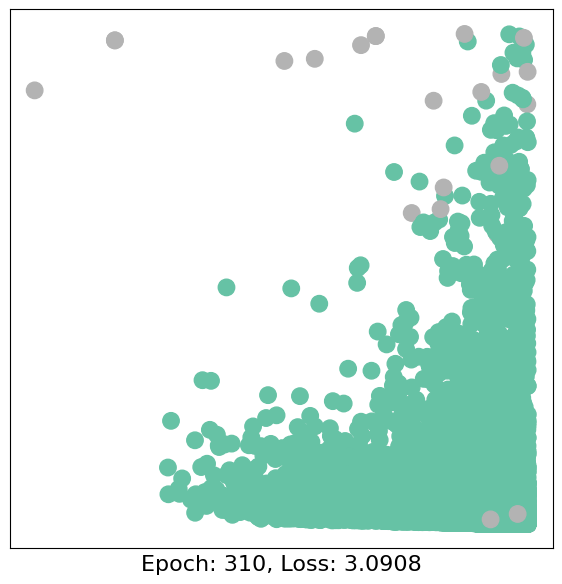

0.5 312 tensor(3.0706, grad_fn=<BinaryCrossEntropyBackward0>)
0.5405405405405406 318 tensor(3.0085, grad_fn=<BinaryCrossEntropyBackward0>)


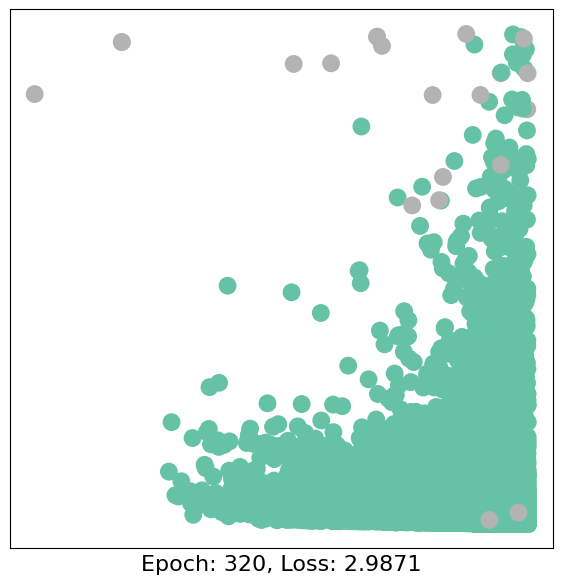

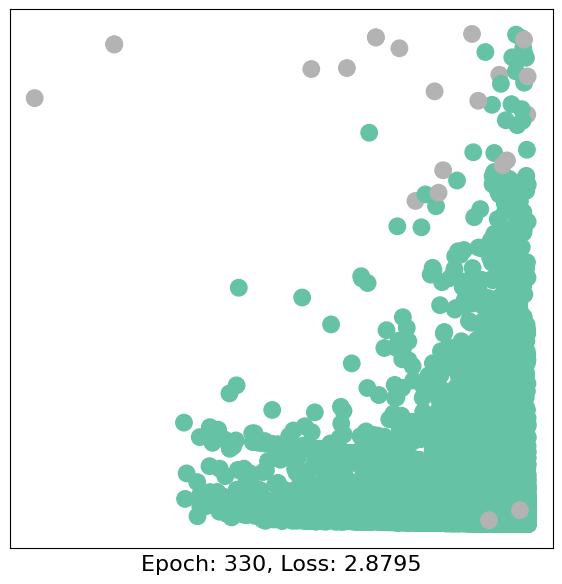

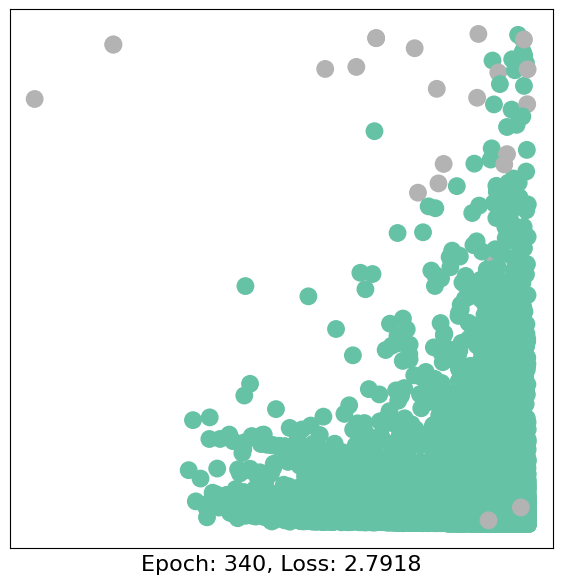

0.6 346 tensor(2.7226, grad_fn=<BinaryCrossEntropyBackward0>)


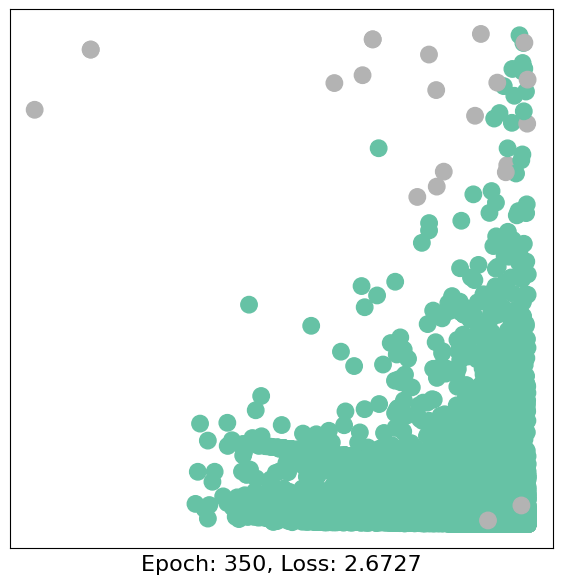

0.6341463414634146 358 tensor(2.5904, grad_fn=<BinaryCrossEntropyBackward0>)


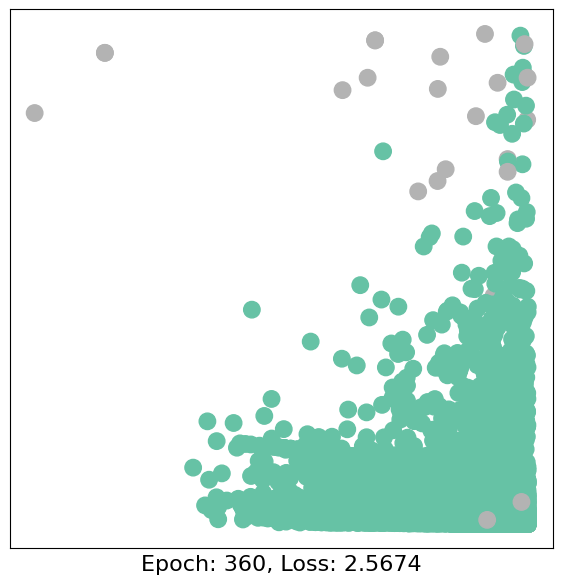

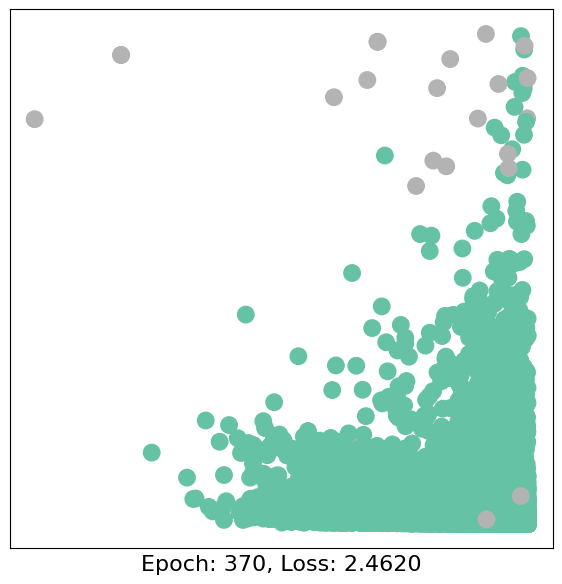

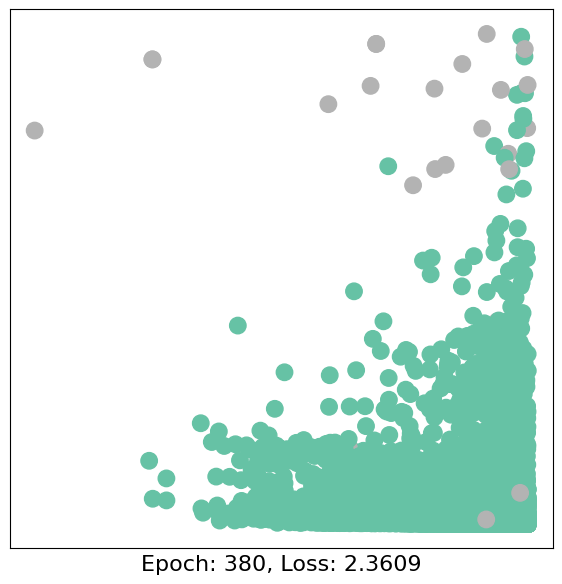

0.6976744186046512 387 tensor(2.2938, grad_fn=<BinaryCrossEntropyBackward0>)
0.7142857142857143 390 tensor(2.2650, grad_fn=<BinaryCrossEntropyBackward0>)


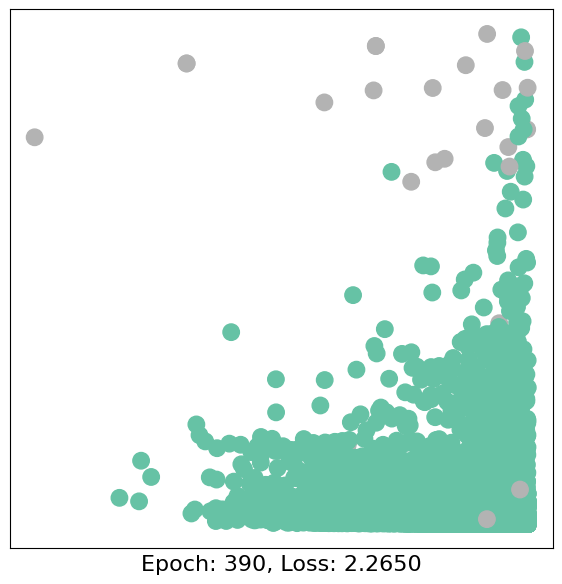

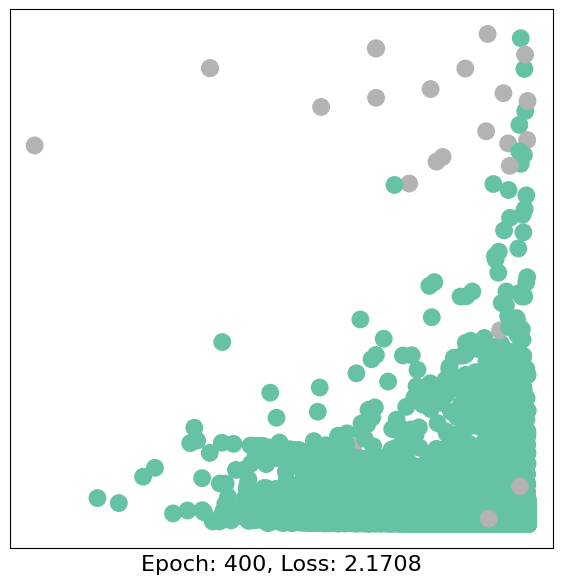

0.7441860465116279 401 tensor(2.1613, grad_fn=<BinaryCrossEntropyBackward0>)
0.7727272727272727 403 tensor(2.1423, grad_fn=<BinaryCrossEntropyBackward0>)
0.8 408 tensor(2.0948, grad_fn=<BinaryCrossEntropyBackward0>)
0.8260869565217391 410 tensor(2.0764, grad_fn=<BinaryCrossEntropyBackward0>)


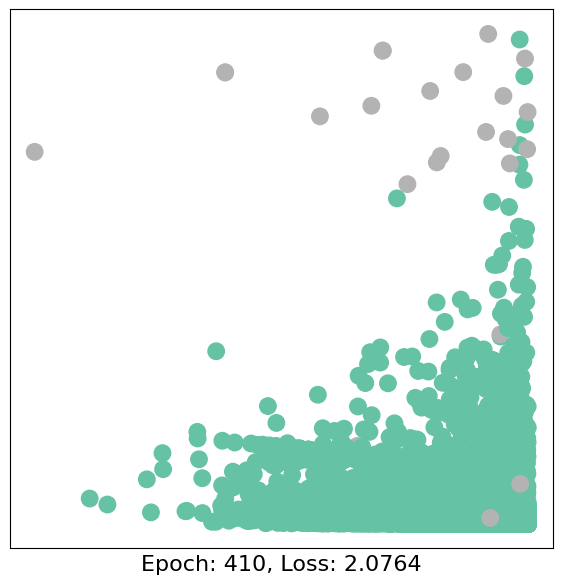

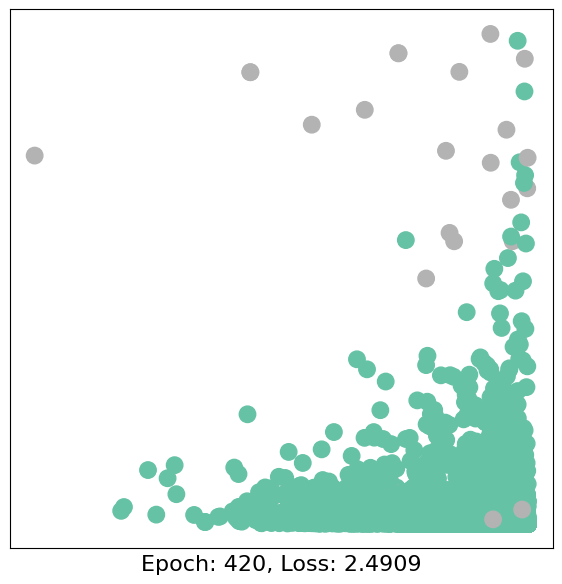

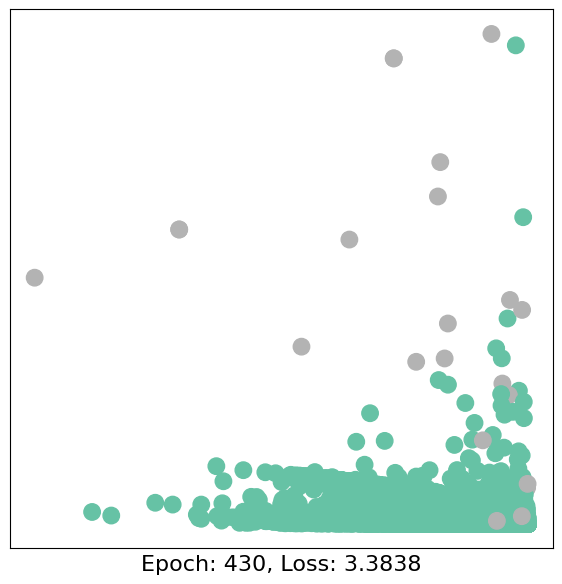

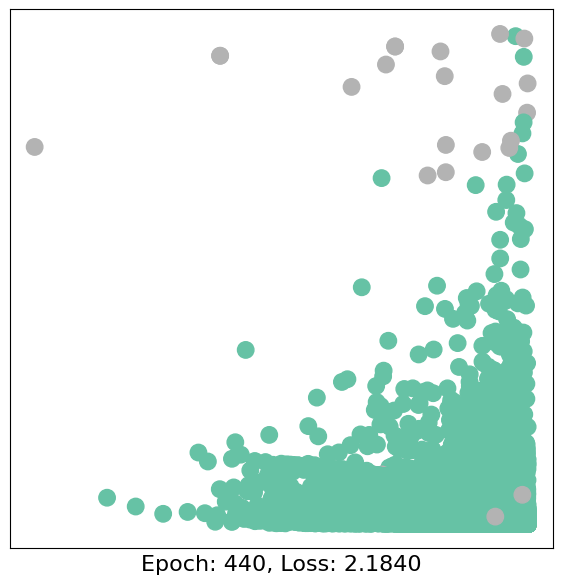

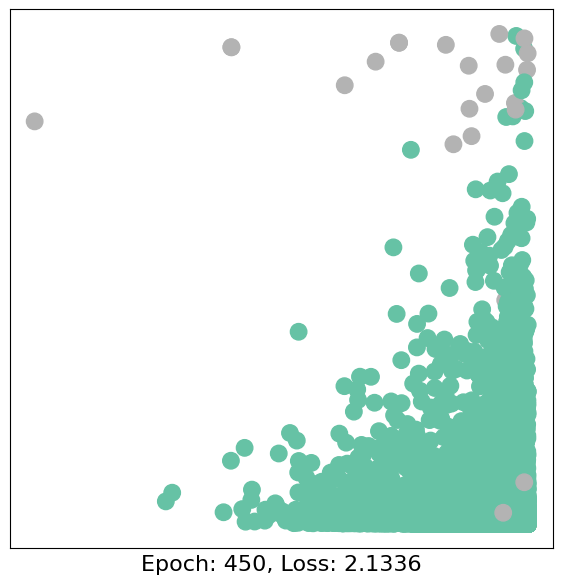

0.851063829787234 458 tensor(2.0119, grad_fn=<BinaryCrossEntropyBackward0>)


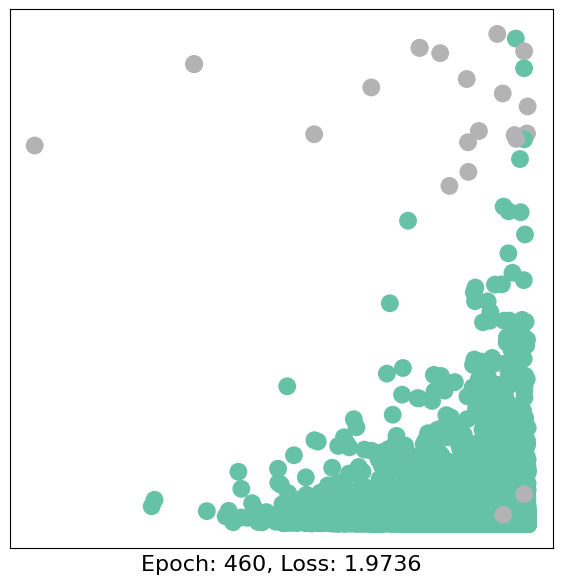

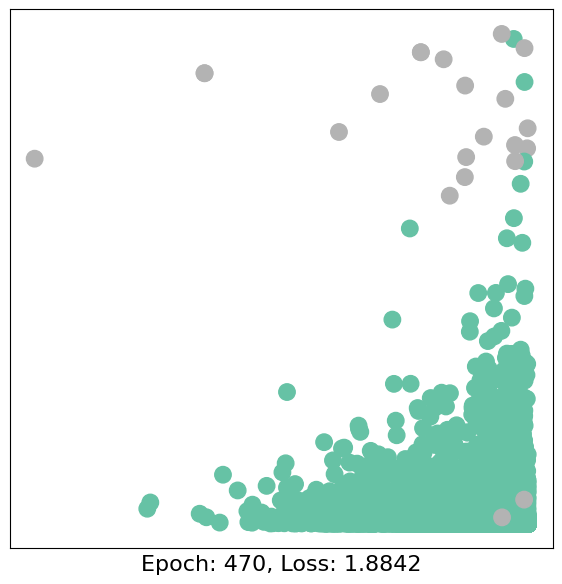

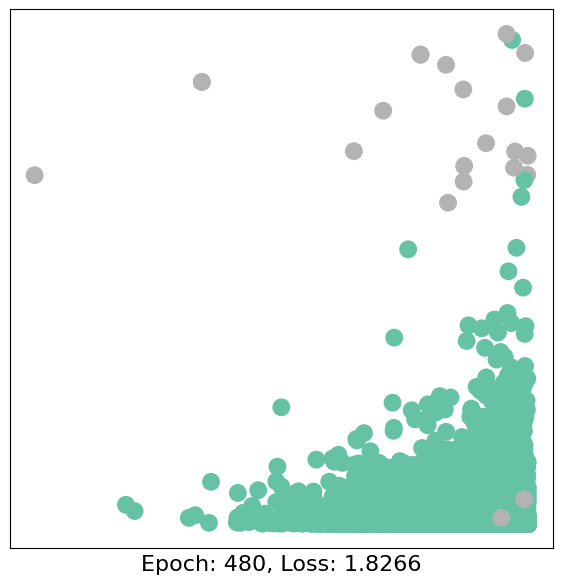

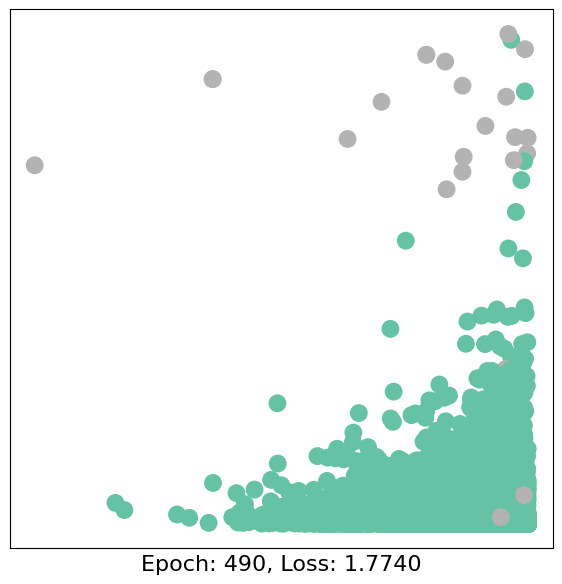

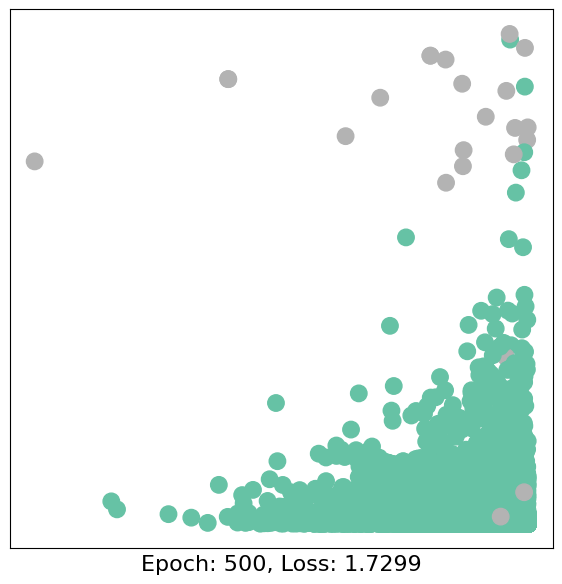

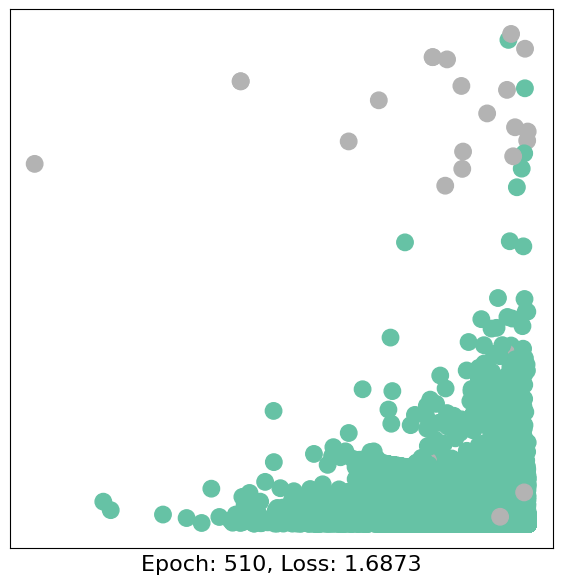

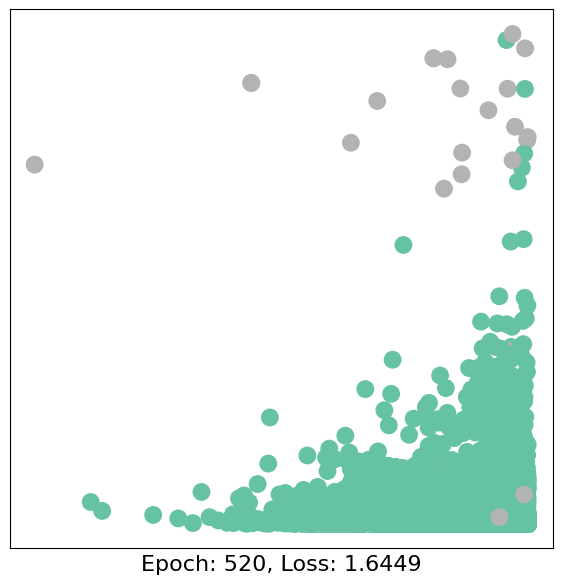

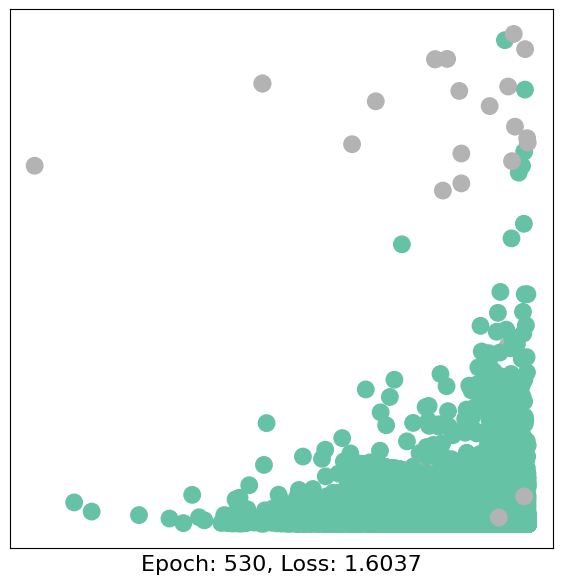

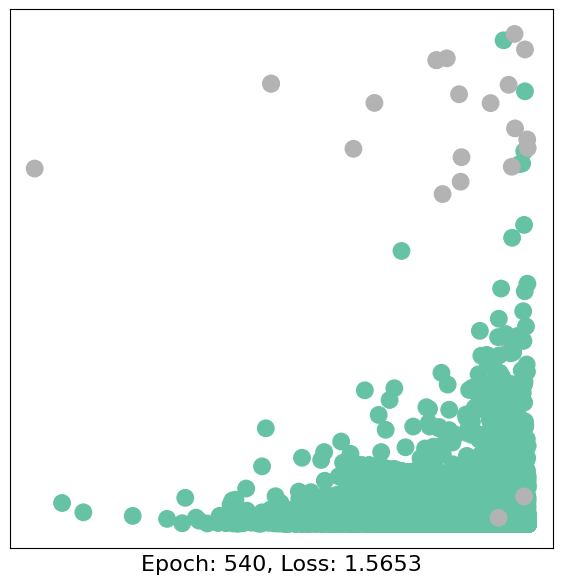

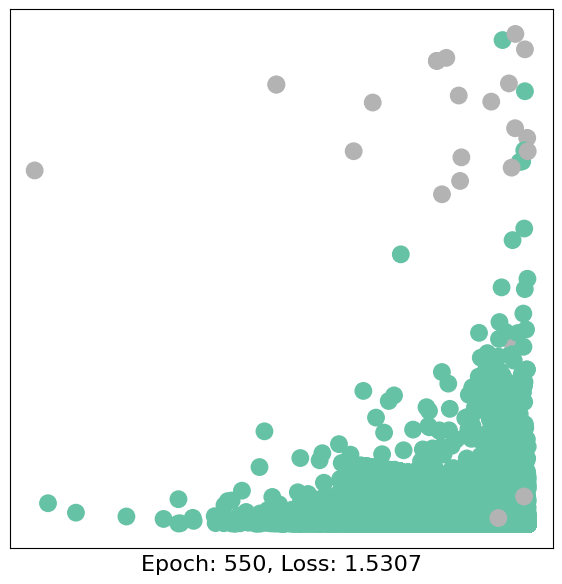

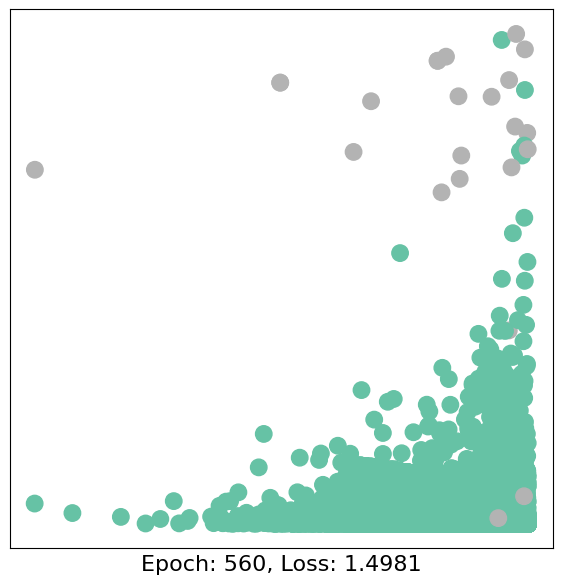

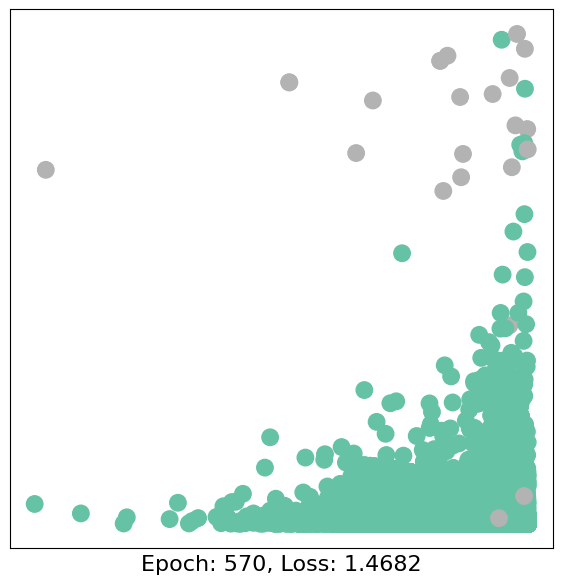

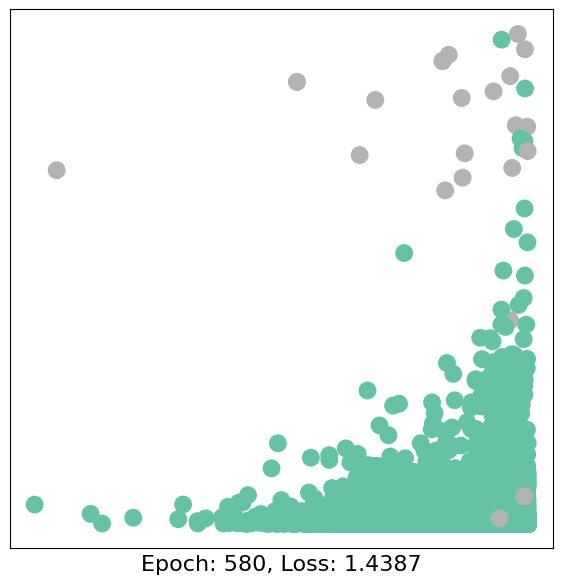

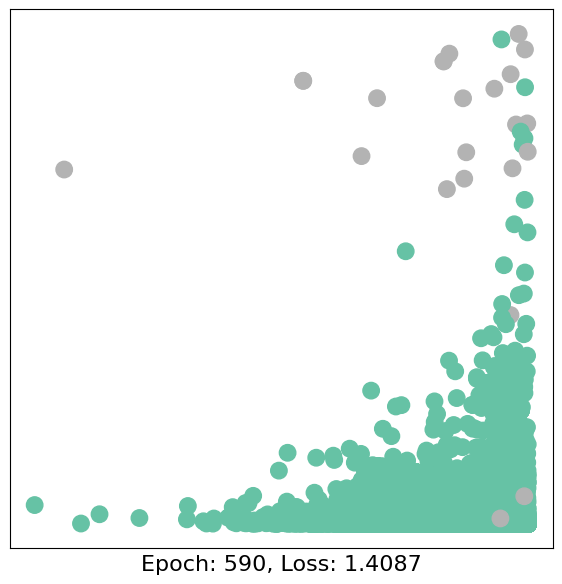

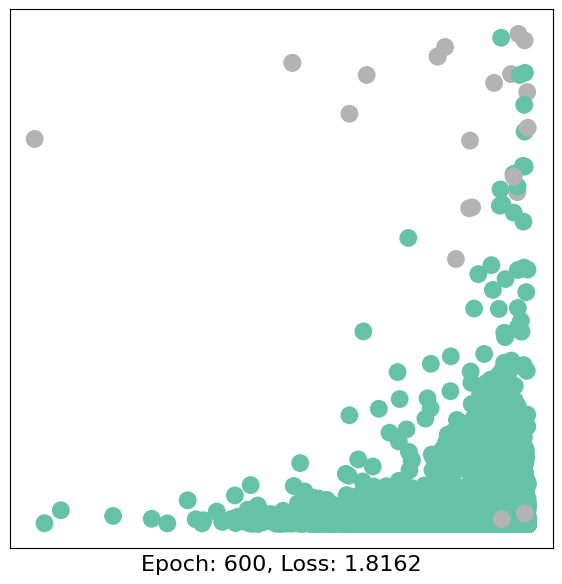

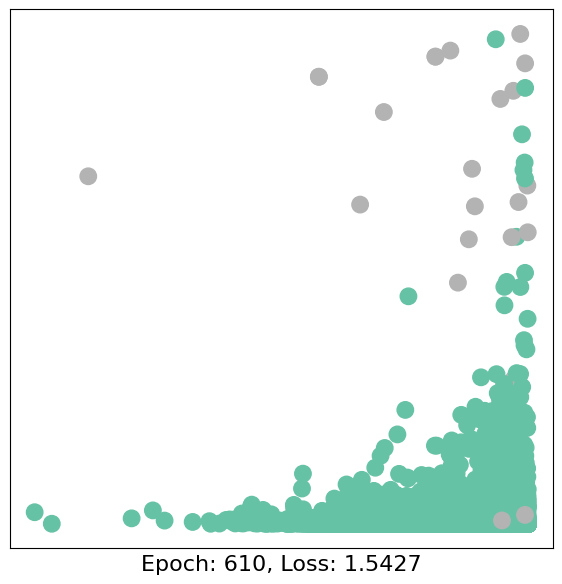

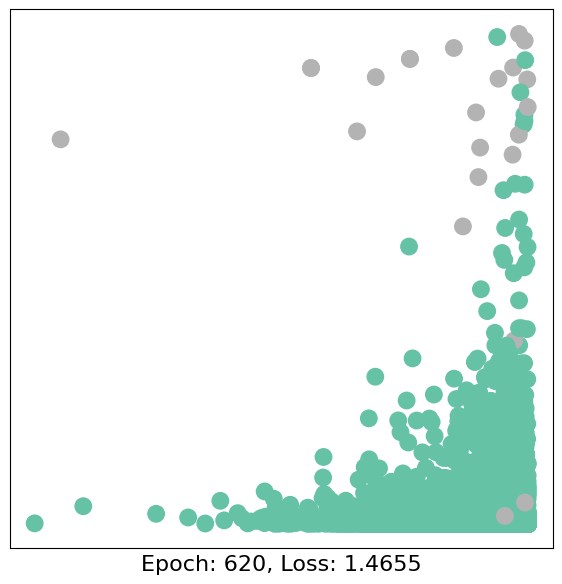

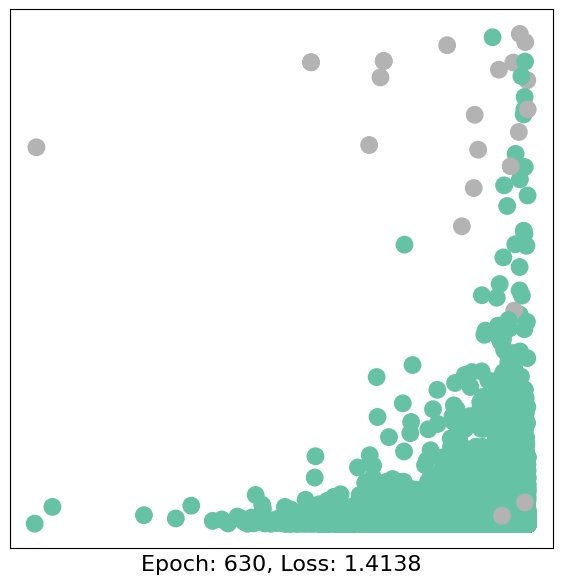

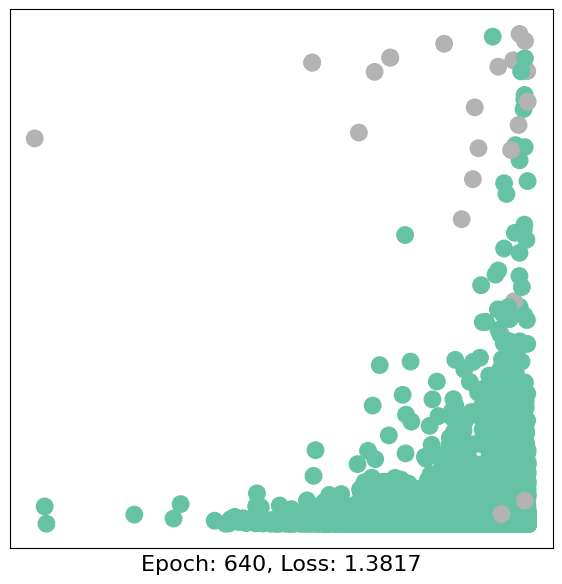

In [125]:
# Count class frequencies
class_weights = T.tensor(np.unique(data.y.numpy(), return_counts=True)[1][1] / np.unique(data.y.numpy(), return_counts=True)[1][2])

best_loss = 1000
best_f1_score = 0

# Define Model
model = GNNWithEdgeAttributes(input_dim=input_dim, edge_attr_dim=edge_attr_dim,
                              hidden_dim=hidden_dim, output_dim=output_dim)
criterion = torch.nn.BCELoss(weight=class_weights)  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

transformed_node_mask = list(node_mask.numpy()) + [False] * data.edge_attr.shape[0] 
transformed_node_mask = T.tensor(transformed_node_mask, dtype=T.bool)

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data)  # Perform a single forward pass.
    # print(out[transformed_node_mask])
    loss = criterion(out[transformed_node_mask].squeeze(), data.y[data.node_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    preds = torch.where(out[transformed_node_mask].squeeze() >= 0.5, 1, 0)
    harmonized_score = f1_score(data.y[data.node_mask].detach().numpy(), preds)
    # harmonized_score = f1_score(data.y[data.node_mask].detach().numpy(), out[transformed_node_mask].squeeze().detach().numpy())

    return loss, h, harmonized_score

for epoch in range(650):
    loss, h, harmonized_score = train(data)

    if harmonized_score > best_f1_score:
        print(harmonized_score, epoch, loss)
        best_f1_score = harmonized_score

        #Save model
        torch.save(model.state_dict(), 'PyG_best_model_ground_truth_task_3.pth')

    if epoch % 10 == 0:
        visualize_embedding(h[transformed_node_mask], color=data.y[data.node_mask], epoch=epoch, loss=loss)
        time.sleep(0.3)

## Load Best Model and Make Predictions

Now that the GNN has trained, we can load it and make predictions across the entire network.

In [32]:
# Load Model
model = GNNWithEdgeAttributes(input_dim=input_dim, edge_attr_dim=edge_attr_dim,
                              hidden_dim=hidden_dim, output_dim=output_dim)
model.load_state_dict(torch.load('PyG_best_model_ground_truth_task_3.pth'))
model.eval()

# Make predictions on entire dataset
output = model(data)

# Store Positive predictions
predicted_labels = (output[0][:300008] > 0.5).int()
predicted_labels = predicted_labels.numpy().flatten()

print('The total number of predictived postiive labels is', np.sum(predicted_labels))

# Store positive label indices and associated node id's
positive_indices = np.argwhere(predicted_labels.flatten() ==1).flatten()
positive_nodes = df_node.iloc[positive_indices].index

The total number of predictived postiive labels is 5466


We can see that there is likely a very high rate of false-positives with this prediction method, as we don't expect there to be 5454 traffickers in the network. But with a little bit of help using some other partitioning and graph adjustment methods, we can focus the area on which we wish to predict.

**A prediction of 5466 nodes represents 1.8% of total network size, which is very reassuring**

# Suspicious Pathways

To help refine the predictions made by the GNN, we can use methods to reduce the 5466 predicted nodes to a smaller more confidence shortlist.

According to the research our team has done, we have noticed that many networks have smaller-order cliques within them. We can filter down the list of predicted suspicious nodes by seeing which ones form cliques.

### Clique Detection on Predicted Suspicious Nodes

We can use the suspicious nodes predicted by our GNN to find which ones form cliques together.

We can also check to see which nodes have the highest betweeness centrality measures.

This will help reduce the total number of nodes predicted to a more reasonable number.

#### Generate Subgraph of only suspcicious nodes

In [33]:
# Select Positive Nodes
predicted_labels = (output[0][:300008] > 0.5).int()
positive_nodes = torch.nonzero(predicted_labels.squeeze() == 1, as_tuple = False)

# Update the node features in the PyG Data object with the node indices 
data_nodes = data.x
data_nodes = data_nodes.numpy()
data_nodes[:,0] = df_node.index

data.x = T.tensor(data_nodes, dtype=T.float)

# Create a new graph containing only the positive nodes

# select positive nodes
positive_nodes = data.x[positive_nodes].long()
# select positive edges and edge attributes
positive_edge_index, positive_edge_attributes = torch_g.utils.subgraph(positive_nodes, data.edge_index, data.edge_attr)  # Filter edges accordingly

# Create a new PyG Data object with only positive nodes and edges
data_positive = Data(x = positive_nodes.squeeze(), edge_index = positive_edge_index, edge_attr = positive_edge_attributes)

#### Solve Clique Problem & Solve for Betweeness Centrality

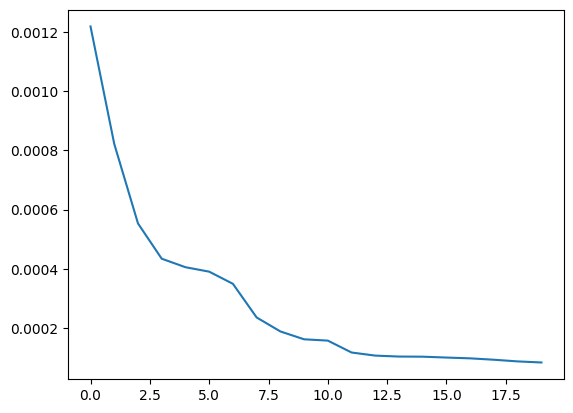

In [37]:
# Extract node indices and edge indices from the PyG Data object
node_indices = data_positive.x[:, 0].tolist() 
edge_indices = data_positive.edge_index.t().tolist()
edge_attributes = data_positive.edge_attr.tolist()

# Create a NetworkX graph and add nodes
subgraph_nx = nx.Graph()
subgraph_nx.add_nodes_from(node_indices)
subgraph_nx.add_edges_from(edge_indices)

# # Add edges to the NetworkX graph with edge attributes
# for edge_index, edge_attr in zip(edge_indices,edge_attributes):
#     subgraph_nx.add_edge(edge_index[0], edge_index[1], **{'weight': edge_attr})

# Get positive cliques
positive_cliques = []
for clique in nx.enumerate_all_cliques(subgraph_nx):
    if len(clique) > 1:
        positive_cliques.append(clique)

# Flatten the list
positive_nodes = list(set([x for x_clique in positive_cliques for x in x_clique]))


# Create NetworkX Graph
node_indices = data.x[:, 0].tolist() 
edge_indices = data.edge_index.t().tolist()
edge_attributes = data.edge_attr.tolist()

# Create a NetworkX graph and add nodes
G = nx.Graph()
G.add_nodes_from(node_indices)
G.add_edges_from(edge_indices)

# Check for betweenness centrality of all identified nodes
betweenness_centralities = nx.betweenness_centrality(G,10)

# Get the betweenness centrality for each node
centrality_scores=[]
for node, centrality in betweenness_centralities.items():
    if node in positive_nodes:
        centrality_scores.append([node, centrality])

centrality_scores = np.array(centrality_scores)
centrality_scores = centrality_scores[centrality_scores[:, 1].argsort()[::-1]] # sort along centrality axis


plt.plot(range(len(centrality_scores[:20,0])), centrality_scores[:20,1])

central_positive_nodes = list(centrality_scores[:5,0])

We can see that there are only around 5 suspicious nodes that are in cliques and have a high betweenness centrality score.

## Path Detection between Suspicious Nodes

We can use shortest path techniques to connect these 5 suspicious nodes in the network.

These paths can give us an insight into how these nodes are connected.

In [38]:
# Create NetworkX Graph
node_indices = data.x[:, 0].tolist() 
edge_indices = data.edge_index.t().tolist()
edge_attributes = data.edge_attr.tolist()

# Create a undirected NetworkX graph and add nodes
G = nx.Graph()
G.add_nodes_from(node_indices)
G.add_edges_from(edge_indices)


trafficking_clique = []
trafficking_cliques = []

# Initialize a set to store all non-positive nodes
non_target_nodes = set(G.nodes()) - set(positive_nodes)

# Initialize a list to store all possible paths connecting the positive nodes through non-positive nodes
all_paths = []

# Iterate over all combinations of positive nodes
for source_node in central_positive_nodes:
    for target_node in tqdm(central_positive_nodes):
        if source_node != target_node:
            combined_paths = []
            # Find all simple paths between the source and target nodes
            paths = nx.all_shortest_paths(G, source=source_node, target=target_node)
            # Filter out paths that are empty
            valid_paths = [path for path in paths if len(path) > 1]
            # Combine all valid paths into one subgraph
            for path in valid_paths:
                combined_paths.extend(path)

            # Take set of combined paths
            combined_paths = list(set(combined_paths))
            all_paths.append(combined_paths)

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [39]:
print('Total number of suspicious pathways:',len(all_paths))

Total number of suspicious pathways: 20


#### Refine Pathways

We can further gain confidence in our networks if we filter paths for reasonable size of a IWT network.

In [41]:
filtered_paths = [path for path in all_paths if (len(path) >= 5) & (len(path) <= 15)]
print('Suspicious IWT Networks:',len(filtered_paths))

Suspicious IWT Networks: 14


We can further filter down the paths by seeing how many suspicious nodes lie in each pathway

In [42]:
suspicious_paths = []
for path in filtered_paths:
    count = 0
    for node in path:
        if node in positive_nodes:
            count+=1
    if count>= 3: # There are at least two suspicious nodes per pathway, so look for more than two
        suspicious_paths.append(path)
print('Suspicious IWT Networks:',len(suspicious_paths))

Suspicious IWT Networks: 2


### Graph Suspicious IWT Pathways

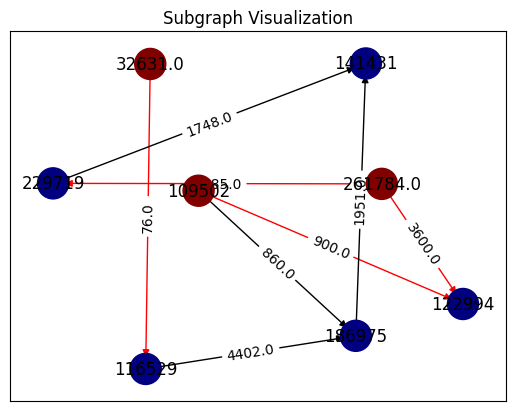

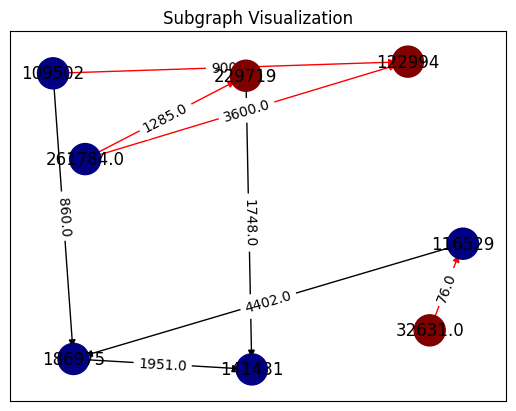

In [43]:
# Create Directed NetworkX Graph for Drawing purposes
node_indices = data.x[:, 0].tolist() 
edge_indices = data.edge_index.t().tolist()
edge_attributes = data.edge_attr.tolist()

# Create a directed NetworkX graph and add nodes
G = nx.DiGraph()
G.add_nodes_from(node_indices)
G.add_edges_from(edge_indices)

# Collect DataFrame Properties
nodes_list = []
suspicious_nodes_list = []
wire_amounts_list = []
countries_list = []
occupations_list = []
foreign_inbound_list = []
domestic_list = []
foreign_outbound_list = []
unknown_list = []
message_scores_list = []
names_list = []
ages_list = []
tenures_list = []

# Map node dictionary to kyc for node-lookup
df_kyc['node_id'] = df_kyc['cust_id'].map(node_dictionary)

# Map node dictionary to wire dataframe for node-lookup
df_wire['node_id_sender'] = df_wire['id sender'].map(node_dictionary)
df_wire['node_id_receiver'] = df_wire['id receiver'].map(node_dictionary)

for p in range(len(suspicious_paths)):    
    subgraph_nodes = suspicious_paths[p] 
    subgraph = G.subgraph(subgraph_nodes)

    # Reset lists & counts
    suspicious_node_count = 0
    foreign_inbound = 0
    domestic = 0
    foreign_outbound = 0
    unknown = 0
    nodes = []
    names = []
    ages = []
    tenures = []
    occupations = []
    countries = []


    # Color map
    color_map = {}

    # Identify suspicious nodes and store features
    for node in subgraph_nodes:

        # Store node
        nodes.append(node)

        # Look up name 
        name = df_kyc.loc[df_kyc['node_id']==node]['Name']
        if len(name) > 0:
            names.append(name)
        else:
            names.append(np.nan)
        
        # Look up age
        age = df_kyc.loc[df_kyc['node_id']==node]['Age']
        if len(age) > 0:
            ages.append(age)
        else:
            ages.append(np.nan)
        
        # Look up tenure
        tenure = df_kyc.loc[df_kyc['node_id']==node]['Tenure']
        if len(tenure) > 0:
            tenures.append(tenure)
        else:
            tenures.append(np.nan)

        # Look up occupation
        occupation = df_kyc.loc[df_kyc['node_id']==node]['Occupation']
        if len(occupation) >0:
            occupations.append(occupation)
        else:
            occupations.append(np.nan)

        # Look up Country
        country_sender = df_wire.loc[df_wire['node_id_sender']==node]['country sender']
        country_receiver = df_wire.loc[df_wire['node_id_receiver']==node]['country receiver']
        if len(country_sender) > 0:
            countries.append(country_sender)
        elif len(country_receiver) > 0:
            countries.append(country_receiver)
        else:
            countries.append(np.nan)


        # For suspicious nodes
        if node in positive_nodes:
            # color map
            color_map[node] = 1.0
            # update suspicious node count
            suspicious_node_count+=1

        # For non-suspicious nodes
        else:
            # color map
            color_map[node] = 0.25
    
    # Store lists
    nodes_list.append(nodes)
    names_list.append(names)
    ages_list.append(ages)
    tenures_list.append(tenures)
    occupations_list.append(occupations)
    countries_list.append(countries)
    suspicious_nodes_list.append(suspicious_node_count) 

    # Color in the rest of the nodes
    values = [color_map.get(node, 0.25) for node in subgraph_nodes]

    # Edges analysis

    # Edge colors
    red_edges = []
    black_edges = []
    wire_amounts = []
    message_scores = []
    #Analyze Edges
    for edge in subgraph.edges():
        # Look up wire amount
        wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['amount'].values[0]

        wire_amounts.append(wire_amount)

        # Look up message score

        message_score = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['key_word_score'].values[0]
        message_scores.append(message_score)

        # update transaction counds
        foreign_inbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['foreign_inbound'].values[0]
        foreign_outbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['foreign_outbound'].values[0]
        domestic += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['domestic'].values[0]
        unknown += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['unknown'].values[0]

        # Color red edge
        if (edge[0] in positive_nodes) or (edge[1] in positive_nodes):
            red_edges.append(edge)
        # Color black edge
        else:
            black_edges.append(edge)

    # Edge labels
    edge_labels=dict([(edge, wire_amounts[i]) for i,edge in enumerate(subgraph.edges())])

    # Store counts
    foreign_inbound_list.append(foreign_inbound)
    domestic_list.append(domestic)
    foreign_outbound_list.append(foreign_outbound)
    unknown_list.append(unknown)
    wire_amounts_list.append(wire_amounts)
    message_scores_list.append(message_scores)


    # Draw the subgraph
    pos = nx.spring_layout(subgraph,k=5/np.sqrt(subgraph.order()))  # Layout for node positioning
    nx.draw_networkx_nodes(subgraph, pos, cmap = plt.get_cmap('jet'), node_color = values, node_size=500)
    nx.draw_networkx_labels(subgraph, pos)
    nx.draw_networkx_edges(subgraph, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(subgraph, pos, edgelist=black_edges, edge_color = 'black', arrows=True)
    nx.draw_networkx_edge_labels(subgraph,pos,edge_labels=edge_labels)
    plt.title("Subgraph Visualization")
    plt.show()

# Build DataFrame
df_suspicious_pathways = pd.DataFrame({'nodes':nodes_list, 'names': names_list, 'wire amounts': wire_amounts_list, 'countries': countries_list,
                                       'message_scores': message_scores_list, 'foreign_inbound_trxs': foreign_inbound_list, 
                                       'domestic_trxs': domestic_list, 'foreign_outbound_trxs':foreign_outbound_list, 
                                       'unknown_trxs': unknown_list,'ages': ages_list, 'tenures': tenures_list})

### Analyze Results

The DataFrame below shows the properties and characteristics of all the identified trafficking networks using the GCN.

In [44]:
df_suspicious_pathways

nodes  \
0  [229719, 116529, 122994, 32631.0, 261784.0, 14...   
1  [32631.0, 116529, 122994, 109502, 141431, 2617...   

                                               names  \
0  [[JENNIFER BENDER MD], [JENNIFER GREEN], [KRIS...   
1  [[ANA CLEMENTE SALDIVAR], [JENNIFER GREEN], [K...   

                                        wire amounts  \
0  [4402.0, 900.0, 860.0, 76.0, 1285.0, 3600.0, 1...   
1  [76.0, 4402.0, 1285.0, 3600.0, 1748.0, 900.0, ...   

                                           countries  \
0  [nan, [CA], [CA, CA, CA], nan, [CA, CA], [CA],...   
1  [nan, [CA], [CA, CA, CA], [CA], [CA], [CA, CA]...   

                             message_scores  foreign_inbound_trxs  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                     0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                     0   

   domestic_trxs  foreign_outbound_trxs  unknown_trxs  \
0              1                      0             7   
1              1                      0             7   

                                                ages  \
0  [[29.0], [37.0], [41.0], [36.0], nan, nan, nan...   
1  [[36.0], [37.0], [41.0], nan, nan, nan, [29.0]...   

                                             tenures  
0  [[11.0], [12.0], [0.0], [0.0], nan, nan, nan, ...  
1  [[0.0], [12.0], [0.0], nan, nan, nan, [11.0], ...

#### Analysis

The two networks are indeed suspicious. There are a lot of 'Unknown' Transactions (i.e. sending/receiving destination unknown). However, the wire amount do not seem to be very abnormal, and the list of known countries are all Canadian.

We can save the names & nodes associated with these networks and check if they correspond with our later results.

In [45]:
# Store nodes

suspicious_pathways_nodes = []

for nodes in df_suspicious_pathways.nodes:
    suspicious_pathways_nodes.extend(nodes)

# Community Detection

A more robust way to detect trafficking networks is to look for communities using modularity algorithms like Louvain Modularity. As these communities represent section in the graph are are functionaly related relative to the rest of the graph.

We would expect IWT networks to confirm to some type of modular community.

**Problem with Modularity Partitioning: It is computationally expensive**

We cannot simply run Louvain partitioning on the whole network, it is too computationaly expensive. Especially because we will likely need to perform several iterations of it to get communities of a reasonable size.

### Generate Neighbourhood Graph


**Solution** We can use the 27 positively labelled nodes that we used for GNN training, and create a 'neighbourhood graph' around those 26 nodes, going 5 neighbours out from each of them.

This will create a subset of the graph in which we can run partitioning algorithms. 5-Levels out is very extensive, and will capture a very large portion of the graph, while also eliminating regions of the graph that are not likely to to contain IWT networks.

In [47]:
# Create NetworkX Graph
node_indices = data.x[:, 0].tolist() 
edge_indices = data.edge_index.t().tolist()
edge_attributes = data.edge_attr.tolist()

# Create a undirected NetworkX graph and add nodes
G = nx.Graph()
G.add_nodes_from(node_indices)
G.add_edges_from(edge_indices)

# Get node id's for ground truth trafficker ids
positive_nodes_ground_truth = []
for id in trafficker_ids:
    node_id = node_dictionary[id]
    positive_nodes_ground_truth.append(node_id)



# Generate neighbourhood graph with only suspicious nodes
def generate_neighborhood_graph(graph, suspicious_nodes, max_degree):
    # Initialize a set to store all nodes in the neighborhood
    neighborhood_nodes = set()

    # Perform BFS traversal from each suspicious node
    for suspicious_node in tqdm(suspicious_nodes):
        print(suspicious_node)
        # Initialize a queue for BFS traversal
        queue = [(suspicious_node, 0)]  
        
        # Perform BFS traversal
        while queue:
            current_node, degree = queue.pop(0)
            
            # Add current node to neighborhood if within specified degree
            if degree <= max_degree:
                neighborhood_nodes.add(current_node)
                
                # Enqueue neighbors for further traversal
                neighbors = graph.neighbors(current_node)
                for neighbor in neighbors:
                    queue.append((neighbor, degree + 1))
    
    # Generate a subgraph containing only the neighborhood nodes
    neighborhood_graph = graph.subgraph(neighborhood_nodes)
    
    return neighborhood_graph

# Get neighbourhood graph for neighbour degree 5
max_degree = 5  
neighborhood_graph = generate_neighborhood_graph(G, positive_nodes_ground_truth, max_degree)

  0%|          | 0/27 [00:00<?, ?it/s]

173834


  4%|▎         | 1/27 [00:06<02:38,  6.09s/it]

133651


  7%|▋         | 2/27 [00:06<01:13,  2.95s/it]

211784


 11%|█         | 3/27 [03:13<34:47, 86.99s/it]

86155


 15%|█▍        | 4/27 [04:18<29:56, 78.12s/it]

207034


 19%|█▊        | 5/27 [04:21<18:41, 50.96s/it]

13344


 22%|██▏       | 6/27 [05:05<17:00, 48.62s/it]

290699


 26%|██▌       | 7/27 [05:07<11:07, 33.37s/it]

178534


 30%|██▉       | 8/27 [05:38<10:21, 32.72s/it]

1350


 33%|███▎      | 9/27 [59:27<5:09:35, 1031.99s/it]

94726


 37%|███▋      | 10/27 [1:16:31<4:51:40, 1029.44s/it]

81650


 41%|████      | 11/27 [1:16:34<3:10:42, 715.15s/it] 

119980
16385


 48%|████▊     | 13/27 [1:37:06<2:36:06, 669.07s/it]

47489


 52%|█████▏    | 14/27 [1:53:47<2:42:54, 751.91s/it]

255760


 56%|█████▌    | 15/27 [1:54:08<1:51:55, 559.63s/it]

82778


 59%|█████▉    | 16/27 [1:54:11<1:14:42, 407.51s/it]

184247


 63%|██████▎   | 17/27 [1:54:47<50:33, 303.38s/it]  

193046


 67%|██████▋   | 18/27 [2:09:52<1:11:20, 475.58s/it]

119403
49721


 74%|███████▍  | 20/27 [2:26:11<56:12, 481.79s/it]  

116443


 78%|███████▊  | 21/27 [2:26:15<36:33, 365.57s/it]

26262


 81%|████████▏ | 22/27 [2:43:10<44:24, 532.99s/it]

80672


 85%|████████▌ | 23/27 [2:43:50<26:41, 400.45s/it]

75865


 89%|████████▉ | 24/27 [2:46:31<16:41, 333.85s/it]

127343
200503


100%|██████████| 27/27 [2:56:35<00:00, 392.42s/it]

19954


Show some summary statistice about the new neighbourhood graph

In [50]:
# Gather some statistics about the subgraph
print(f'Number of nodes: {len(neighborhood_graph.nodes)}')
print(f'Number of edges: {len(neighborhood_graph.edges)}')
print(f'Average node degree: {len(neighborhood_graph.edges) / len(neighborhood_graph.nodes):.2f}')

Number of nodes: 166311
Number of edges: 382256
Average node degree: 2.30


### Louvain Modularity Algorithm

Now that we have our neighbourhood graph composed of the neighbours of suspicious nodes, we can run a partitioning algorithm on the entire graph, and see if any of the suspicious nodes fall into a neighbourhood or community of reasonable size for an animal trafficking network

In [51]:
# Use neighbourhood Graph generated above

def louvain_with_suspicious(graph, suspicious_nodes):   
    # Initialize a set to store community IDs containing suspicious nodes
    suspicious_communities = []
    
    # Run Louvain Modularity algorithm
    partition = nx.community.louvain_communities(graph)
    
    # Iterate over nodes and their corresponding community IDs
    for community in partition:
        # Check every community for suspicious nodes
        for node in community:
            # Check if the community contains suspicious nodes
            if node in suspicious_nodes:
                # Extract Community
                suspicious_communities.append(list(community))
                break
            next
    
    # Extract relevant communities
    return suspicious_communities

# Wrapper function for louvain_with_suspicious to get sub communities
def extract_communities(neighborhood_graph, positive_nodes_ground_truth, n_iterations = 3):
    
    # Repeat Algorith for desired community depth
    for i in range(n_iterations):
        print(i)
        # For first community
        if i == 0:
            suspicious_communities = louvain_with_suspicious(neighborhood_graph, positive_nodes_ground_truth)
        # For subsequent sub-communities
        elif i> 0:
            suspicious_subcommunities = []
            for suspcious_community in tqdm(suspicious_communities):
                neighbourhood_subgraph = neighborhood_graph.subgraph(list(suspcious_community))
                suspicious_communities = louvain_with_suspicious(neighbourhood_subgraph, positive_nodes_ground_truth)
                suspicious_subcommunities.extend(suspicious_communities)
            suspicious_communities = suspicious_subcommunities
    return suspicious_communities

# Store suspicious communities
suspicious_communities = extract_communities(neighborhood_graph, positive_nodes_ground_truth)

0
1


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


2


100%|██████████| 23/23 [00:00<00:00, 77.38it/s]


### Community Data &  Graph Suspicious Communities Directionally

Now that we've run our Louvain Modularity Maximization algorithm, we can see the resulting communities graphically.

We can also store summary statistics about the communities.

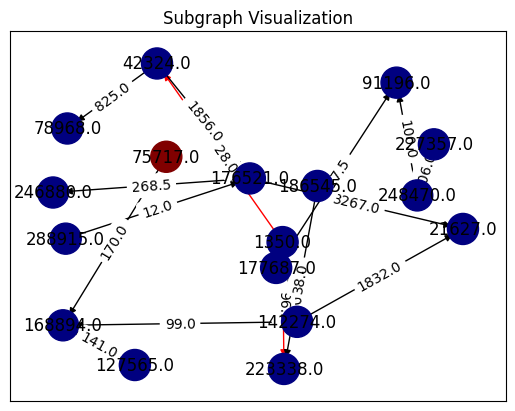

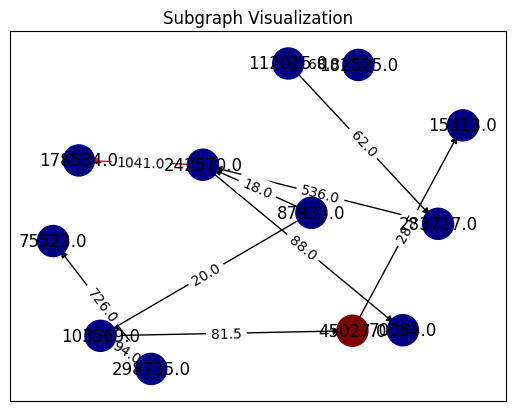

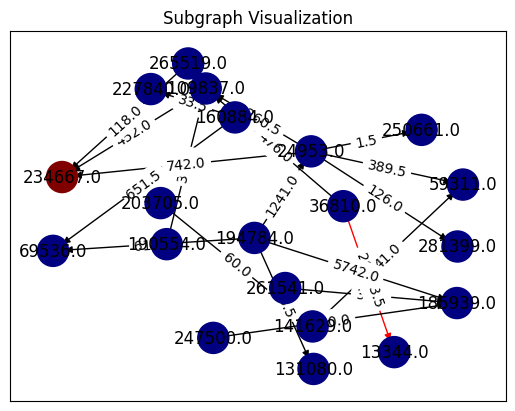

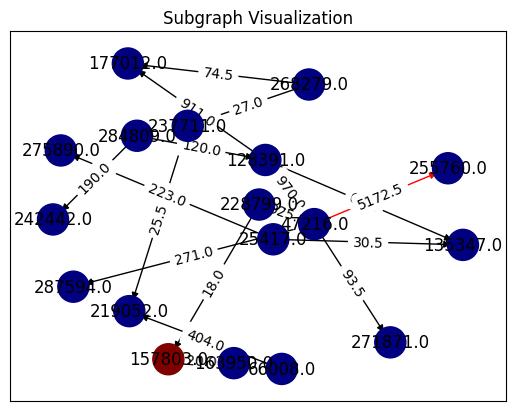

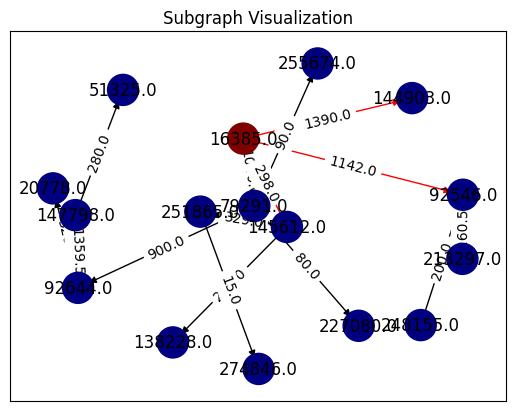

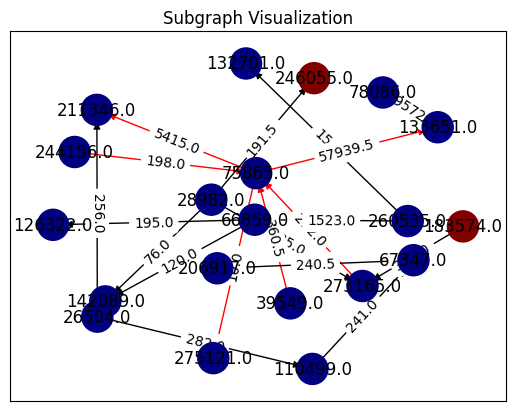

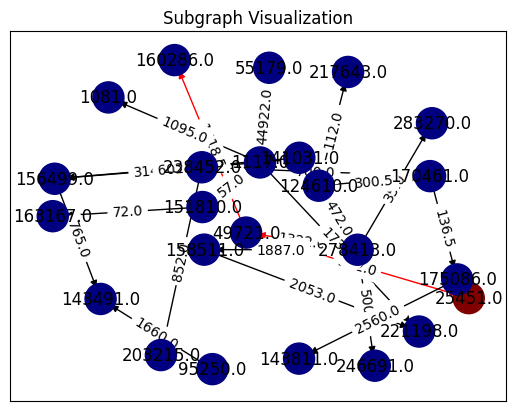

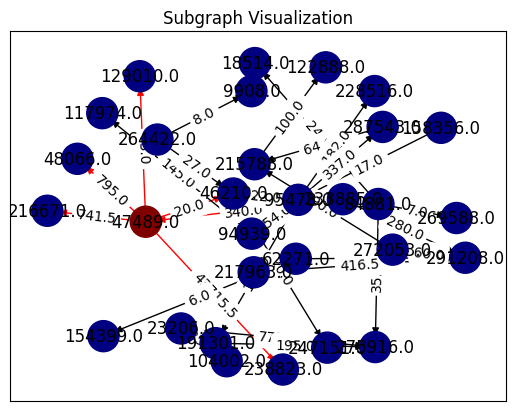

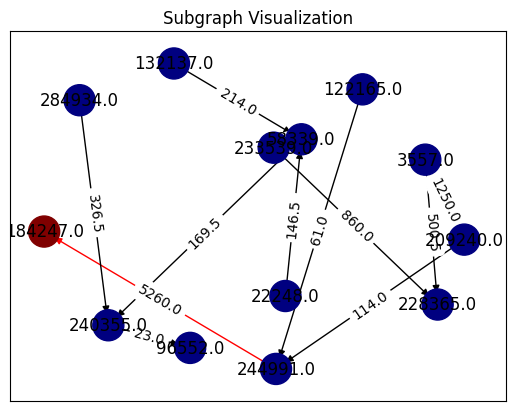

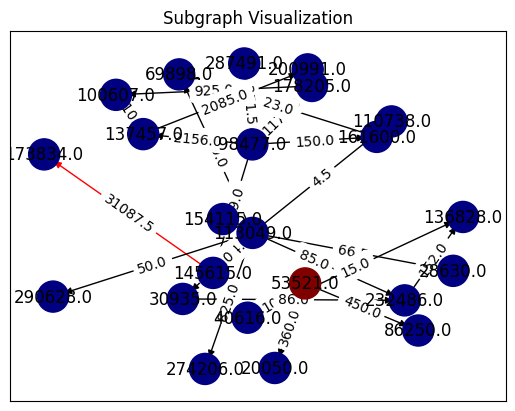

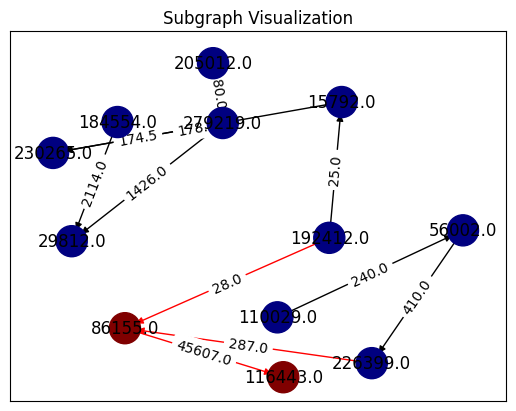

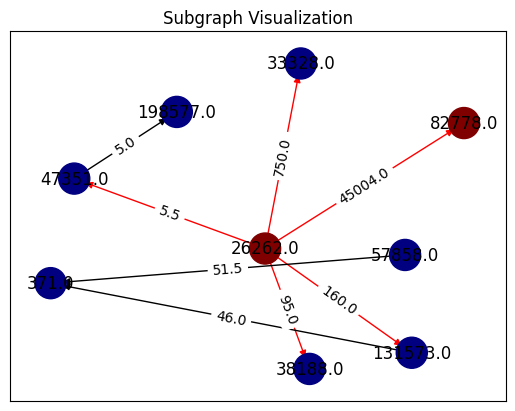

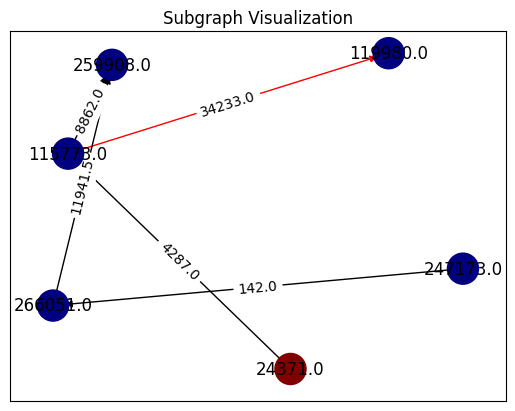

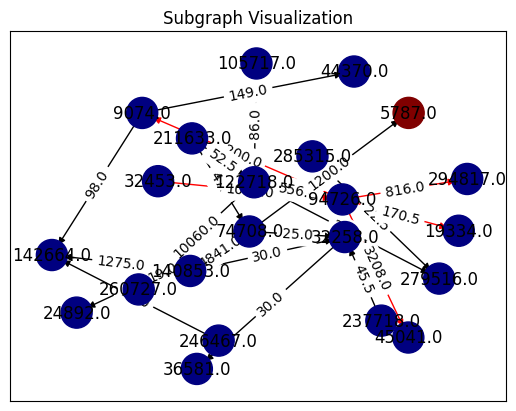

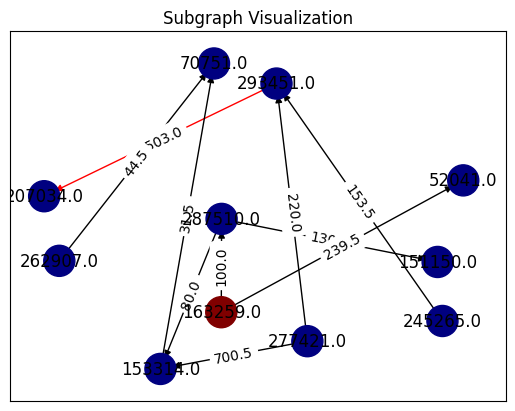

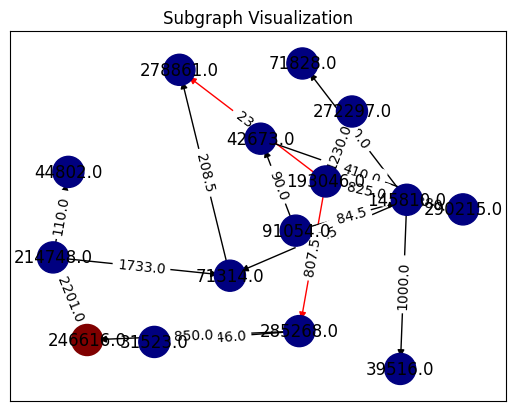

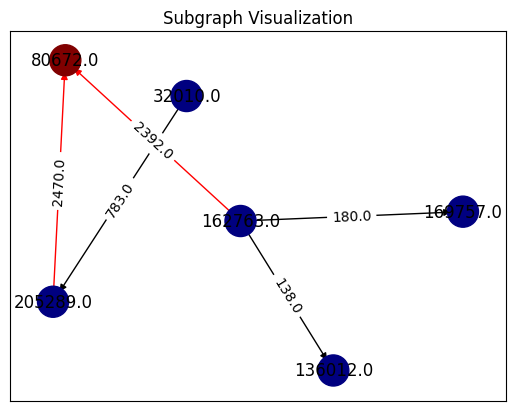

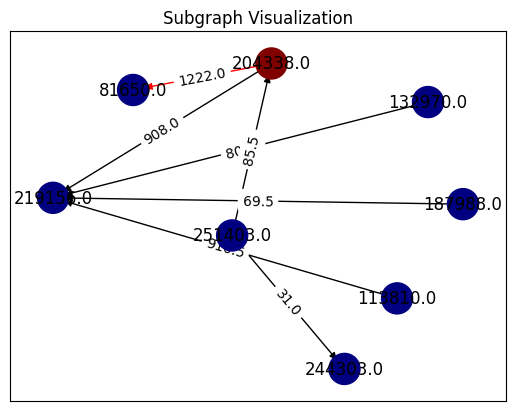

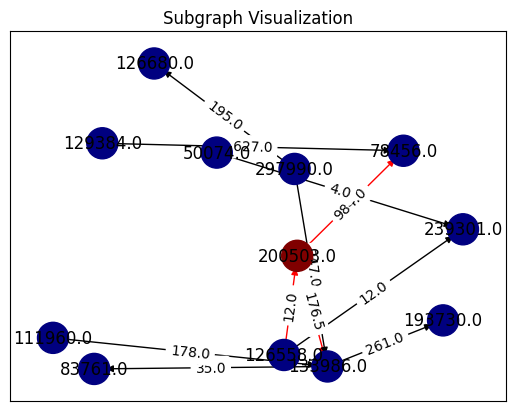

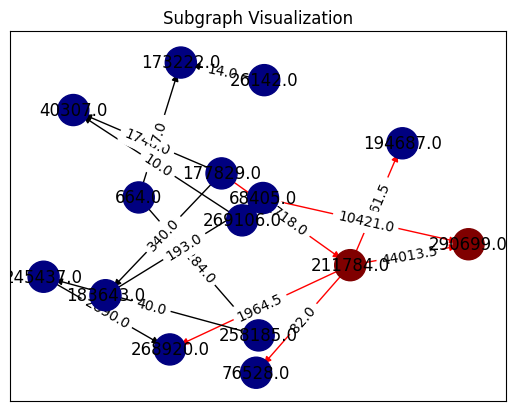

C:\Users\stefa\AppData\Local\Temp\ipykernel_65716\1986832594.py:196: RuntimeWarning: divide by zero encountered in scalar divide
  pos = nx.spring_layout(subgraph,k=5/np.sqrt(subgraph.order()))  # Layout for node positioning


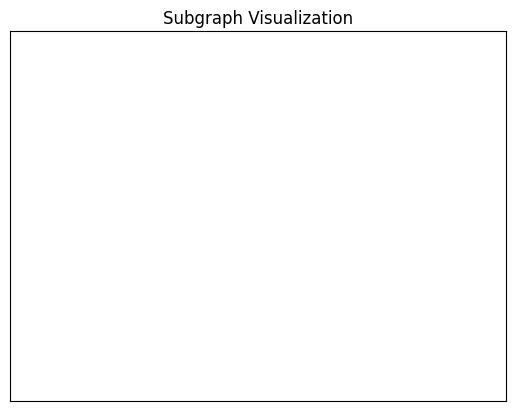

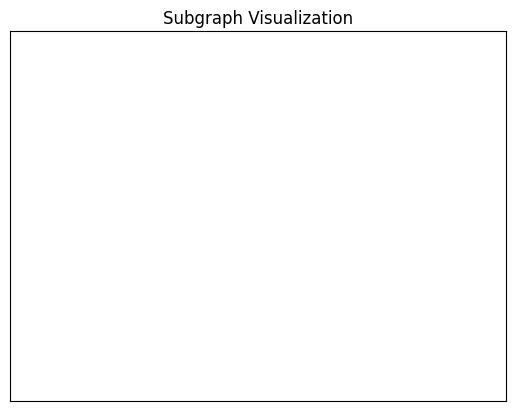

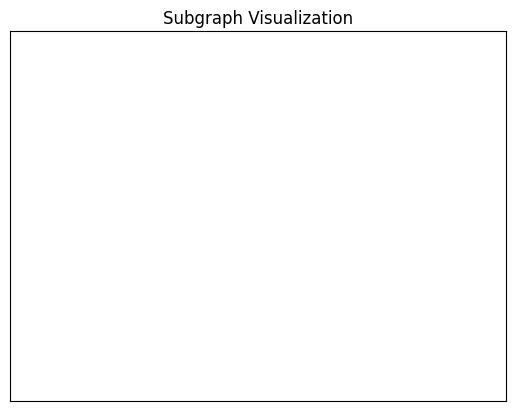

In [52]:
# Make Neighbourhood Graph Directional
neighborhood_graph_directed = nx.DiGraph()
neighborhood_graph_directed.add_edges_from(neighborhood_graph.edges())

# Collect DataFrame Properties
nodes_list = []
suspicious_nodes_list = []
wire_amounts_list = []
countries_list = []
occupations_list = []
foreign_inbound_list = []
domestic_list = []
foreign_outbound_list = []
unknown_list = []
message_scores_list = []
names_list = []
ages_list = []
tenures_list = []


# Map node dictionary to kyc for node-lookup
df_kyc['node_id'] = df_kyc['cust_id'].map(node_dictionary)

# Map node dictionary to wire dataframe for node-lookup
df_wire['node_id_sender'] = df_wire['id sender'].map(node_dictionary)
df_wire['node_id_receiver'] = df_wire['id receiver'].map(node_dictionary)

for s in range(len(suspicious_communities)):    
    subgraph_nodes = suspicious_communities[s]  
    subgraph = neighborhood_graph_directed.subgraph(subgraph_nodes)

    # Reset lists & counts
    suspicious_node_count = 0
    foreign_inbound = 0
    domestic = 0
    foreign_outbound = 0
    unknown = 0
    nodes = []
    names = []
    ages = []
    tenures = []
    occupations = []
    countries = []

    # Color map
    color_map = {}

    # Identify suspicious nodes and store features
    for node in subgraph_nodes:

        # Store node
        nodes.append(node)

        # Look up name 
        name = df_kyc.loc[df_kyc['node_id']==node]['Name']
        if len(name) > 0:
            names.append(name)
        else:
            names.append(np.nan)
        
        # Look up age
        age = df_kyc.loc[df_kyc['node_id']==node]['Age']
        if len(age) > 0:
            ages.append(age)
        else:
            ages.append(np.nan)
        
        # Look up tenure
        tenure = df_kyc.loc[df_kyc['node_id']==node]['Tenure']
        if len(tenure) > 0:
            tenures.append(tenure)
        else:
            tenures.append(np.nan)

        # Look up occupation
        occupation = df_kyc.loc[df_kyc['node_id']==node]['Occupation']
        if len(occupation) >0:
            occupations.append(occupation)
        else:
            occupations.append(np.nan)

        # Look up Country
        country_sender = df_wire.loc[df_wire['node_id_sender']==node]['country sender']
        country_receiver = df_wire.loc[df_wire['node_id_receiver']==node]['country receiver']
        if len(country_sender) > 0:
            countries.append(country_sender)
        elif len(country_receiver) > 0:
            countries.append(country_receiver)
        else:
            countries.append(np.nan)


        # For suspicious nodes
        if node in positive_nodes_ground_truth:
            # color map
            color_map[node] = 1.0
            # update suspicious node count
            suspicious_node_count+=1

        # For non-suspicious nodes
        else:
            # color map
            color_map[node] = 0.25
    
    # Store lists
    nodes_list.append(nodes)
    names_list.append(names)
    ages_list.append(ages)
    tenures_list.append(tenures)
    occupations_list.append(occupations)
    countries_list.append(countries)
    suspicious_nodes_list.append(suspicious_node_count) 

    # Color in the rest of the nodes
    values = [color_map.get(node, 0.25) for node in subgraph_nodes]

    # Edges analysis

    # Edge colors
    red_edges = []
    black_edges = []
    wire_amounts = []
    message_scores = []
    #Analyze Edges
    for edge in subgraph.edges():
        # Look up wire amount
        try:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['amount'].values[0]
        except:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                                  (df_edge['node id receiver'] == edge[0])]['amount'].values[0]
            wire_amounts.append(wire_amount)
        else:
            wire_amounts.append(wire_amount)

    
        # Look up message score
        try:
            message_score = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['key_word_score'].values[0]
        except:
            message_score = df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                                  (df_edge['node id receiver'] == edge[0])]['key_word_score'].values[0]
            message_scores.append(message_score)   
        else:
            message_scores.append(message_score)

        # update transaction counds
        try:
            foreign_inbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['foreign_inbound'].values[0]
        except:
            foreign_inbound += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                           (df_edge['node id receiver'] == edge[0])]['foreign_inbound'].values[0]
        
        try:
            foreign_outbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['foreign_outbound'].values[0]
        except:
            foreign_outbound += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['foreign_outbound'].values[0]  
        try: 
            domestic += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['domestic'].values[0]
        except:
            domestic += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['domestic'].values[0]
        try:
            unknown += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['unknown'].values[0]
        except:
            unknown += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['unknown'].values[0]

        # Color red edge
        if (edge[0] in positive_nodes_ground_truth) or (edge[1] in positive_nodes_ground_truth):
            red_edges.append(edge)
        # Color black edge
        else:
            black_edges.append(edge)

    # Edge labels
    edge_labels=dict([(edge, wire_amounts[i]) for i,edge in enumerate(subgraph.edges())])

    # Store counts
    foreign_inbound_list.append(foreign_inbound)
    domestic_list.append(domestic)
    foreign_outbound_list.append(foreign_outbound)
    unknown_list.append(unknown)
    wire_amounts_list.append(wire_amounts)
    message_scores_list.append(message_scores)


    # Draw the subgraph
    pos = nx.spring_layout(subgraph,k=5/np.sqrt(subgraph.order()))  # Layout for node positioning
    nx.draw_networkx_nodes(subgraph, pos, cmap = plt.get_cmap('jet'), node_color = values, node_size=500)
    nx.draw_networkx_labels(subgraph, pos)
    nx.draw_networkx_edges(subgraph, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(subgraph, pos, edgelist=black_edges, edge_color = 'black', arrows=True)
    nx.draw_networkx_edge_labels(subgraph,pos,edge_labels=edge_labels)
    plt.title("Subgraph Visualization")
    plt.show()

# Build DataFrame
df_suspicious_communities = pd.DataFrame({'nodes':nodes_list, 'names': names_list, 'wire amounts': wire_amounts_list, 'countries': countries_list,
                                       'message_scores': message_scores_list, 'foreign_inbound_trxs': foreign_inbound_list, 
                                       'domestic_trxs': domestic_list, 'foreign_outbound_trxs':foreign_outbound_list, 
                                       'unknown_trxs': unknown_list,'ages': ages_list, 'tenures': tenures_list})

#### Graph Suspicious Communities Undirected

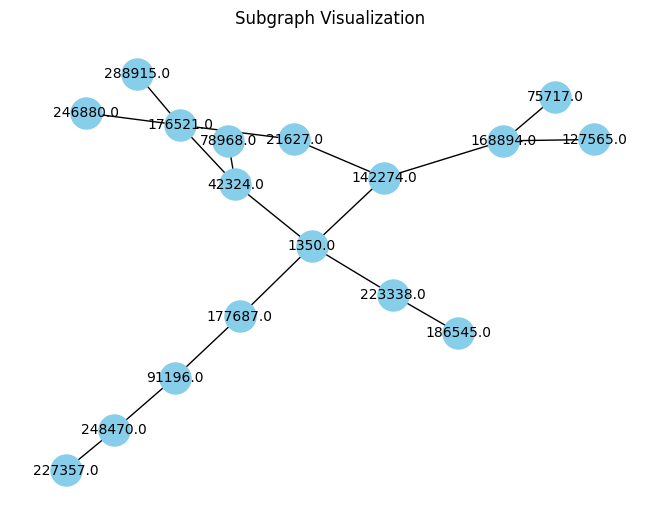

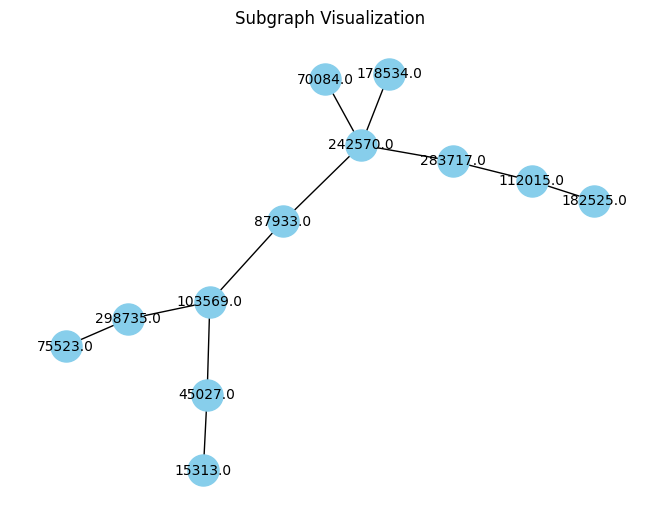

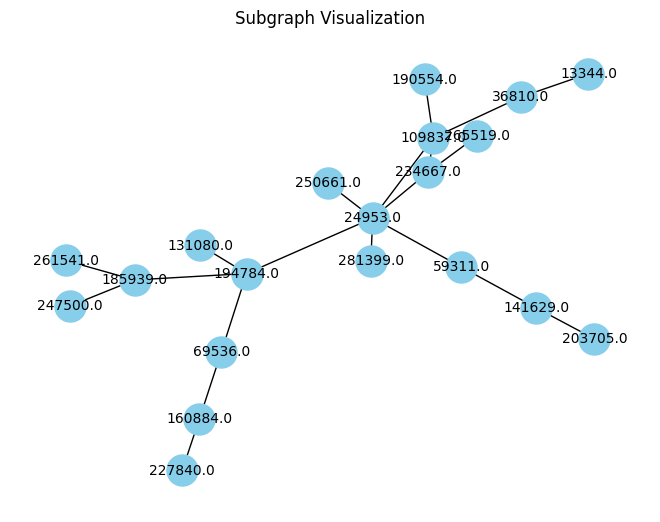

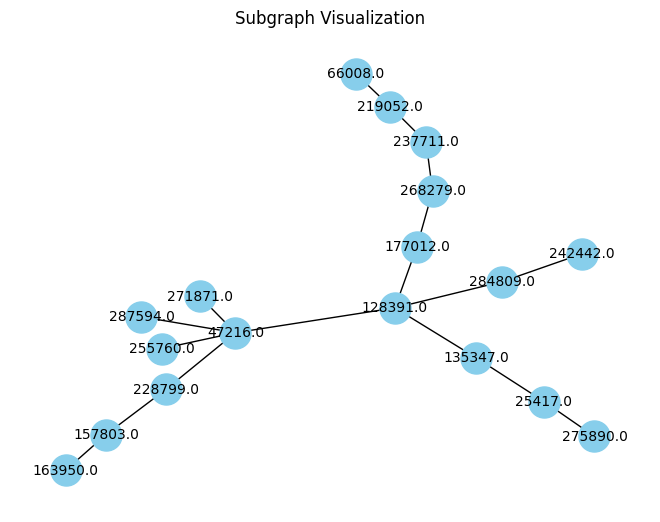

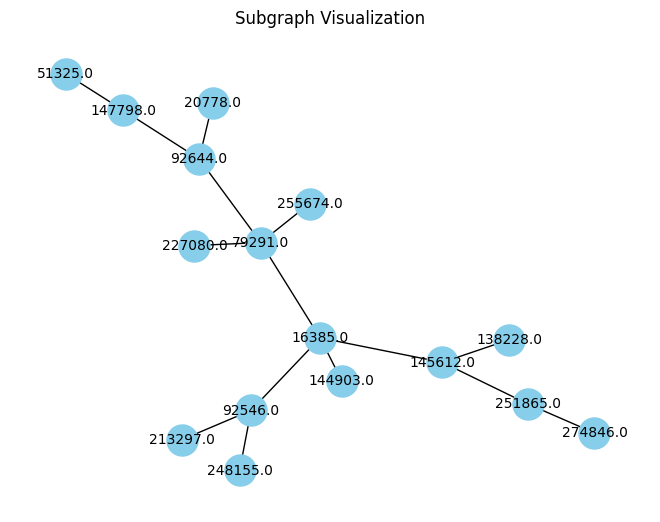

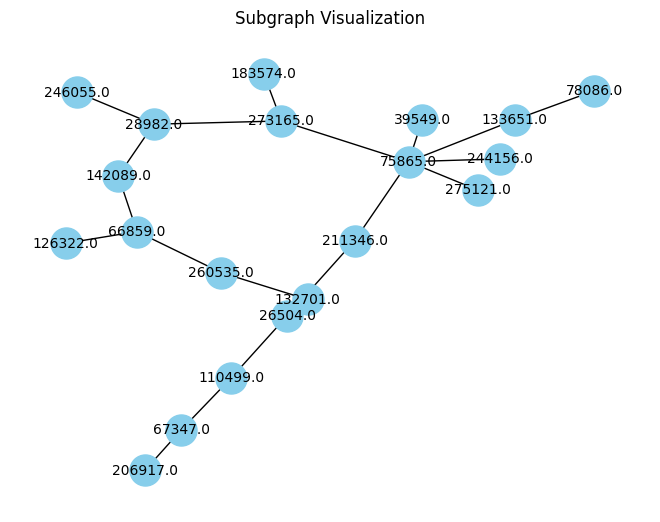

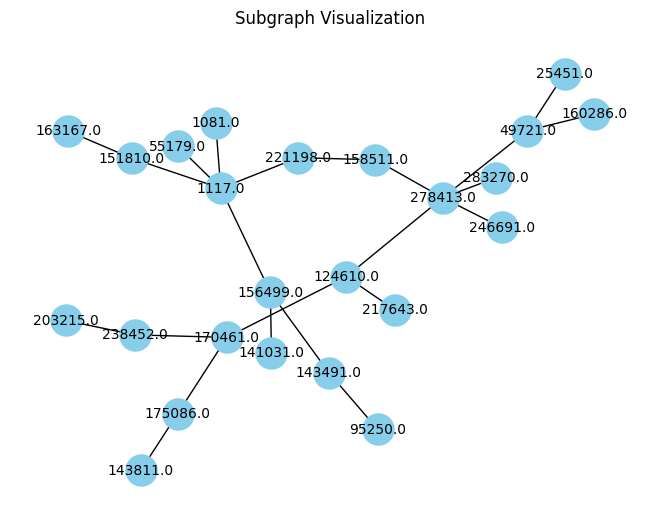

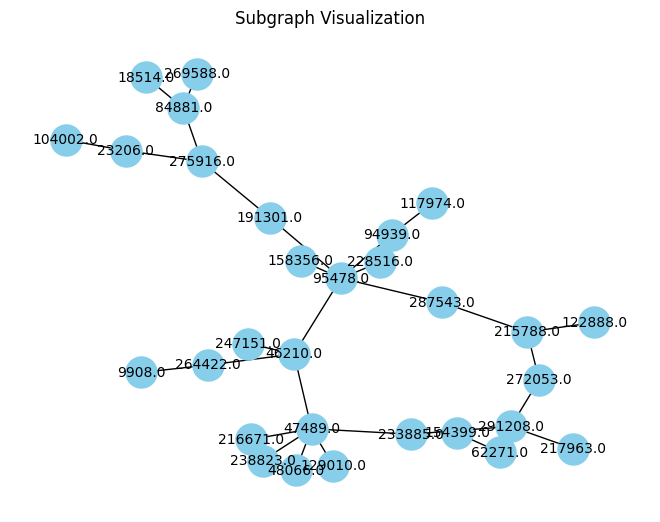

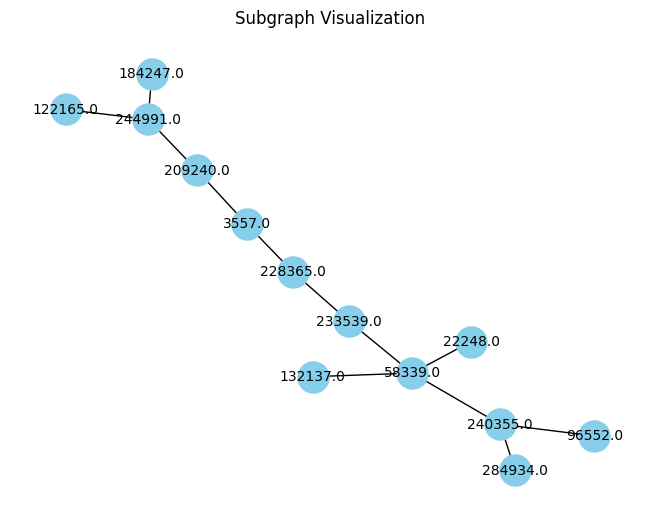

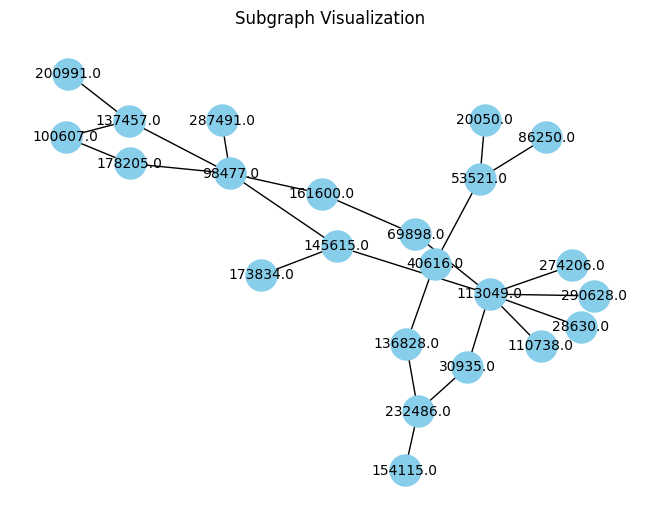

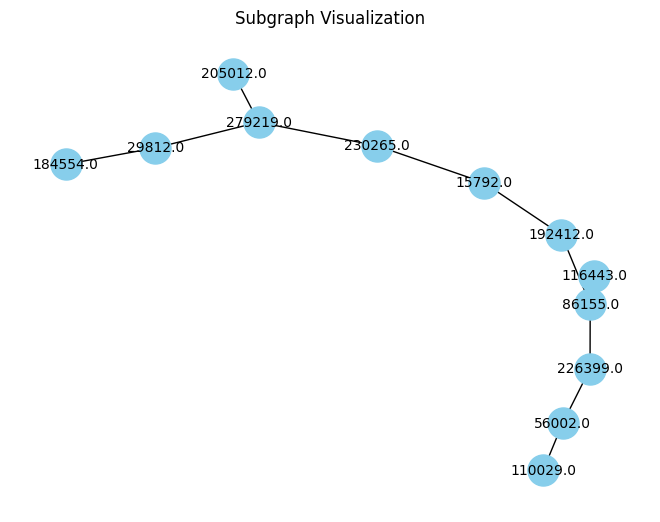

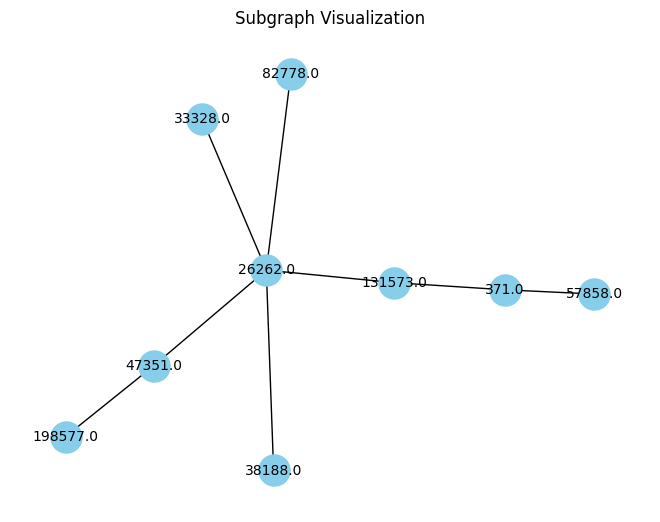

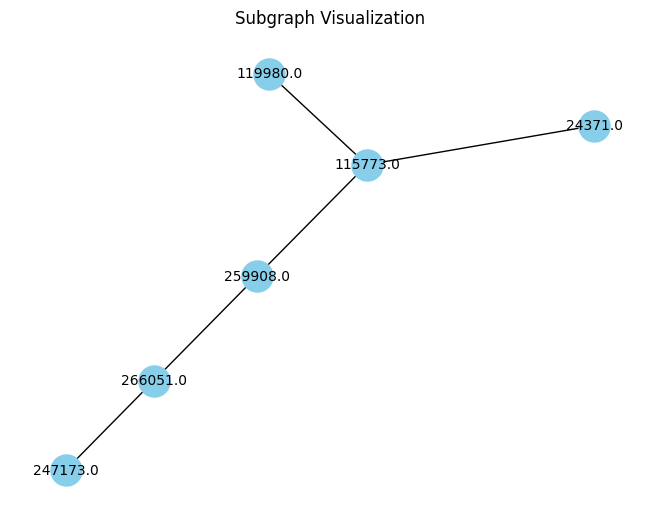

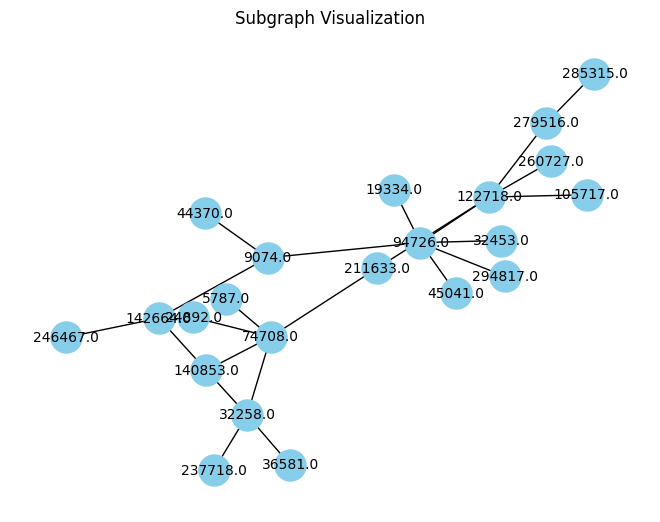

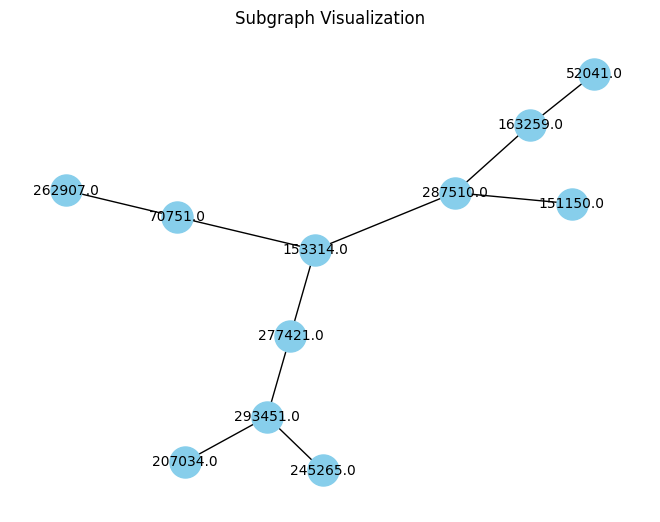

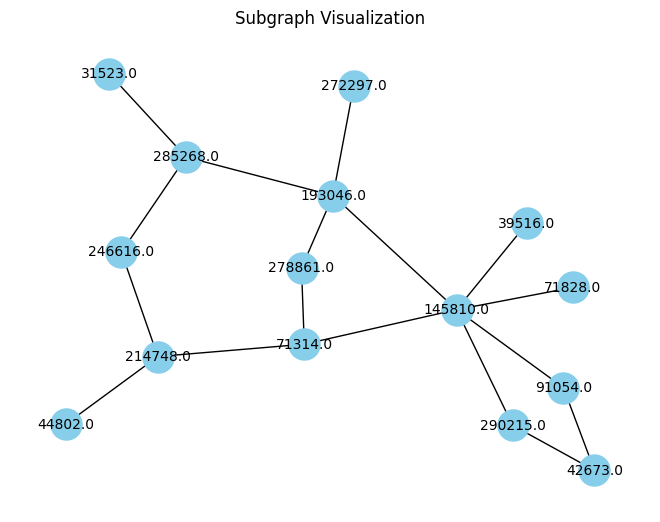

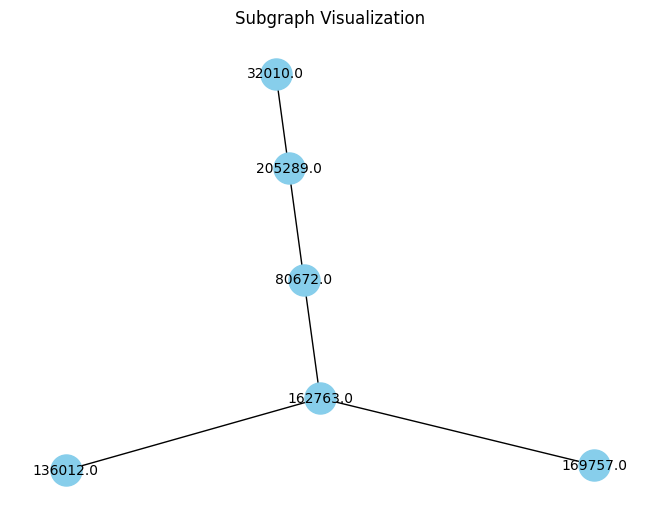

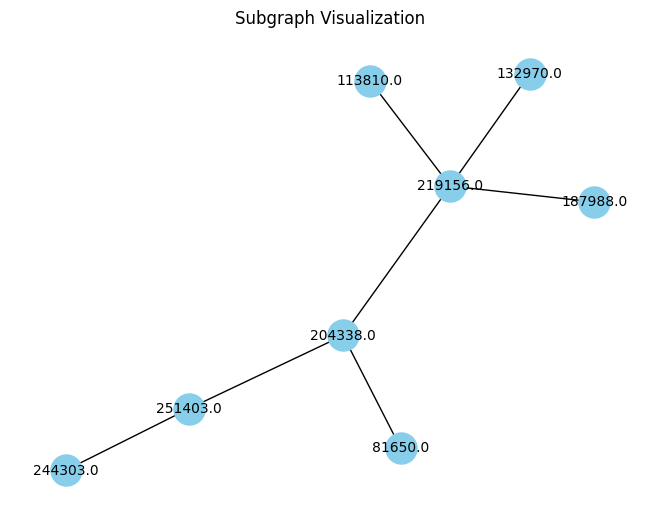

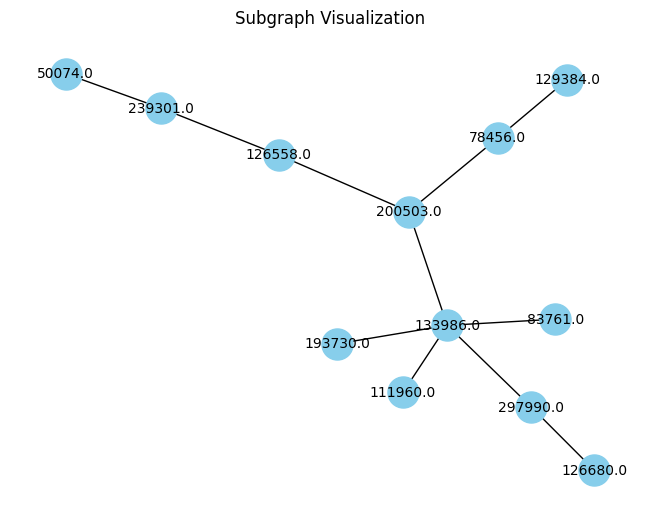

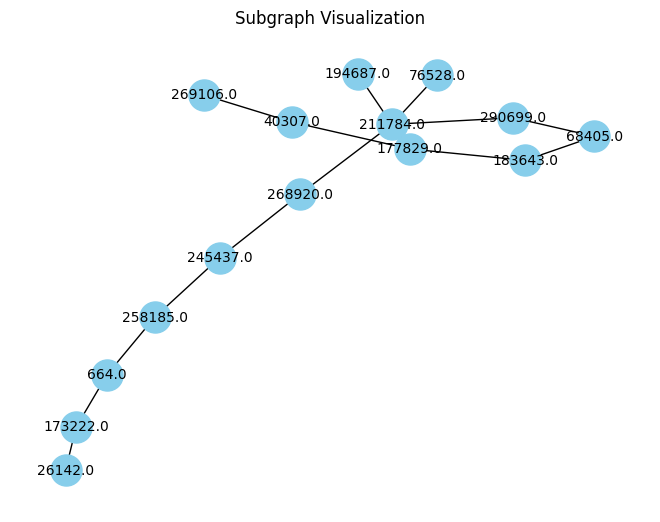

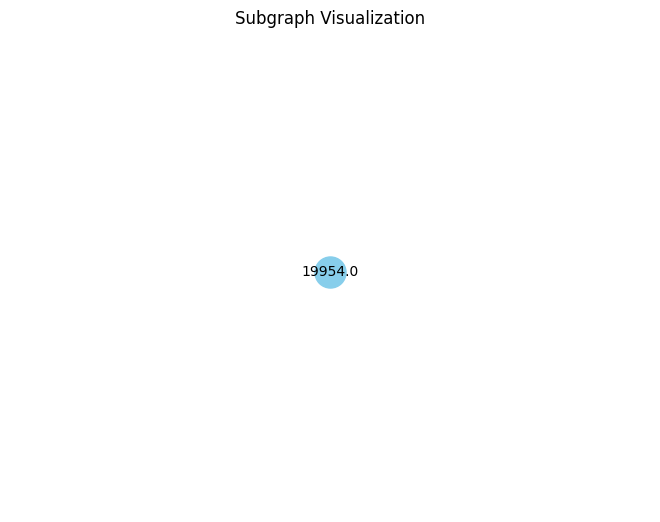

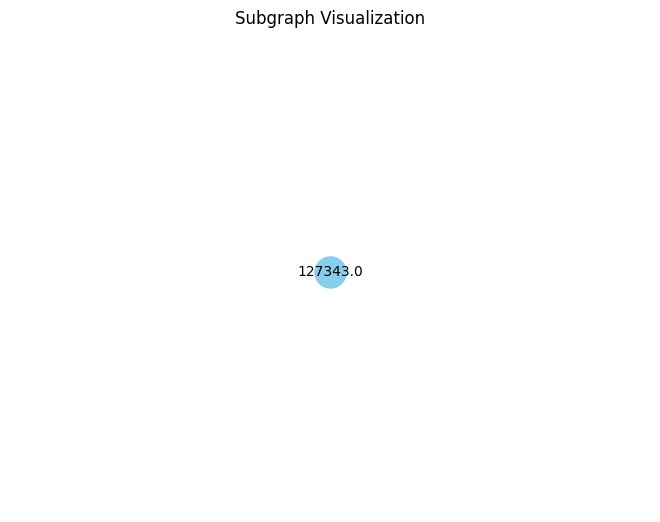

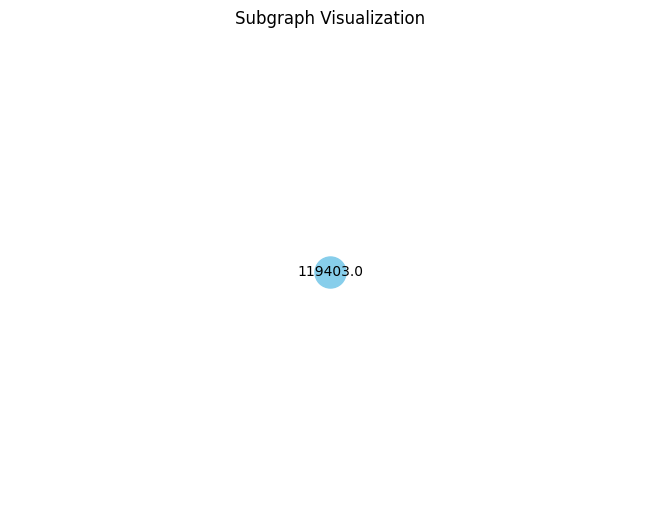

In [53]:
    
for s in range(len(suspicious_communities)):
    subgraph_nodes = suspicious_communities[s]  
    subgraph = neighborhood_graph.subgraph(subgraph_nodes)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  
    nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
    plt.title("Subgraph Visualization")
    plt.show()

### Analyze Results

We can remove communities comprised of 1 node and then show the resulting suspicious communities.

In [57]:
clusters_greater_than_one = []
for i, cluster in enumerate(df_suspicious_communities.nodes):
    if len(cluster) > 1:
        clusters_greater_than_one.append(i)

df_suspicious_communities = df_suspicious_communities.loc[clusters_greater_than_one]
df_suspicious_communities

nodes  \
0   [142274.0, 75717.0, 1350.0, 176521.0, 127565.0...   
1   [75523.0, 45027.0, 70084.0, 283717.0, 178534.0...   
2   [227840.0, 131080.0, 36810.0, 247500.0, 109837...   
3   [128391.0, 284809.0, 25417.0, 242442.0, 237711...   
4   [16385.0, 92546.0, 144903.0, 227080.0, 145612....   
5   [206917.0, 78086.0, 26504.0, 142089.0, 273165....   
6   [151810.0, 143491.0, 124610.0, 143811.0, 28327...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
8   [240355.0, 58339.0, 233539.0, 284934.0, 3557.0...   
9   [161600.0, 154115.0, 290628.0, 287491.0, 17383...   
10  [56002.0, 184554.0, 86155.0, 110029.0, 15792.0...   
11  [57858.0, 38188.0, 33328.0, 198577.0, 371.0, 1...   
12  [266051.0, 259908.0, 247173.0, 24371.0, 119980...   
13  [32258.0, 285315.0, 246467.0, 32453.0, 19334.0...   
14  [153314.0, 52041.0, 293451.0, 277421.0, 151150...   
15  [44802.0, 31523.0, 214748.0, 290215.0, 272297....   
16  [80672.0, 205289.0, 32010.0, 162763.0, 136012....   
17  [132970.0, 251403.0, 244303.0, 81650.0, 204338...   
18  [133986.0, 193730.0, 239301.0, 297990.0, 12938...   
19  [177829.0, 173222.0, 211784.0, 258185.0, 29069...   

                                                names  \
0   [[DR.CHAD MOORE], nan, [NICOLE DRAKE], [MICHEL...   
1   [[JENNIFER GUTIERREZ], [MARGARET AUSTIN], [SYD...   
2   [nan, nan, [AMANDA COX], [WENDY DAVIS], nan, n...   
3   [[COLLIN BALDWIN], [REGINALD SANCHEZ], [CHRIST...   
4   [[CHRISTOPHER ROGERS], [ÉTIENNE LACHAPELLE], n...   
5   [nan, [CAROLINE BLAIR], [EDWARD CRUZ], [JACOB ...   
6   [nan, [STACEY KNIGHT], [LISA JENKINS], nan, [D...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
8   [[JILL HAYES], [SCOTT SULLIVAN], [MELINDA OWEN...   
9   [[DR.ANOUK AUDET], [DEBRA MARTIN], [COURTNEY H...   
10  [[PIHU GROVER], nan, [PATRICK CHANDLER], nan, ...   
11  [[JOHNNY BROWN], [CINDY PATRICK], nan, [NICOLE...   
12  [[DOUGLAS COLLINS], nan, nan, nan, [TONY GUAN]...   
13  [[DR.ALEXANDRE THERRIEN], [COURTNEY JOHNSON], ...   
14  [[KAYLA MORTON], nan, [KELLY JONES], nan, nan,...   
15  [[KEVIN CERVANTES], nan, [APRIL WEST], [BENITO...   
16  [nan, [WILLIAM WILSON], nan, [ANTOINE ST-LAURE...   
17  [[SEAN SMITH], [DARREN TAYLOR], nan, nan, [WAY...   
18  [[LISA BYRD], nan, [DAVID HUBER], [KEVIN PRICE...   
19  [nan, nan, [HEATHER BALL], [DENNIS PATEL], nan...   

                                         wire amounts  \
0   [1832.0, 99.0, 1365.0, 170.0, 96.5, 132.5, 152...   
1   [536.0, 28.5, 88.0, 1041.0, 20.0, 18.0, 726.0,...   
2   [452.0, 33.5, 118.0, 60.0, 41.0, 476.0, 28373....   
3   [62.0, 970.0, 911.0, 223.0, 30.5, 120.0, 190.0...   
4   [1142.0, 1060.0, 1390.0, 260.5, 320.0, 1359.5,...   
5   [19572.0, 256.0, 282.0, 212.0, 314.0, 241.0, 1...   
6   [57.0, 72.0, 1322.0, 35.0, 500.0, 1887.0, 1660...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
8   [860.0, 23.0, 500.5, 1250.0, 326.5, 168.0, 169...   
9   [85.0, 450.0, 360.0, 10.0, 50.0, 825.0, 50.0, ...   
10  [410.0, 2114.0, 45607.0, 240.0, 178.0, 80.0, 1...   
11  [51.5, 46.0, 95.0, 160.0, 5.5, 45004.0, 750.0,...   
12          [11941.5, 142.0, 4287.0, 34233.0, 8862.0]   
13  [30.0, 22.5, 200.0, 816.0, 170.5, 556.0, 3208....   
14  [31.5, 7503.0, 220.0, 700.5, 153.5, 130.0, 80....   
15  [84.5, 90.0, 410.0, 880.0, 998.5, 940.0, 1000....   
16              [2470.0, 783.0, 138.0, 180.0, 2392.0]   
17     [80.0, 85.5, 31.0, 908.0, 1222.0, 69.5, 910.5]   
18  [261.0, 35.0, 178.0, 195.0, 347.0, 627.0, 176....   
19  [340.0, 1718.0, 1740.0, 82.0, 1964.5, 44013.5,...   

                                            countries  \
0   [[CA, CA], nan, [CA, CA, CA, CA, CA], [CA], na...   
1   [nan, nan, nan, nan, [CN, CN], [CA], nan, nan,...   
2   [nan, nan, [CA], nan, [CA], [CA, CA], nan, [CN...   
3   [[CA], nan, nan, nan, nan, [IN], nan, nan, nan...   
4   [[CA, CA], nan, [CN], nan, nan, nan, nan, nan,...   
5   [nan, [CA], nan, nan, nan, [CA], nan, [CN], na...   
6   [nan, [CA], nan, [GE], nan, [IN], nan, nan, na...  

#### Save Nodes

In [107]:
community_unique_nodes = []
for nodes in df_suspicious_communities.nodes:
    community_unique_nodes.extend(nodes)

community_unique_nodes = list(set(community_unique_nodes))

community_nodes_cust_id = [key for key, idx in node_dictionary.items() for i in community_unique_nodes if i == idx ]

#### Analysis

The shapes the communities reflect the shapes seen in research for criminal networks event IWT networks.

There are many clusters that have multiple countries listed, and most of them have unkonwn transactions.

These communities represent a really good result.

#### Refine Communities

We can further refine the communities to increase the strength of our predicted communities.
We can look for clusters with positive message scores and high wire transfer amounts.

Let's highlight a few particularly suspicious networks

In [60]:
# Filter on rows with positive message scores
high_message_networks = []
for i,message in enumerate(df_suspicious_communities['message_scores']):
    for score in message:
        if score > 0.2:
            # Store network
            high_message_networks.append(i)

# Filter on rows with high wire amounts
high_amount_networks = []
for i,amounts in enumerate(df_suspicious_communities['wire amounts']):
    for amount in amounts:
        if amount > df_wire['wire value'].mean():
            # Store network
            high_amount_networks.append(i)

High Message Score Networks

In [63]:
# Filter dataframe on high message score networks
print('These netowrks have high message scores')
df_suspicious_communities.loc[high_message_networks]

These netowrks have high message scores


nodes  \
1   [75523.0, 45027.0, 70084.0, 283717.0, 178534.0...   
2   [227840.0, 131080.0, 36810.0, 247500.0, 109837...   
3   [128391.0, 284809.0, 25417.0, 242442.0, 237711...   
4   [16385.0, 92546.0, 144903.0, 227080.0, 145612....   
5   [206917.0, 78086.0, 26504.0, 142089.0, 273165....   
6   [151810.0, 143491.0, 124610.0, 143811.0, 28327...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
9   [161600.0, 154115.0, 290628.0, 287491.0, 17383...   
9   [161600.0, 154115.0, 290628.0, 287491.0, 17383...   
11  [57858.0, 38188.0, 33328.0, 198577.0, 371.0, 1...   
11  [57858.0, 38188.0, 33328.0, 198577.0, 371.0, 1...   
13  [32258.0, 285315.0, 246467.0, 32453.0, 19334.0...   
13  [32258.0, 285315.0, 246467.0, 32453.0, 19334.0...   
13  [32258.0, 285315.0, 246467.0, 32453.0, 19334.0...   
17  [132970.0, 251403.0, 244303.0, 81650.0, 204338...   
18  [133986.0, 193730.0, 239301.0, 297990.0, 12938...   

                                                names  \
1   [[JENNIFER GUTIERREZ], [MARGARET AUSTIN], [SYD...   
2   [nan, nan, [AMANDA COX], [WENDY DAVIS], nan, n...   
3   [[COLLIN BALDWIN], [REGINALD SANCHEZ], [CHRIST...   
4   [[CHRISTOPHER ROGERS], [ÉTIENNE LACHAPELLE], n...   
5   [nan, [CAROLINE BLAIR], [EDWARD CRUZ], [JACOB ...   
6   [nan, [STACEY KNIGHT], [LISA JENKINS], nan, [D...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
9   [[DR.ANOUK AUDET], [DEBRA MARTIN], [COURTNEY H...   
9   [[DR.ANOUK AUDET], [DEBRA MARTIN], [COURTNEY H...   
11  [[JOHNNY BROWN], [CINDY PATRICK], nan, [NICOLE...   
11  [[JOHNNY BROWN], [CINDY PATRICK], nan, [NICOLE...   
13  [[DR.ALEXANDRE THERRIEN], [COURTNEY JOHNSON], ...   
13  [[DR.ALEXANDRE THERRIEN], [COURTNEY JOHNSON], ...   
13  [[DR.ALEXANDRE THERRIEN], [COURTNEY JOHNSON], ...   
17  [[SEAN SMITH], [DARREN TAYLOR], nan, nan, [WAY...   
18  [[LISA BYRD], nan, [DAVID HUBER], [KEVIN PRICE...   

                                         wire amounts  \
1   [536.0, 28.5, 88.0, 1041.0, 20.0, 18.0, 726.0,...   
2   [452.0, 33.5, 118.0, 60.0, 41.0, 476.0, 28373....   
3   [62.0, 970.0, 911.0, 223.0, 30.5, 120.0, 190.0...   
4   [1142.0, 1060.0, 1390.0, 260.5, 320.0, 1359.5,...   
5   [19572.0, 256.0, 282.0, 212.0, 314.0, 241.0, 1...   
6   [57.0, 72.0, 1322.0, 35.0, 500.0, 1887.0, 1660...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
9   [85.0, 450.0, 360.0, 10.0, 50.0, 825.0, 50.0, ...   
9   [85.0, 450.0, 360.0, 10.0, 50.0, 825.0, 50.0, ...   
11  [51.5, 46.0, 95.0, 160.0, 5.5, 45004.0, 750.0,...   
11  [51.5, 46.0, 95.0, 160.0, 5.5, 45004.0, 750.0,...   
13  [30.0, 22.5, 200.0, 816.0, 170.5, 556.0, 3208....   
13  [30.0, 22.5, 200.0, 816.0, 170.5, 556.0, 3208....   
13  [30.0, 22.5, 200.0, 816.0, 170.5, 556.0, 3208....   
17     [80.0, 85.5, 31.0, 908.0, 1222.0, 69.5, 910.5]   
18  [261.0, 35.0, 178.0, 195.0, 347.0, 627.0, 176....   

                                            countries  \
1   [nan, nan, nan, nan, [CN, CN], [CA], nan, nan,...   
2   [nan, nan, [CA], nan, [CA], [CA, CA], nan, [CN...   
3   [[CA], nan, nan, nan, nan, [IN], nan, nan, nan...   
4   [[CA, CA], nan, [CN], nan, nan, nan, nan, nan,...   
5   [nan, [CA], nan, nan, nan, [CA], nan, [CN], na...   
6   [nan, [CA], nan, [GE], nan, [IN], nan, nan, na...   
7   [[CA, CA], nan, nan, nan, nan, [CA, CA], nan, ...   
7   [[CA, CA], nan, nan, nan, nan, [CA, CA], nan, ...   
7   [[CA, CA], nan, nan, nan, nan, [CA, CA], nan, ...   
7   [[CA, CA], nan, nan, nan, nan, [CA, CA], nan, ...  

High Wire Amount Networks

In [64]:
print('These netowrks have high wire amounts')
df_suspicious_communities.loc[high_amount_networks]

These netowrks have high wire amounts


nodes  \
2   [227840.0, 131080.0, 36810.0, 247500.0, 109837...   
5   [206917.0, 78086.0, 26504.0, 142089.0, 273165....   
5   [206917.0, 78086.0, 26504.0, 142089.0, 273165....   
6   [151810.0, 143491.0, 124610.0, 143811.0, 28327...   
7   [47489.0, 104002.0, 46210.0, 48066.0, 191301.0...   
9   [161600.0, 154115.0, 290628.0, 287491.0, 17383...   
10  [56002.0, 184554.0, 86155.0, 110029.0, 15792.0...   
11  [57858.0, 38188.0, 33328.0, 198577.0, 371.0, 1...   
12  [266051.0, 259908.0, 247173.0, 24371.0, 119980...   
12  [266051.0, 259908.0, 247173.0, 24371.0, 119980...   
12  [266051.0, 259908.0, 247173.0, 24371.0, 119980...   
13  [32258.0, 285315.0, 246467.0, 32453.0, 19334.0...   
14  [153314.0, 52041.0, 293451.0, 277421.0, 151150...   
19  [177829.0, 173222.0, 211784.0, 258185.0, 29069...   
19  [177829.0, 173222.0, 211784.0, 258185.0, 29069...   

                                                names  \
2   [nan, nan, [AMANDA COX], [WENDY DAVIS], nan, n...   
5   [nan, [CAROLINE BLAIR], [EDWARD CRUZ], [JACOB ...   
5   [nan, [CAROLINE BLAIR], [EDWARD CRUZ], [JACOB ...   
6   [nan, [STACEY KNIGHT], [LISA JENKINS], nan, [D...   
7   [[MRS. MACKENZIE LE], [MICHELLE MARTINEZ], [AD...   
9   [[DR.ANOUK AUDET], [DEBRA MARTIN], [COURTNEY H...   
10  [[PIHU GROVER], nan, [PATRICK CHANDLER], nan, ...   
11  [[JOHNNY BROWN], [CINDY PATRICK], nan, [NICOLE...   
12  [[DOUGLAS COLLINS], nan, nan, nan, [TONY GUAN]...   
12  [[DOUGLAS COLLINS], nan, nan, nan, [TONY GUAN]...   
12  [[DOUGLAS COLLINS], nan, nan, nan, [TONY GUAN]...   
13  [[DR.ALEXANDRE THERRIEN], [COURTNEY JOHNSON], ...   
14  [[KAYLA MORTON], nan, [KELLY JONES], nan, nan,...   
19  [nan, nan, [HEATHER BALL], [DENNIS PATEL], nan...   
19  [nan, nan, [HEATHER BALL], [DENNIS PATEL], nan...   

                                         wire amounts  \
2   [452.0, 33.5, 118.0, 60.0, 41.0, 476.0, 28373....   
5   [19572.0, 256.0, 282.0, 212.0, 314.0, 241.0, 1...   
5   [19572.0, 256.0, 282.0, 212.0, 314.0, 241.0, 1...   
6   [57.0, 72.0, 1322.0, 35.0, 500.0, 1887.0, 1660...   
7   [20.0, 741.5, 795.0, 73.0, 43715.5, 20.0, 7.0,...   
9   [85.0, 450.0, 360.0, 10.0, 50.0, 825.0, 50.0, ...   
10  [410.0, 2114.0, 45607.0, 240.0, 178.0, 80.0, 1...   
11  [51.5, 46.0, 95.0, 160.0, 5.5, 45004.0, 750.0,...   
12          [11941.5, 142.0, 4287.0, 34233.0, 8862.0]   
12          [11941.5, 142.0, 4287.0, 34233.0, 8862.0]   
12          [11941.5, 142.0, 4287.0, 34233.0, 8862.0]   
13  [30.0, 22.5, 200.0, 816.0, 170.5, 556.0, 3208....   
14  [31.5, 7503.0, 220.0, 700.5, 153.5, 130.0, 80....   
19  [340.0, 1718.0, 1740.0, 82.0, 1964.5, 44013.5,...   
19  [340.0, 1718.0, 1740.0, 82.0, 1964.5, 44013.5,...   

                                            countries  \
2   [nan, nan, [CA], nan, [CA], [CA, CA], nan, [CN...   
5   [nan, [CA], nan, nan, nan, [CA], nan, [CN], na...   
5   [nan, [CA], nan, nan, nan, [CA], nan, [CN], na...   
6   [nan, [CA], nan, [GE], nan, [IN], nan, nan, na...   
7   [[CA, CA], nan, nan, nan, nan, [CA, CA], nan, ...   
9   [nan, nan, nan, nan, [MX, MX], nan, [CA], [CA,...   
10  [[CA], nan, [CA], nan, nan, [CA], [CA], nan, n...   
11   [nan, nan, [AU], nan, nan, nan, [CA], nan, [MX]]   
12             [[CA], [US, US], nan, nan, [CA], [CA]]   
12             [[CA], [US, US], nan, nan, [CA], [CA]]   
12             [[CA], [US, US], nan, nan, [CA], [CA]]   
13  [nan, nan, nan, nan, nan, [CA, CA], [CA], nan,...   
14  [nan, nan, [CA], nan, nan, nan, nan, nan, [CN,...   
19  [[CA, CA], nan, [CA, CA], nan, [MX], [US], nan...   
19  [[CA, CA], nan, [CA, CA], nan, [MX], [US], nan...   

                                       message_scores  foreign_inbound_trxs  \
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                     1   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                     1   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                     1   
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                     2   
7

## Spectral Partitioning for Diversity

Research suggests that IWT networks compared to other criminal networks are diffirentiable based on the diversity of the networks. 'Based on their analysis of expert opinions, illegally traded wildlife has the most distinct and diverse attributes compared to the other illicit networks.' [https://www.sciencedirect.com/science/article/pii/S0305048322001876]

This means, we should not only be looking for outlier/suspicious nodes, we should be looking at communities with diverse attributes.

We can achieve this by using spectral partitioning with attribute dissimilarity. We can construct a dissimilarity matrix based on node attributes, and input it to a spectral partitioning algorithm for cluster identification.

Communities vs Clusters Discussion

-    Communites tend to have higher internal densities, relative to clusters optimized in partitioning algorithms
-    Animal trafficking networks tend be tightly-knit. Resembling communities in shape/arrangement over clusters
-    Communities tend to have a higher internal connectivity, with multiple pathways between pairs of nodes in the network over clusters
-    Modularity algorithms allow for multi-scale partitioning and hierarchical modules, which can capture global groups across the graph.
     Where spectral partitioning do not have such advantages, and can be noisy 

Proposed Method

-   Use Lauvian Modularity to make large hierarchical partitions
-   Within these global communities, use spectral partitioning with attrribute dissimilarity to detect networks 

### Regional Lauvian Modules

In [81]:
# Store suspicious global communities 
suspicious_regional_communities = extract_communities(neighborhood_graph, positive_nodes_ground_truth, n_iterations = 1)
# ignore 1-node communities
suspicious_regional_communities = [c for c in suspicious_regional_communities if len(c) > 1]

print('The total number of regional communities in the neighbourhood graph is:', len(suspicious_regional_communities))

0
The total number of regional communities in the neighbourhood graph is: 10


### Spectral Clusters with Attribute Disimilarity

In [84]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances

# for all the regional communities, find the most diverse clusters
clusters = []
for i,community in enumerate(suspicious_regional_communities):
    print(f'Community: {i}/{len(suspicious_regional_communities)}')

    # re-index nodes so we can access them in the euclidean matrix
    community_node_index = {node:i for i,node in enumerate(community)}

    # node attributes
    node_attributes = data.x[community].numpy()

    # compute attribute dissimilarity matrix
    dissimilarity_matrix = euclidean_distances(node_attributes)
    for i in range(len(node_attributes)):
        for j in range(len(node_attributes)):
            dissimilarity_matrix[i, j] = np.linalg.norm(node_attributes[i] - node_attributes[j])
    
    # Transform dissimilarity matrix to similarity matrix
    similarity_matrix = np.exp(-dissimilarity_matrix)
    # Rename for consistency
    dissimilarity_matrix = similarity_matrix

    # regional neighbourhood
    regional_subgraph = neighborhood_graph.subgraph(list(community))

    # local communities using modularity (community constraint)
    local_communities = (nx.algorithms.community.modularity_max.greedy_modularity_communities(regional_subgraph))
    # convert from frozenset to list
    local_communities = [list(x) for x in local_communities]
    # change indices from floats to ints
    local_communities = [[int(x) for x in community] for community in local_communities]
    # find clusters within local communities
    for local_community in local_communities:
        local_community_indices = [community_node_index[node] for node in local_community]
        # extract dissimilarity matrix for current local community
        local_dissimilarity_matrix = dissimilarity_matrix[np.ix_(local_community_indices, local_community_indices)]

        # Determine the number of clusters using the eigengap method
        eigvals = np.linalg.eigvalsh(local_dissimilarity_matrix)
        eigengap = np.diff(np.sort(eigvals))[-1]
        n_clusters = np.argmax(np.diff(np.sort(eigvals)))+1

        # Partition using Spectral Clustering
        spectral = SpectralClustering(affinity='precomputed', n_clusters=n_clusters, random_state=0)
        suspicious_clusters = spectral.fit_predict(local_dissimilarity_matrix)
        clusters.append(list(suspicious_clusters))
        # for cluster in suspicious_clusters:
        #     print(cluster)
        #     clusters.append(cluster)

Community: 0/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (158). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\s

Community: 1/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (79) found smaller than n_clusters (671). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\

Community: 2/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (463). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\

Community: 3/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (556). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\

Community: 4/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (64) found smaller than n_clusters (455). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\

Community: 5/10


KeyboardInterrupt: 

Show the summary of spectral clustering for diversity

In [102]:
# print('Total number of clusters found:', len(clusters))
# print('Total number of unique nodes among clusters found:', len(set([c for cluster in clusters for c in cluster])))
print('Average number of nodes per cluster:', int(np.mean([len(c) for c in clusters])))

### Use Graph Convolutional Neural Network to predict Main Actors Across Clusters

In [562]:
# Convert the nodes from spectral indices (for euclidean distance) back to original node indices
clusters_nodes = [[key for key, idx in community_node_index.items() for i in cluster if i == idx ] for cluster in clusters]
# Drop duplicate nodes for prediction
clusters_nodes_set = list(set([node for cluster in clusters_nodes for node in cluster]))
# Convert to integers
clusters_nodes_set = [int(node) for node in clusters_nodes_set]

# Predict on PyG undelying Data object
output = model(data)

# Store Positive predictions
predicted_labels = (output[0][:300008] > 0.5).int()
predicted_labels = predicted_labels.numpy().flatten()

print('The total number of predictived postiive labels is', np.sum(predicted_labels[clusters_nodes_set]))

# Store positive label indices and associated node id's
positive_indices = np.argwhere(predicted_labels[clusters_nodes_set].flatten() ==1).flatten()

positive_nodes_all_diverse_clusters = [clusters_nodes_set[i] for i in positive_indices]

The total number of predictived postiive labels is 50


## Spectral Partitioning for Diversity with Connectivity Constraints

### Spectral Clusters on Attribute Disimilarity with Connectivity Constraints

We can use modularity partitioning to get heirarchical modules that represent large regions of the graph, with global structures.

We can then use spectral partitioning with dissimilarity to get the most diverse clusters in the regions.

In [94]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances

# for all the regional communities, find the most diverse clusters
clusters = []
subgraphs = []
for i,community in enumerate(suspicious_regional_communities):
    print(f'Community: {i}/{len(suspicious_regional_communities)}')

    # re-index nodes so we can access them in the euclidean matrix
    community_node_index = {node:i for i,node in enumerate(community)}

    # node attributes
    node_attributes = data.x[community].numpy()

    # compute attribute dissimilarity matrix
    dissimilarity_matrix = euclidean_distances(node_attributes)
    for i in range(len(node_attributes)):
        for j in range(len(node_attributes)):
            dissimilarity_matrix[i, j] = np.linalg.norm(node_attributes[i] - node_attributes[j])

    # Rename for convention
    similarity_matrix = np.exp(-dissimilarity_matrix)
    dissimilarity_matrix = similarity_matrix

    # regional neighbourhood
    regional_subgraph = neighborhood_graph.subgraph(list(community))

    # local communities using modularity (community constraint)
    local_communities = (nx.algorithms.community.modularity_max.greedy_modularity_communities(regional_subgraph))
    # convert from frozenset to list
    local_communities = [list(x) for x in local_communities]
    # change indices from floats to ints
    local_communities = [[int(x) for x in community] for community in local_communities]
    # find clusters within local communities
    for local_community in local_communities:
        local_community_indices = [community_node_index[node] for node in local_community]
        # extract dissimilarity matrix for current local community
        local_dissimilarity_matrix = dissimilarity_matrix[np.ix_(local_community_indices, local_community_indices)]

        # Determine the number of clusters using the eigengap method
        eigvals = np.linalg.eigvalsh(local_dissimilarity_matrix)
        eigengap = np.diff(np.sort(eigvals))[-1]
        n_clusters = np.argmax(np.diff(np.sort(eigvals)))+1

        # Partition using Spectral Clustering
        spectral = SpectralClustering(affinity='precomputed', n_clusters=n_clusters, random_state=0)
        suspicious_clusters = spectral.fit_predict(local_dissimilarity_matrix)
        
        # # Convert Matrix indices back to node indices
        # if len(suspicious_clusters.shape) > 1:
        #     print('multiple clusters')
        #     suspicious_clusters = [[key for key, idx in community_node_index.items() for i in cluster if i == idx ] for cluster in suspicious_clusters]
        #     # Add edges between nodes in the same suspicious cluster
        #     for cluster in suspicious_clusters:
        #         # create subgraph
        #         subgraph = neighborhood_graph.subgraph(cluster)
        #         frozen_subgraph = nx.freeze(subgraph)
        #         unfrozen_subgraph = nx.Graph(frozen_subgraph)
        #         for node_u in cluster:
        #             for node_v in cluster:
        #                 if node_u != node_v and G.has_edge(node_u, node_v):
        #                     # get edge attributes from original graph
        #                     edge_attrs = G.get_edge_data(node_u, node_v)
        #                     # add edge preserving edge attributes
        #                     unfrozen_subgraph.add_edge(node_u, node_v, **edge_attrs)
                
        #         # Check for connected components
        #         connected_components = list(nx.connected_components(unfrozen_subgraph))
        #         if len(connected_components) > 1: # if the graph is not fully connected
        #             # store each separate component as a subgraph
        #             for component  in connected_components:
        #                 clusters.append(component)
        #         else:
        #             clusters.append(cluster)

        print('Post-Processing Cluster for Connectivity Constraints')
        suspicious_clusters = [key for key, idx in community_node_index.items() for i in suspicious_clusters if i == idx ]
        # Add edges between nodes in the same suspicious cluster
        # create subgraph
        subgraph = neighborhood_graph.subgraph(suspicious_clusters)
        frozen_subgraph = nx.freeze(subgraph)
        unfrozen_subgraph = nx.Graph(frozen_subgraph)
        for node_u in suspicious_clusters:
            for node_v in suspicious_clusters:
                if node_u != node_v and G.has_edge(node_u, node_v):
                    # get edge attributes from original graph
                    edge_attrs = G.get_edge_data(node_u, node_v)
                    # add edge preserving edge attributes
                    unfrozen_subgraph.add_edge(node_u, node_v, **edge_attrs)
        
        # Check for connected components
        connected_components = list(nx.connected_components(unfrozen_subgraph))
        if len(connected_components) > 1: # if the graph is not fully connected
            # store each separate component as a subgraph
            for component  in connected_components:
                clusters.append(component)
        else:
            clusters.append(suspicious_clusters)

Community: 0/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (158). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embeddin

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embeddin

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embeddin

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Community: 1/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py", line 47, in _sum
    def _sum(a, axis=None, dtype=None, out=None, keepdims=False,
    
KeyboardInterrupt: 
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (79) found smaller than n_clusters (671). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (61) found smaller than n_clusters (561). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (322). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (285). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (213). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Community: 2/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (463). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (35) found smaller than n_clusters (385). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (268). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (238). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Community: 3/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (556). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (357). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (31) found smaller than n_clusters (343). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (323). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (314). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (62). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Community: 4/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (64) found smaller than n_clusters (455). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (258). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (175). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (174). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (109). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embeddin

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Community: 5/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (535). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (60) found smaller than n_clusters (469). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (56) found smaller than n_clusters (453). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (334). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Community: 6/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (43) found smaller than n_clusters (578). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (58) found smaller than n_clusters (495). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (331). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (279). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (244). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (196). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (164). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Community: 7/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (56) found smaller than n_clusters (612). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (58) found smaller than n_clusters (549). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (447). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (252). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (110). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Community: 8/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (61) found smaller than n_clusters (423). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (191). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (107). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embeddin

Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Post-Processing Cluster for Connectivity Constraints
Community: 9/10


c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

Remove Clusters that are left-over componenets (i.e. 1-3 node clusters)

In [101]:
# Remove clusters with length 1-3
connected_clusters = [c for c in clusters if (len(c) > 3)]

117474443it [07:56, 246633.30it/s]     


KeyboardInterrupt: 

Show the summary of spectral clustering for diversity with community constraints

In [108]:
print('Total number of clusters found:', len(connected_clusters))
print('Total number of unique nodes among clusters found:', len(set([c for cluster in connected_clusters for c in cluster])))
print('Average number of nodes per cluster:', int(np.mean([len(c) for c in connected_clusters])))

### Use Graph Convolutional Neural Network to predict Main Actors Across Clusters

In [ ]:
# Convert the nodes from spectral indices (for euclidean distance) back to original node indices
connected_clusters_nodes = [[key for key, idx in community_node_index.items() for i in cluster if i == idx ] for cluster in connected_clusters]
# Drop duplicate nodes for prediction
connected_clusters_nodes_set = list(set([node for cluster in connected_clusters_nodes for node in cluster]))
# Convert to integers
connected_clusters_nodes_set = [int(node) for node in connected_clusters_nodes_set]

# Predict on PyG undelying Data object
output = model(data)

# Store Positive predictions
predicted_labels = (output[0][:300008] > 0.5).int()
predicted_labels = predicted_labels.numpy().flatten()

print('The total number of predictived postiive labels is', np.sum(predicted_labels[connected_clusters_nodes_set]))

# Store positive label indices and associated node id's
positive_indices = np.argwhere(predicted_labels[connected_clusters_nodes_set].flatten() ==1).flatten()

positive_nodes_all_diverse_connected_clusters = [connected_clusters_nodes_set[i] for i in positive_indices]

#### Refine Clusters 

Filter on clusters that are within a reasonable range to be trafficking networks

In [91]:
# Filter on cluster length
small_connected_clusters = [c for c in connected_clusters if (len(c) < 30)]

Gather All Positively Labelled Nodes for Visualize Analysis in next part

In [775]:
all_positive_nodes = positive_nodes_all_diverse_connected_clusters + positive_nodes_all_diverse_clusters

all_positive_nodes = list(set(all_positive_nodes))

#### Visualize Undirected Graphs of Spectral Cluster for Diveristy with Community Constraints and Reasonable Cluster Size

Visualize first 20 graphs

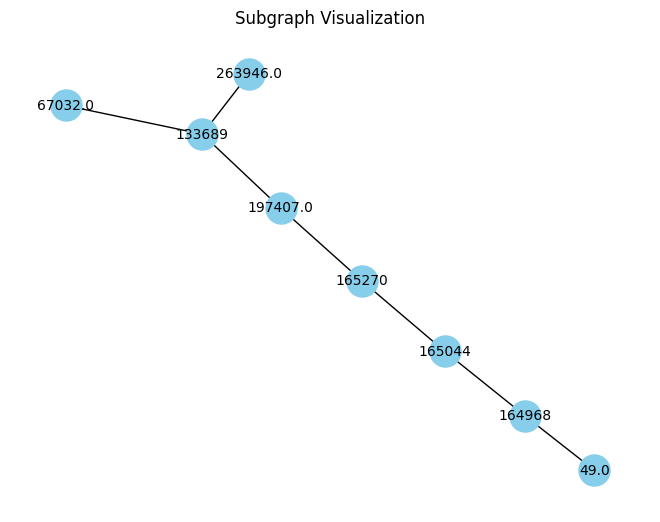

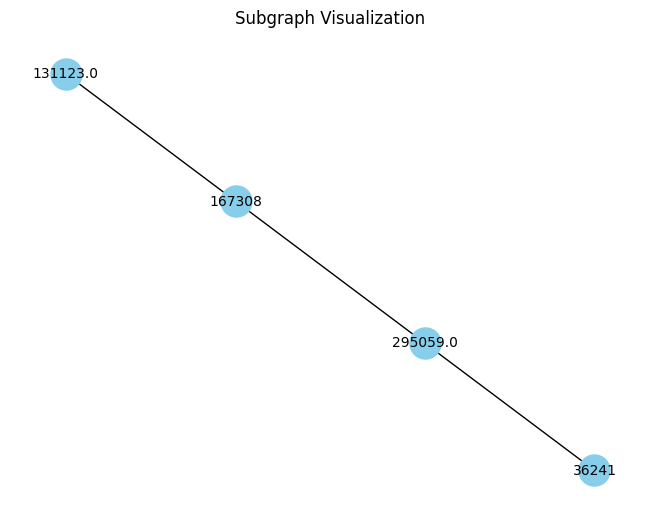

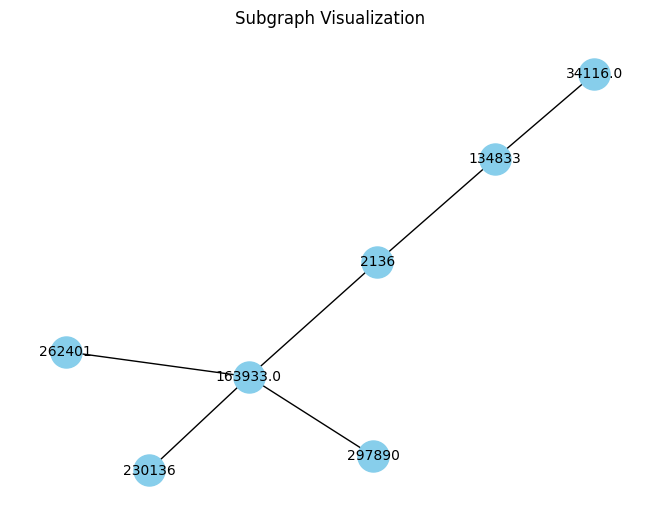

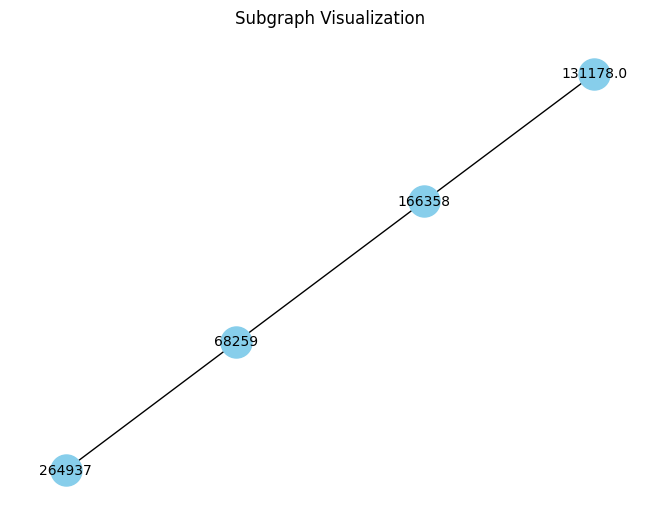

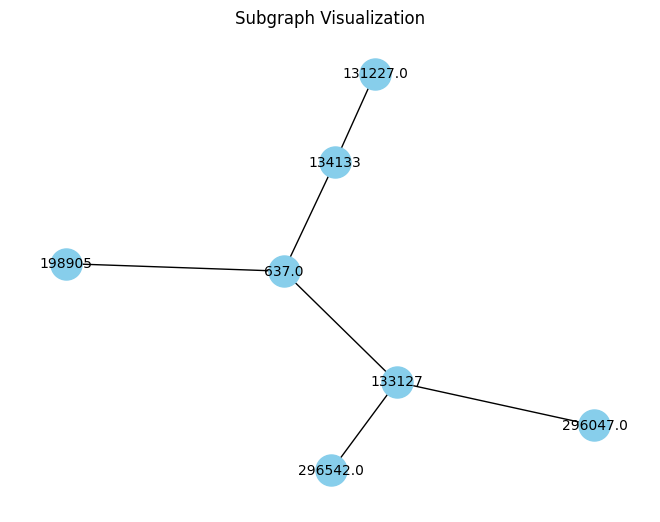

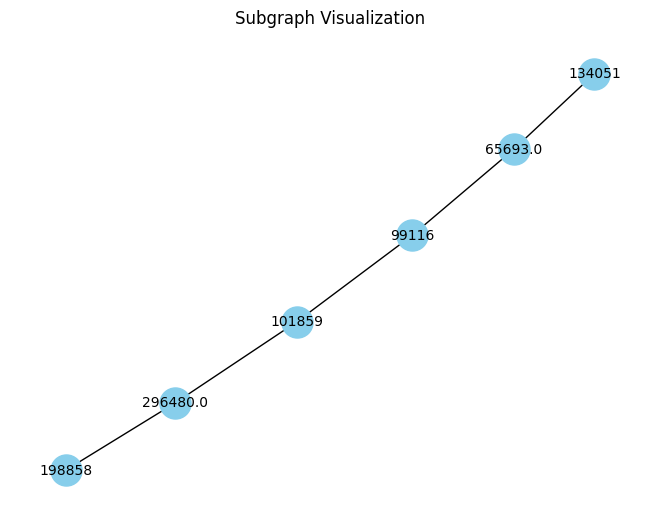

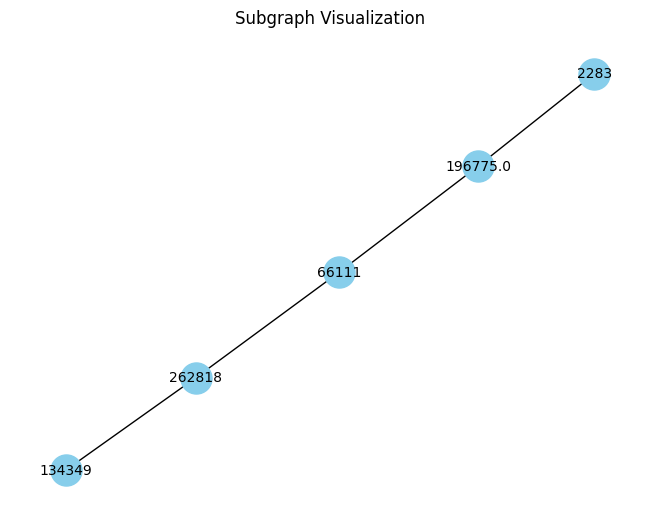

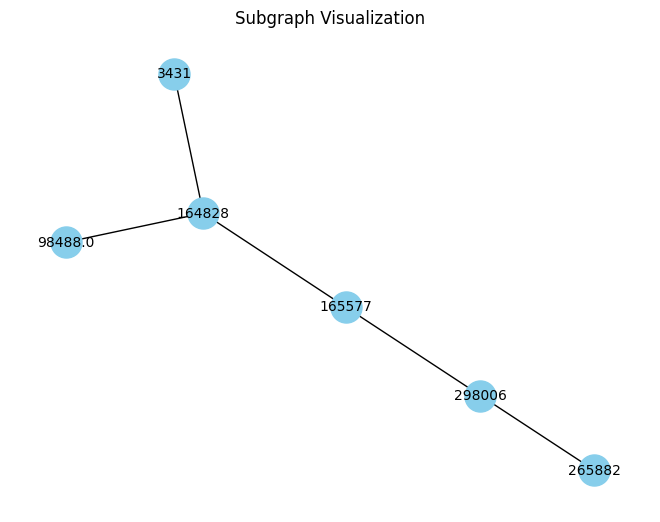

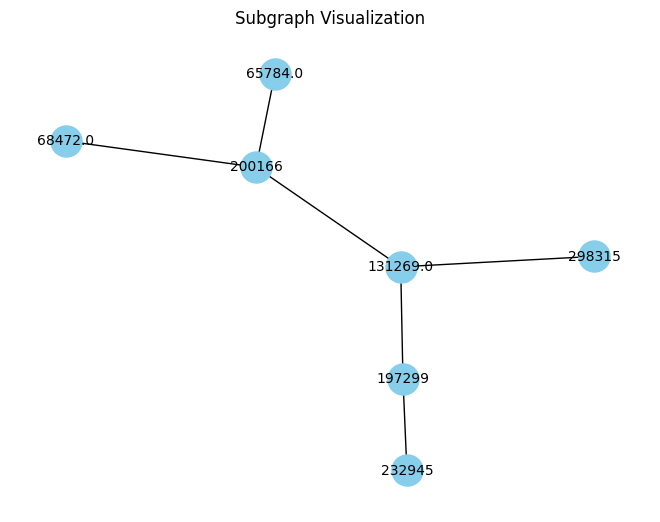

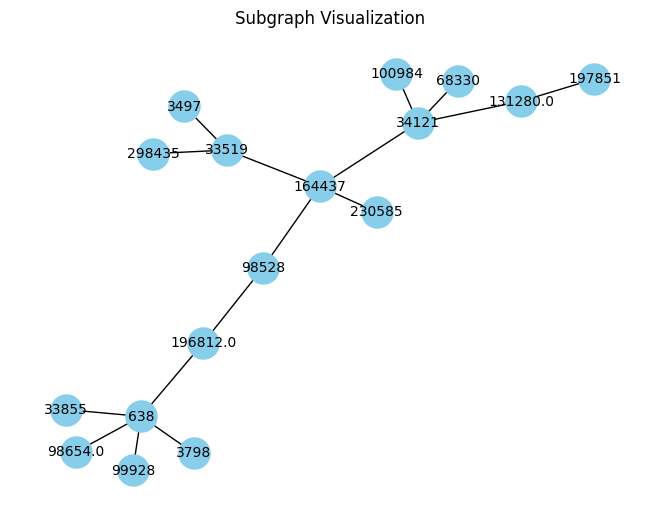

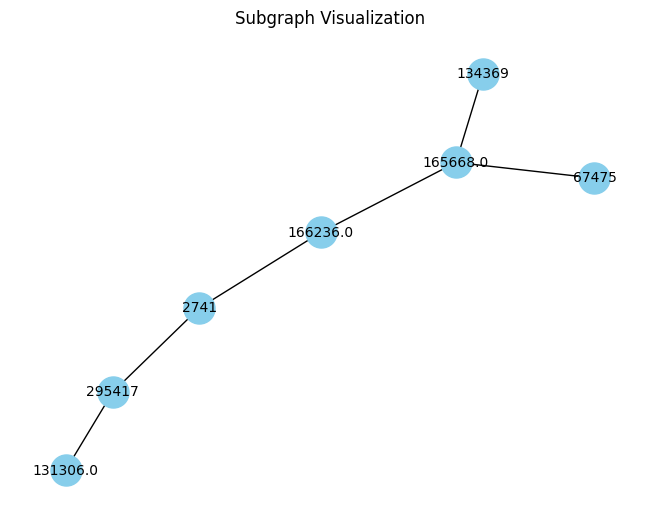

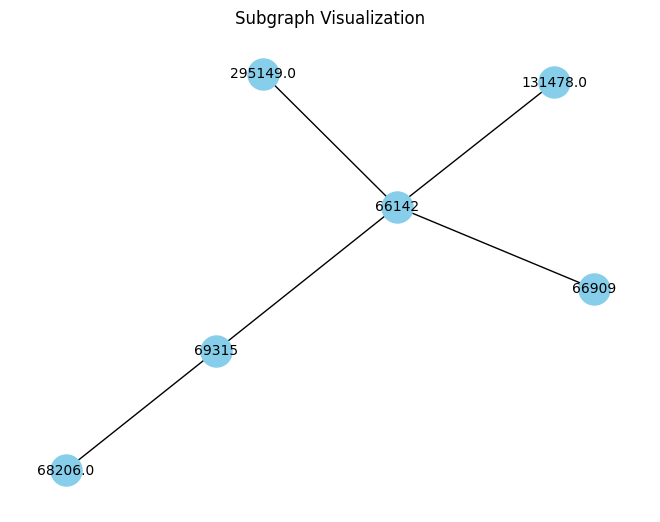

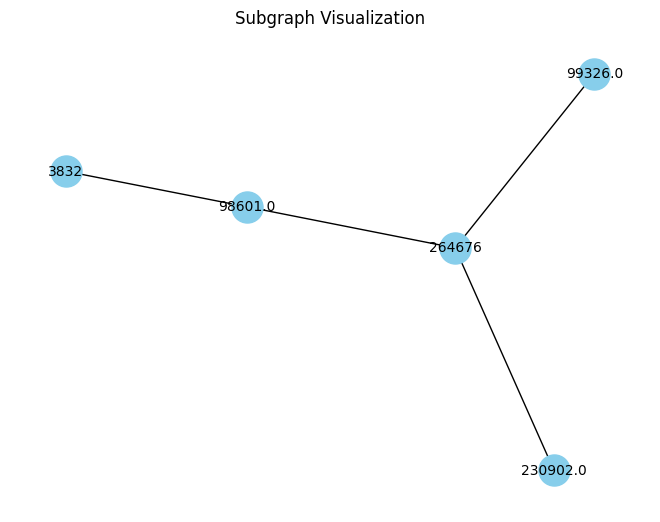

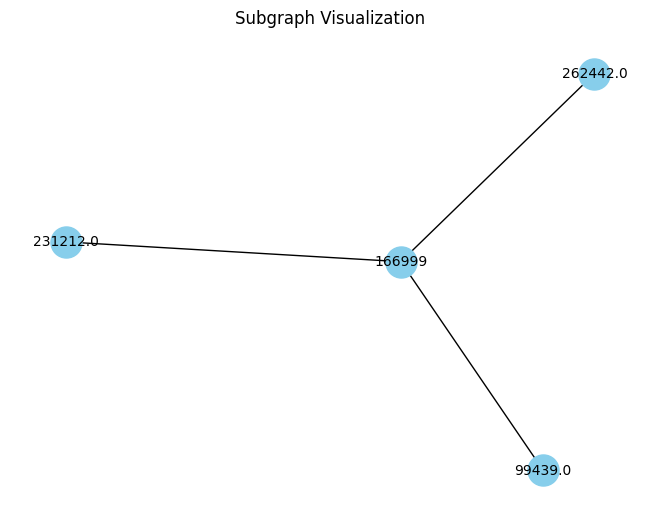

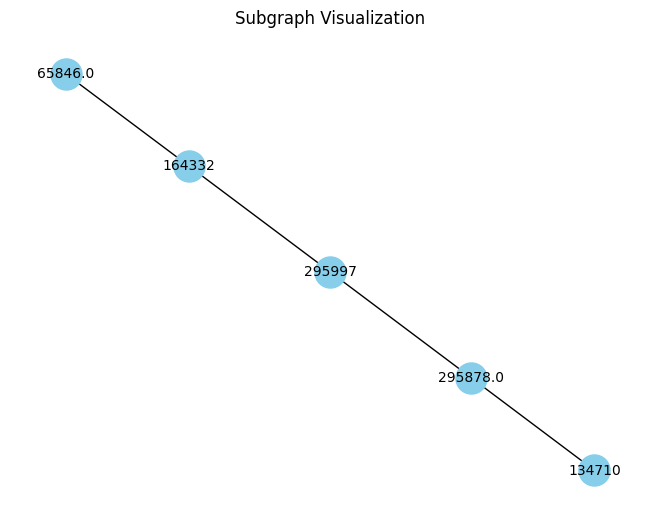

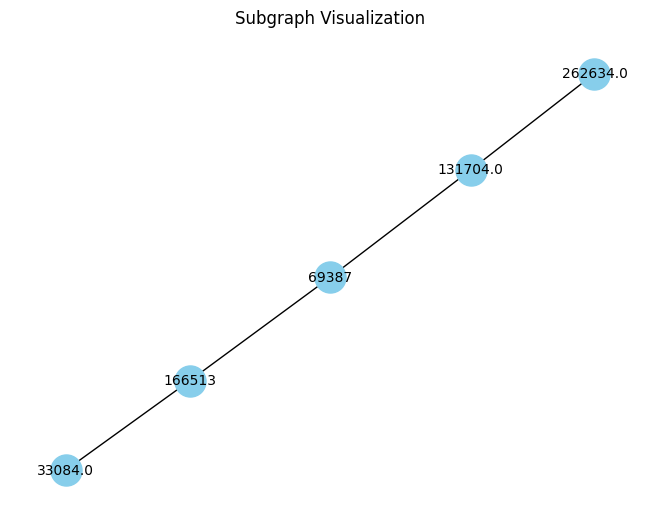

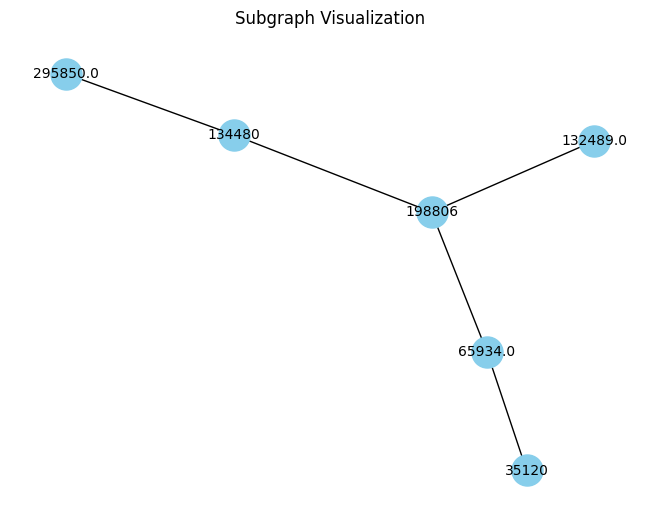

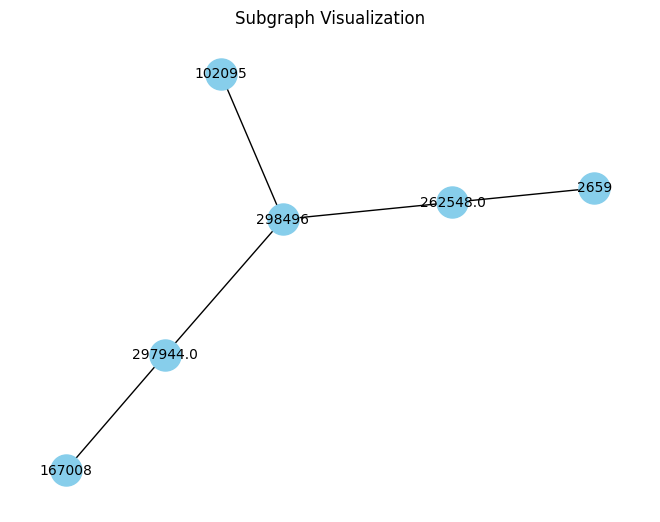

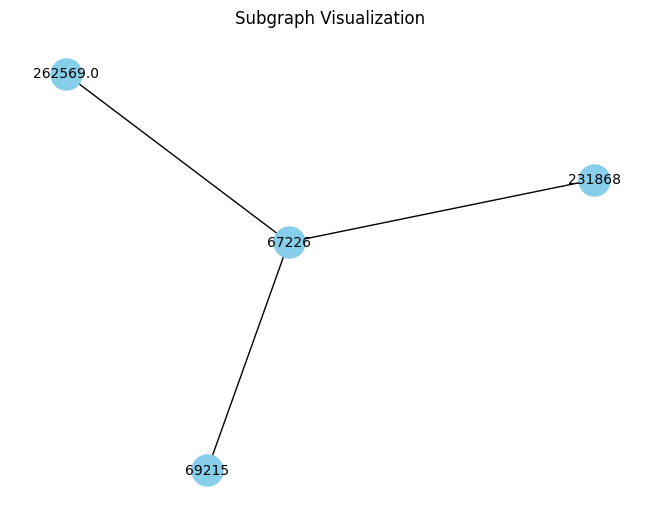

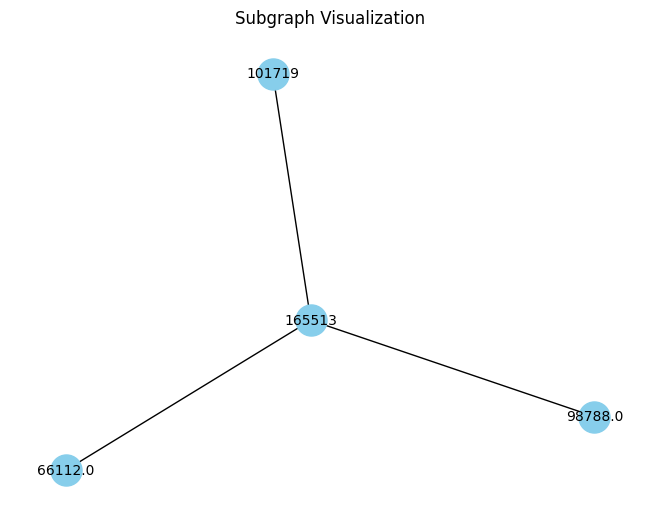

In [667]:
for s in range(len(small_connected_clusters[:20])):
    subgraph_nodes = small_connected_clusters[s]  
    subgraph = neighborhood_graph.subgraph(subgraph_nodes)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  
    nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
    plt.title("Subgraph Visualization")
    plt.show()

#### Get Data for Directed Graphs of Spectral Cluster for Diveristy with Community Constraints and Reasonable Cluster Size

For each of the clusters identified we can collected the data for them and do a manual investigation of the clusters that are likelistest trafficking clusters

In [734]:
# Make Neighbourhood Graph Directional
neighborhood_graph_directed = nx.DiGraph()
neighborhood_graph_directed.add_edges_from(neighborhood_graph.edges())

# Collect DataFrame Properties
nodes_list = []
suspicious_nodes_list = []
wire_amounts_list = []
countries_list = []
occupations_list = []
foreign_inbound_list = []
domestic_list = []
foreign_outbound_list = []
unknown_list = []
message_scores_list = []
names_list = []
ages_list = []
tenures_list = []


# Map node dictionary to kyc for node-lookup
df_kyc['node_id'] = df_kyc['cust_id'].map(node_dictionary)

# Map node dictionary to wire dataframe for node-lookup
df_wire['node_id_sender'] = df_wire['id sender'].map(node_dictionary)
df_wire['node_id_receiver'] = df_wire['id receiver'].map(node_dictionary)

for s in range(len(small_connected_clusters)):    
    subgraph_nodes = small_connected_clusters[s]  
    subgraph = neighborhood_graph_directed.subgraph(subgraph_nodes)

    # Reset lists & counts
    suspicious_node_count = 0
    foreign_inbound = 0
    domestic = 0
    foreign_outbound = 0
    unknown = 0
    nodes = []
    names = []
    ages = []
    tenures = []
    occupations = []
    countries = []

    # Color map
    color_map = {}

    # Identify suspicious nodes and store features
    for node in subgraph_nodes:

        # Store node
        nodes.append(node)

        # Look up name 
        name = df_kyc.loc[df_kyc['node_id']==node]['Name']
        if len(name) > 0:
            names.append(name)
        else:
            names.append(np.nan)
        
        # Look up age
        age = df_kyc.loc[df_kyc['node_id']==node]['Age']
        if len(age) > 0:
            ages.append(age)
        else:
            ages.append(np.nan)
        
        # Look up tenure
        tenure = df_kyc.loc[df_kyc['node_id']==node]['Tenure']
        if len(tenure) > 0:
            tenures.append(tenure)
        else:
            tenures.append(np.nan)

        # Look up occupation
        occupation = df_kyc.loc[df_kyc['node_id']==node]['Occupation']
        if len(occupation) >0:
            occupations.append(occupation)
        else:
            occupations.append(np.nan)

        # Look up Country
        country_sender = df_wire.loc[df_wire['node_id_sender']==node]['country sender']
        country_receiver = df_wire.loc[df_wire['node_id_receiver']==node]['country receiver']
        if len(country_sender) > 0:
            countries.append(country_sender.values[0])
        elif len(country_receiver) > 0:
            countries.append(country_receiver.values[0])
        else:
            countries.append(np.nan)


        # For suspicious nodes
        if node in all_positive_nodes:
            # color map
            color_map[node] = 1.0
            # update suspicious node count
            suspicious_node_count+=1

        # For non-suspicious nodes
        else:
            # color map
            color_map[node] = 0.25
    
    # Store lists
    nodes_list.append(nodes)
    names_list.append(names)
    ages_list.append(ages)
    tenures_list.append(tenures)
    occupations_list.append(occupations)
    countries_list.append(countries)
    suspicious_nodes_list.append(suspicious_node_count) 

    # Color in the rest of the nodes
    values = [color_map.get(node, 0.25) for node in subgraph_nodes]

    # Edges analysis

    # Edge colors
    red_edges = []
    black_edges = []
    wire_amounts = []
    message_scores = []
    #Analyze Edges
    for edge in subgraph.edges():
        # Look up wire amount
        try:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['amount'].values[0]
        except:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                                  (df_edge['node id receiver'] == edge[0])]['amount'].values[0]
            wire_amounts.append(wire_amount)
        else:
            wire_amounts.append(wire_amount)

    
        # Look up message score
        try:
            message_score = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['key_word_score'].values[0]
        except:
            message_score = df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                                  (df_edge['node id receiver'] == edge[0])]['key_word_score'].values[0]
            message_scores.append(message_score)   
        else:
            message_scores.append(message_score)

        # update transaction counds
        try:
            foreign_inbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                           (df_edge['node id receiver'] == edge[1])]['foreign_inbound'].values[0]
        except:
            foreign_inbound += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                           (df_edge['node id receiver'] == edge[0])]['foreign_inbound'].values[0]
        
        try:
            foreign_outbound += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['foreign_outbound'].values[0]
        except:
            foreign_outbound += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['foreign_outbound'].values[0]  
        try: 
            domestic += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['domestic'].values[0]
        except:
            domestic += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['domestic'].values[0]
        try:
            unknown += df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                            (df_edge['node id receiver'] == edge[1])]['unknown'].values[0]
        except:
            unknown += df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                            (df_edge['node id receiver'] == edge[0])]['unknown'].values[0]

        # Color red edge
        if (edge[0] in all_positive_nodes) or (edge[1] in all_positive_nodes):
            red_edges.append(edge)
        # Color black edge
        else:
            black_edges.append(edge)

    # Edge labels
    edge_labels=dict([(edge, wire_amounts[i]) for i,edge in enumerate(subgraph.edges())])

    # Store counts
    foreign_inbound_list.append(foreign_inbound)
    domestic_list.append(domestic)
    foreign_outbound_list.append(foreign_outbound)
    unknown_list.append(unknown)
    wire_amounts_list.append(wire_amounts)
    message_scores_list.append(message_scores)


    # Draw the subgraph
    pos = nx.spring_layout(subgraph,k=5/np.sqrt(subgraph.order()))  # Layout for node positioning
    nx.draw_networkx_nodes(subgraph, pos, cmap = plt.get_cmap('jet'), node_color = values, node_size=500)
    nx.draw_networkx_labels(subgraph, pos)
    nx.draw_networkx_edges(subgraph, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(subgraph, pos, edgelist=black_edges, edge_color = 'black', arrows=True)
    nx.draw_networkx_edge_labels(subgraph,pos,edge_labels=edge_labels)
    plt.title("Subgraph Visualization")
    plt.show()

# Build DataFrame
df_suspicious_diverse_connceted_communities = pd.DataFrame({'nodes':nodes_list, 'names': names_list, 'wire amounts': wire_amounts_list, 'countries': countries_list,
                                       'message_scores': message_scores_list, 'foreign_inbound_trxs': foreign_inbound_list, 
                                       'domestic_trxs': domestic_list, 'foreign_outbound_trxs':foreign_outbound_list, 
                                       'unknown_trxs': unknown_list,'ages': ages_list, 'tenures': tenures_list})

#### Filter on Clusters with Foreign Countries

In [746]:
# Find clusters that have foreign countries
foreign_cluster_idxs = []
for i,countries in enumerate(countries_list):
    for country in countries:
        if (country != 'CA') & (country != 'GE') & (type(country) != float):
            foreign_cluster_idxs.append(i)


# Filter Cluster dataframe on clusters with foreign countries
df_suspicious_diverse_connceted_communities_foreign = df_suspicious_diverse_connceted_communities.loc[foreign_cluster_idxs]

# Get unique clusters
unique_clusters = []
unique_indices = []
for i,cluster in enumerate(df_suspicious_diverse_connceted_communities_foreign.nodes):
    if cluster not in unique_clusters:
        unique_clusters.append(cluster)
        unique_indices.append(i)

df_suspicious_diverse_connceted_communities_foreign = df_suspicious_diverse_connceted_communities_foreign.iloc[unique_indices]
            
# Summary
print('The number of clusters that have nodes from foreign countries is :', len(df_suspicious_diverse_connceted_communities_foreign))

The number of clusters that have nodes from foreign countries is : 17


#### Analyze Clusters with Foreign Countries for high transaction amounts and message scores

In [747]:
# Get maximum wire amount in each cluster
df_suspicious_diverse_connceted_communities_foreign['max_wire_amount'] = 0

for idx in df_suspicious_diverse_connceted_communities_foreign.index:
    wires = df_suspicious_diverse_connceted_communities_foreign.loc[idx]['wire amounts']
    df_suspicious_diverse_connceted_communities_foreign.loc[(df_suspicious_diverse_connceted_communities_foreign.index == idx),'max_wire_amount'] = np.max(wires)
    
df_suspicious_diverse_connceted_communities_foreign.sort_values(by=['max_wire_amount'], inplace=True)
df_suspicious_diverse_connceted_communities_foreign

C:\Users\stefa\AppData\Local\Temp\ipykernel_48072\2775045062.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10970.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_suspicious_diverse_connceted_communities_foreign.loc[(df_suspicious_diverse_connceted_communities_foreign.index == idx),'max_wire_amount'] = np.max(wires)


nodes  \
540                  [148528, 82855, 163882.0, 230047]   
525           [82855, 163882.0, 33866, 148528, 230047]   
232  [135360, 231233, 35367, 201512.0, 133866, 2324...   
309                [197344, 98545.0, 132073, 196975.0]   
305  [197344, 131432.0, 132073, 196975.0, 98545.0, ...   
296  [197344, 98816.0, 67175, 131432.0, 132073, 131...   
134  [196610.0, 33445.0, 213670.0, 262438.0, 294992...   
189       [33445.0, 213670, 229620.0, 246071.0, 98939]   
172  [196610.0, 33445.0, 213670.0, 229620.0, 50005,...   
154  [196610.0, 33445.0, 213670.0, 229620.0, 50005,...   
439    [65890.0, 98603.0, 131920, 49522, 66302, 99231]   
233                  [69697, 131297.0, 132062, 166791]   
426  [165112, 65890.0, 148298, 98603.0, 940, 131920...   
255                 [166921, 37539, 101121.0, 67087.0]   
238  [101319.0, 298094.0, 200403, 229748.0, 266772,...   
330        [180617.0, 196624.0, 148432, 229683.0, 660]   
258                  [67864.0, 201321, 135545, 133715]   

                                                 names  \
540                  [nan, nan, nan, [JUSTIN RAMIREZ]]   
525             [nan, nan, nan, nan, [JUSTIN RAMIREZ]]   
232  [[GAO XIA], [MRS. AMBER BLACK], [EMILY MARTINE...   
309  [nan, [RYAN MOORE], [BENJAMIN SMITH], [NATAN J...   
305  [nan, [TAO LONG], [BENJAMIN SMITH], [NATAN JAK...   
296  [nan, nan, [RAÚL BARRIENTOS], [TAO LONG], [BEN...   
134  [nan, [GARY SANCHEZ], nan, nan, nan, [ROBERT J...   
189  [[GARY SANCHEZ], nan, nan, [KEVIN LOPEZ], [SAR...   
172  [nan, [GARY SANCHEZ], nan, nan, [SAMANTHA SAUN...   
154  [nan, [GARY SANCHEZ], nan, nan, [SAMANTHA SAUN...   
439  [[JEREMY SMITH], [SARAH BOLDUC], nan, nan, nan...   
233  [[ANDREW LI], [MARCEL BEAUCHAMP], nan, [AMBER ...   
426  [[JACQUELINE RIVAS], [JEREMY SMITH], [PELAGEJA...   
255    [[DOMINIQUE NADEAU], nan, nan, [RAYMOND SMITH]]   
238  [[RHONDA BECK], nan, [JACQUELINE SMITH], nan, ...   
330  [[SÉBASTIEN LALIBERTÉ], nan, [CHRISTOPHER WELL...   
258     [[DR.JAMES WHITE], nan, nan, [JEANETTE LOPEZ]]   

                                          wire amounts  \
540                             [215.0, 456.0, 2288.0]   
525                     [215.0, 456.0, 2542.0, 2288.0]   
232  [47.0, 289.0, 190.0, 408.0, 257.0, 293.0, 57.5...   
309                            [588.0, 1900.0, 4495.0]   
305      [1900.0, 4495.0, 588.0, 755.0, 329.0, 1963.0]   
296  [1656.0, 588.0, 6125.5, 1900.0, 227.0, 420.0, ...   
134  [3363.0, 301.0, 235.0, 710.0, 4385.5, 48.0, 37...   
189                      [301.0, 48.0, 3715.0, 6170.0]   
172  [301.0, 48.0, 3715.0, 6170.0, 1288.0, 428.0, 2...   
154  [301.0, 4385.5, 48.0, 3715.0, 6170.0, 1288.0, ...   
439               [50.0, 9566.0, 255.0, 207.0, 6195.5]   
233                            [100.0, 264.0, 10970.5]   
426  [50.0, 9566.0, 255.0, 11584.0, 26.0, 5.5, 140....   
255                             [85.0, 12670.5, 172.0]   
238              [169.0, 68.0, 125.5, 1518.0, 14625.0]   
330                  [18633.0, 4655.5, 1819.5, 3046.5]   
258                            [31618.0, 952.5, 666.0]   

                                             countries  \
540                                 [nan, nan, IN, CA]   
525                             [nan, IN, US, nan, CA]   
232  [CA, CA, CA, AU, nan, nan, nan, CA, CA, CA, na...   
309                                  [IN, nan, CA, CA]   
305                    [IN, nan, CA, CA, nan, nan, CA]   
296  [IN, RU, nan, nan, CA, CA, CA, CA, nan, CA, na...   
134  [nan, nan, CA, nan, nan, CA, RU, CA, nan, CA, ...   
189                             [nan, CA, RU, nan, CA]   
172                [nan, nan, CA, RU, CA, nan, CA, CA]   
154            [nan, nan, CA, RU, CA, nan, CA, CA, CA]   
439                        [CA, nan, nan, nan, US, CA]   
233                                 [nan, CA, AU, nan]   
426  [nan, CA, nan, nan, nan, nan, nan, CA, CA, CA,...   
255                                 [CA, IN, nan, nan]   
238                         [nan, US, CA, na

[148528, 82855, 163882.0, 230047]


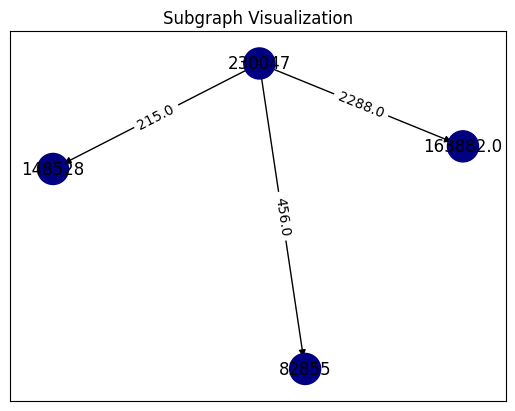

[82855, 163882.0, 33866, 148528, 230047]


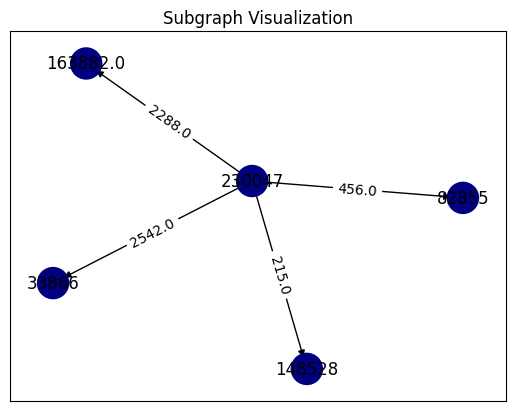

[135360, 231233, 35367, 201512.0, 133866, 232492, 295919, 131376.0, 232624, 299857, 229589.0, 266165, 661.0, 100315.0]


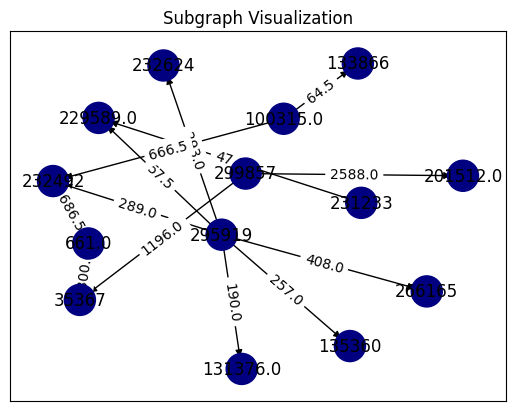

[197344, 98545.0, 132073, 196975.0]


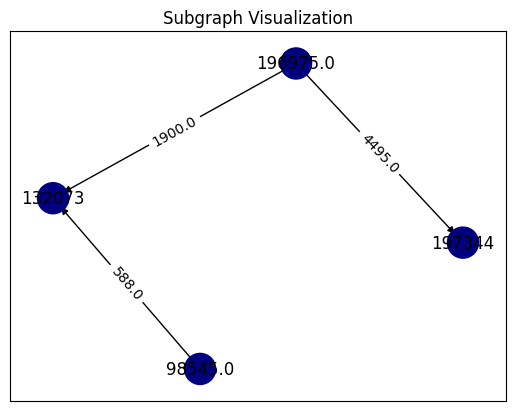

[197344, 131432.0, 132073, 196975.0, 98545.0, 263640, 198043]


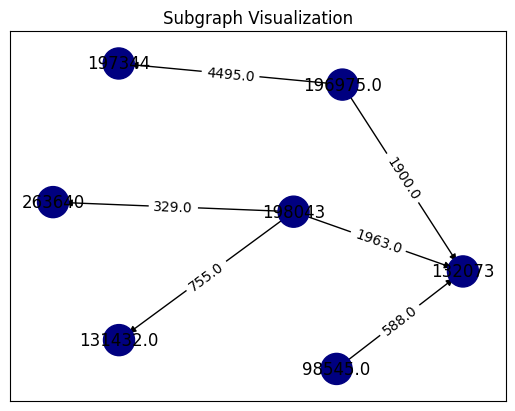

[197344, 98816.0, 67175, 131432.0, 132073, 131657.0, 100968.0, 34028, 34221, 196975.0, 98545.0, 1041, 166197.0, 65941.0, 263640, 134073, 198043, 297980.0]


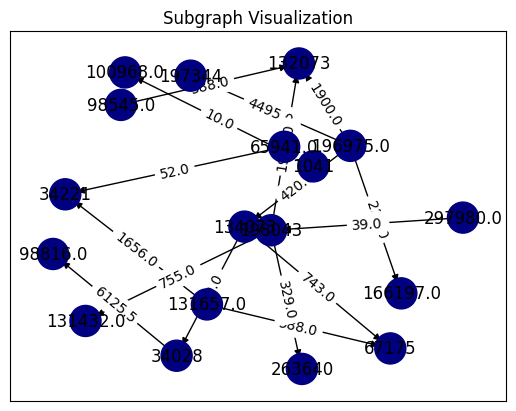

[196610.0, 33445.0, 213670.0, 262438.0, 294992.0, 1235, 229620.0, 50005, 246071.0, 17466, 98939.0, 279454]


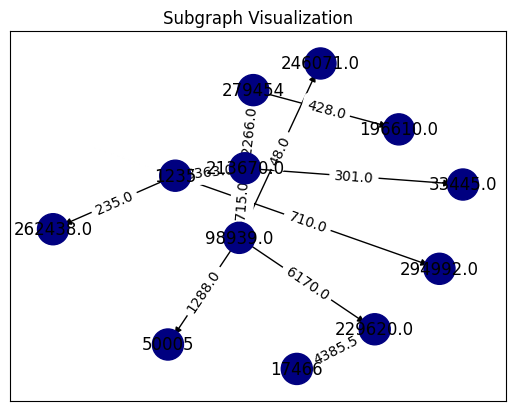

[33445.0, 213670, 229620.0, 246071.0, 98939]


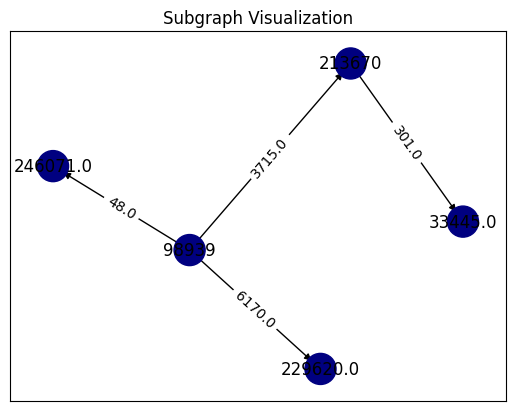

[196610.0, 33445.0, 213670.0, 229620.0, 50005, 246071.0, 98939.0, 279454]


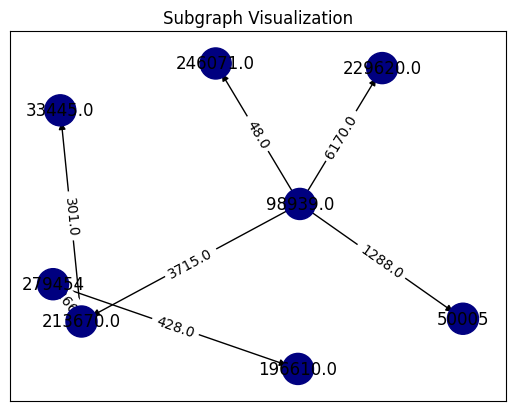

[196610.0, 33445.0, 213670.0, 229620.0, 50005, 246071.0, 17466, 98939.0, 279454]


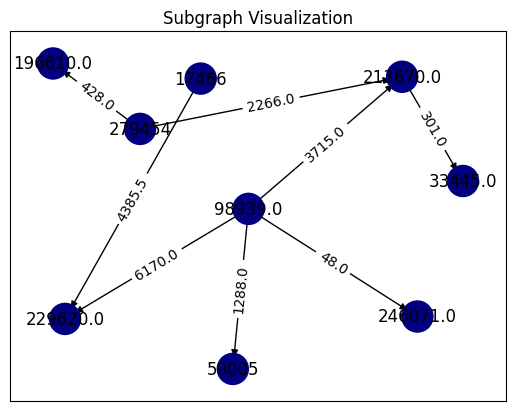

[65890.0, 98603.0, 131920, 49522, 66302, 99231]


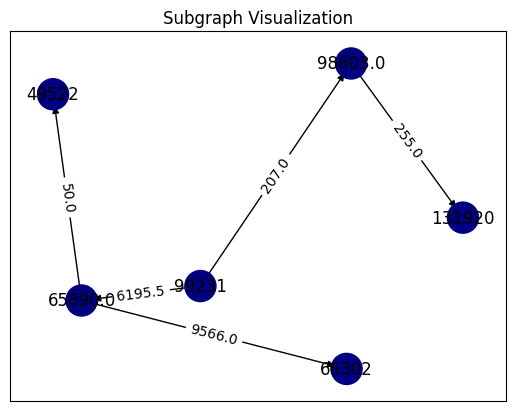

[69697, 131297.0, 132062, 166791]


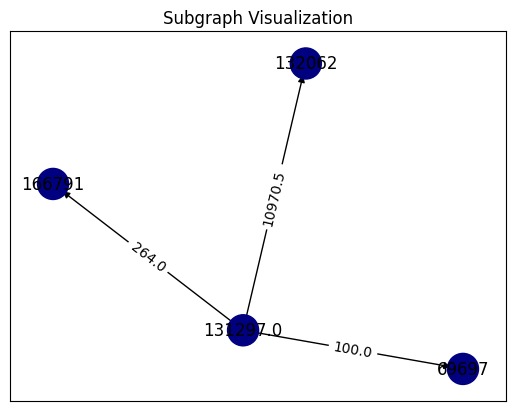

[165112, 65890.0, 148298, 98603.0, 940, 131920, 49522, 116052, 163864.0, 33308, 66302.0, 99231]


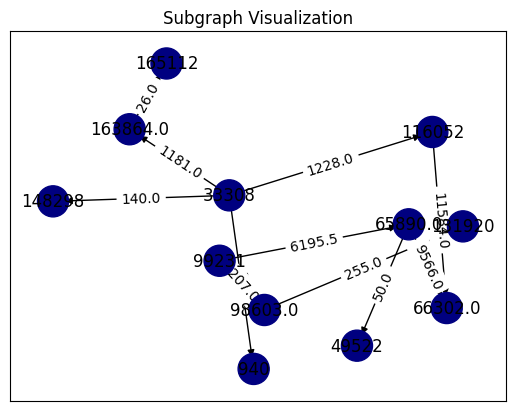

[166921, 37539, 101121.0, 67087.0]


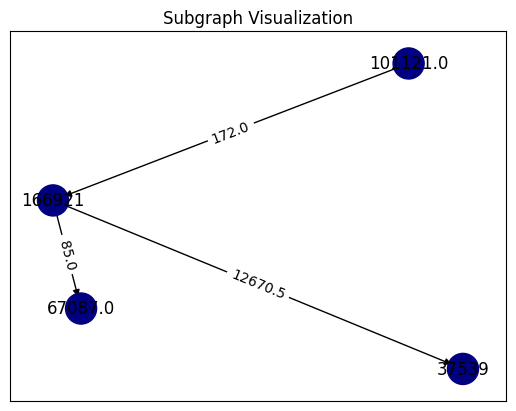

[101319.0, 298094.0, 200403, 229748.0, 266772, 4120]


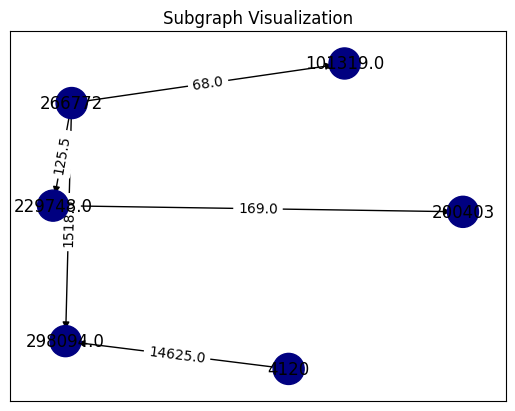

[180617.0, 196624.0, 148432, 229683.0, 660]


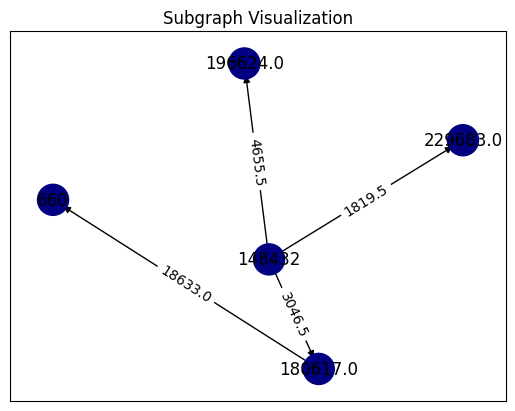

In [798]:
for cluster in df_suspicious_diverse_connceted_communities_foreign.nodes: 
    print(cluster)   
    subgraph_nodes = cluster 
    subgraph = neighborhood_graph_directed.subgraph(subgraph_nodes)

    # Color map
    color_map = {}

    # Identify suspicious nodes and store features
    for node in subgraph_nodes:

        # Store node
        nodes.append(node)


        # For suspicious nodes
        if node in all_positive_nodes:
            # color map
            color_map[node] = 1.0

        # For non-suspicious nodes
        else:
            # color map
            color_map[node] = 0.25

    # Color in the rest of the nodes
    values = [color_map.get(node, 0.25) for node in subgraph_nodes]

    # Edges analysis

    # Edge colors
    red_edges = []
    black_edges = []
    wire_amounts = []
    #Analyze Edges
    for edge in subgraph.edges():
        # Look up wire amount
        try:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[0]) & 
                                  (df_edge['node id receiver'] == edge[1])]['amount'].values[0]
        except:
            wire_amount = df_edge.loc[(df_edge['node id sender'] == edge[1]) & 
                                  (df_edge['node id receiver'] == edge[0])]['amount'].values[0]
            wire_amounts.append(wire_amount)
        else:
            wire_amounts.append(wire_amount)

        # Color black edge
        black_edges.append(edge)

    # Edge labels
    edge_labels=dict([(edge, wire_amounts[i]) for i,edge in enumerate(subgraph.edges())])


    # Draw the subgraph
    pos = nx.spring_layout(subgraph,k=5/np.sqrt(subgraph.order()))  # Layout for node positioning
    nx.draw_networkx_nodes(subgraph, pos, cmap = plt.get_cmap('jet'), node_color = values, node_size=500)
    nx.draw_networkx_labels(subgraph, pos)
    nx.draw_networkx_edges(subgraph, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(subgraph, pos, edgelist=black_edges, edge_color = 'black', arrows=True)
    nx.draw_networkx_edge_labels(subgraph,pos,edge_labels=edge_labels)
    plt.title("Subgraph Visualization")
    plt.show()


#### Save Nodes in Clusters

In [764]:
# Store these nodes
nodes_in_foreign_clusters = []
for nodes in df_suspicious_diverse_connceted_communities_foreign.nodes:
    nodes_in_foreign_clusters.extend(nodes)

spectral_clusters_connected_foreign_countries = list(set(nodes_in_foreign_clusters))
len(spectral_clusters_connected_foreign_countries)

84

## Final Nodes

In [787]:
# Update Main Actors List
all_positive_nodes = all_positive_nodes + spectral_clusters_connected_foreign_countries

# Get customer ids for main actors
main_actors_cust_id = [key for key, idx in node_dictionary.items() for i in all_positive_nodes if i == idx ] + trafficker_ids

main_actors_cust_id = [id for id in main_actors_cust_id if id not in task_3_traffickers] # Remove Customer ID's from task 3 used to train

In [790]:
main_actors_cust_id

['EXTERNAL863725',
 'CUST62704830',
 'CUST86725634',
 'CUST87472782',
 'CUST38703292',
 'CUST65528006',
 'CUST46613259',
 'EXTERNAL930426',
 'CUST24551749',
 'CUST92679626',
 'CUST26052059',
 'CUST20067966',
 'EXTERNAL179863',
 'CUST76204067',
 'EXTERNAL561018',
 'CUST27536663',
 'CUST52770620',
 'CUST11493450',
 'EXTERNAL736163',
 'EXTERNAL526989',
 'CUST92710058',
 'CUST27108024',
 'CUST10920547',
 'EXTERNAL963477',
 'CUST29151620',
 'CUST76553428',
 'CUST31943025',
 'EXTERNAL825735',
 'EXTERNAL245143',
 'CUST40076131',
 'CUST57175671',
 'CUST37801458',
 'EXTERNAL158213',
 'EXTERNAL970572',
 'CUST90263259',
 'CUST64445106',
 'CUST76086531',
 'CUST41147685',
 'EXTERNAL905380',
 'CUST37033397',
 'CUST26373515',
 'EXTERNAL164387',
 'EXTERNAL683874',
 'EXTERNAL350995',
 'CUST34229684',
 'EXTERNAL633700',
 'CUST99587813',
 'EXTERNAL524810',
 'CUST92017201',
 'EXTERNAL676549',
 'EXTERNAL395504',
 'EXTERNAL994372',
 'EXTERNAL166488',
 'CUST32990392',
 'CUST69526665',
 'EXTERNAL927795',
 'CU